#  <center> Taller  de Aprendizaje Automático </center>
##  <center> Taller 3: Demanda de bicicletas compartidas  </center>

# Introducción

En esta actividad se trabajará sobre el *dataset* de la competencia [*Bike Sharing Demand*](https://www.kaggle.com/c/bike-sharing-demand) de *Kaggle*. El objetivo de la competencia, predecir la demanda de bicicletas a partir de la combinación de datos históricos sobre demanda y clima.

El conjunto corresponde a datos de alquiler por hora y abarcan dos años de información. El subconjunto de *train* está compuesto por los primeros 19 días de cada mes, mientras que el subconjunto de *test* va desde 20 hasta el final del mes. Este último debe ser utilizado solamente en la parte 10 para subir los resultados a la página de la competencia.

En esta actividad nos centraremos en el algoritmo **Decision Trees**, el cual al igual que *SVM* es un algoritmo versatil que se utiliza en problemas tanto de clasificación como de regresión. También trabajaremos con algoritmos basados en métodos de ensamble de estimadores, como son **Random Forest** y **Gradient Boosting**, que utilizan como estimador base **Decision Trees**.


## Objetivos


*   Conocer los estimadores *Decision Trees*, entender cómo funcionan para un problema de regresión, ver ventajas y desventajas.
*   Familiarizarse con los métodos de ensamblado de estimadores y entender cual es el objetivo de usar estos métodos.
*   Incorporar una función de transformación de columnas y una función de medida de desempeño personalizadas.


## Formas de trabajo

#### Opción 1: Trabajar localmente

##### Descarga de datos disponibles en Kaggle

Luego, para descargar el dataset de IMDb reviews:

In [1]:
!kaggle competitions download -c bike-sharing-demand

100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 399kB/s]
100%|█████████████████████████████████████████| 189k/189k [00:00<00:00, 399kB/s]


Descomprima el archivo descargado:

In [2]:
import shutil
shutil.unpack_archive('./bike-sharing-demand.zip', './')

#### Opción 2:  Trabajar en *Colab*.

Se puede trabajar en Google Colab. Para ello es necesario contar con una cuenta de **google drive** y ejecutar un notebook almacenado en dicha cuenta. De lo contrario, no se conservarán los cambios realizados en la sesión. En caso de ya contar con una cuenta, se puede abrir el notebook y luego ir a `Archivo-->Guardar una copia en drive`.

La siguiente celda monta el disco personal del drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A continuación, vaya a su cuenta de [Kaggle](https://www.kaggle.com/) (o cree una si aún no lo ha hecho), haga clic en el icono de perfil en la esquina superior derecha de la pantalla y seleccione "Your Account" en la lista desplegable. Luego, seleccione la viñeta "Account" y haga clic en "Create new API token". Entonces un archivo llamado kaggle.json se descargará automáticamente a su carpeta de descargas. Este archivo contiene sus credenciales de inicio de sesión para permitirle acceder a la API.

La siguiente celda realiza la configuración necesaria para obtener datos desde la plataforma Kaggle. Le solicitará que suba el archivo kaggle.json descargado anteriormente.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import files

# El siguiente archivo solicitado es para habilitar la API de Kaggle en el entorno que está trabajando.
# Este archivo se descarga entrando a su perfíl de Kaggle, en la sección API, presionando donde dice: Create New API Token

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

#Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


Una vez guardado el *token* se pueden descargar los datos, en este caso se bajarán los datos del dataset IMDb reviews:

In [9]:
!kaggle competitions download -c bike-sharing-demand

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
!unzip bike-sharing-demand.zip

Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/TAA-fing/TAA-2024/blob/main/talleres/taller3_demanda_de_bicicletas.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Ejecutar en Google Colab</a>
  </td>
</table>

## Paquetes a utilizar

En esta actividad se utilizarán algunas bibliotecas auxiliares que deberán ser instaladas. Ejecutar la siguiente celda hasta que se ejecute sin errores. En caso de error, se puede instalar el paquete faltante desde el notebook con el comando:

`!pip install paquete_faltante`

In [1]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### (Opcional) librería de visualización de datos
#import seaborn as sns
#sns.set_theme(style="whitegrid")

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

## Parte 1 - Análisis de los datos

#### Objetivos

 - Analizar el conjunto de datos con las diferentes funciones de *pandas* que crea pertinente.

In [2]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df_train.size

130632

In [4]:
df_train.apply(lambda col: col.unique())

datetime      [2011-01-01 00:00:00, 2011-01-01 01:00:00, 201...
season                                             [1, 2, 3, 4]
holiday                                                  [0, 1]
workingday                                               [0, 1]
weather                                            [1, 2, 3, 4]
temp          [9.84, 9.02, 8.2, 13.12, 15.58, 14.76, 17.22, ...
atemp         [14.395, 13.635, 12.88, 17.425, 19.695, 16.665...
humidity      [81, 80, 75, 86, 76, 77, 72, 82, 88, 87, 94, 1...
windspeed     [0.0, 6.0032, 16.9979, 19.0012, 19.9995, 12.99...
casual        [3, 8, 5, 0, 2, 1, 12, 26, 29, 47, 35, 40, 41,...
registered    [13, 32, 27, 10, 1, 0, 2, 7, 6, 24, 30, 55, 47...
count         [16, 40, 32, 13, 1, 2, 3, 8, 14, 36, 56, 84, 9...
dtype: object

## Data Fields

1. datetime - hourly date + timestamp  
2. season -  1 = spring, 2 = summer, 3 = fall, 4 = winter
3. holiday - whether the day is considered a holiday
4. workingday - whether the day is neither a weekend nor holiday
5. weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
6. temp - temperature in Celsius
7. atemp - "feels like" temperature in Celsius
8. humidity - relative humidity
9. windspeed - wind speed
10. casual - number of non-registered user rentals initiated
11. registered - number of registered user rentals initiated
12. count - number of total rentals

In [5]:
df_train.isnull().sum(axis=0)

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

No hay datos nulos

<Axes: xlabel='weather'>

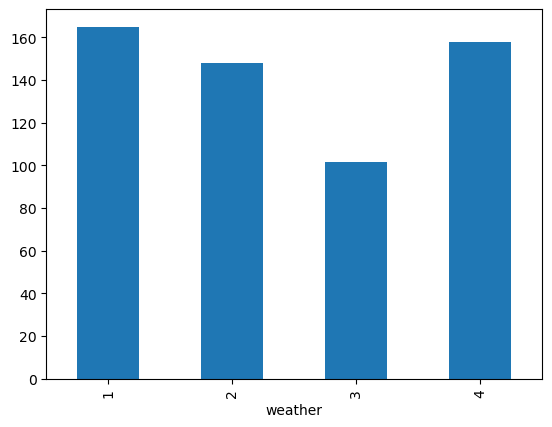

In [6]:
(df_train.groupby("weather")["registered"].mean()).plot(kind="bar")

<Axes: xlabel='weather'>

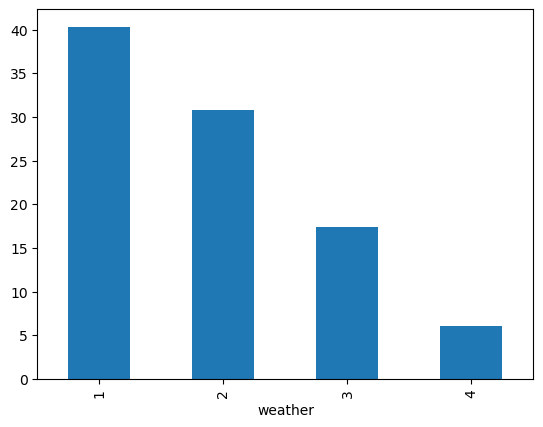

In [7]:
(df_train.groupby("weather")["casual"].mean()).plot(kind="bar")

#### Preguntas:

 - ¿Qué efecto tiene el tiempo (meteorológico) sobre el alquiler de bicicletas? ¿Es el mismo para clientes registrados y casuales? ¿Coincide esto con lo que asumiría a priori?
 - Vamos a trabajar con las codificaciones por defecto (salvo datetime que veremos en la Parte 2). ¿Le parece adecuado?
 - ¿Qué puede decir sobre la correlación entre *season* y *casual*?


Para los casuales, a peor tiempo menor proporcion de bicicletas alquiladas, pero los clientes registrados (probablemente ciclistas con mas experiencia) son menos susceptibles al clima.

## Parte 2 - Características temporales

La primer columna de los datos (*datetime*) corresponde a las marcas de tiempo asociadas a cada instancia. Para que estos tengan el orden cronológico que representan es necesario pasarlos de tipo *string* a tipo *datetime*. Para esto *Pandas* proporciona la función *to_datetime()*. Correr la siguiente celda para hacer el cambio.

In [8]:
df_train['datetime'] = pd.to_datetime(df_train['datetime'])

##### La figura siguiente muestra cómo varía la cantidad de bicicletas alquiladas en función del tiempo.

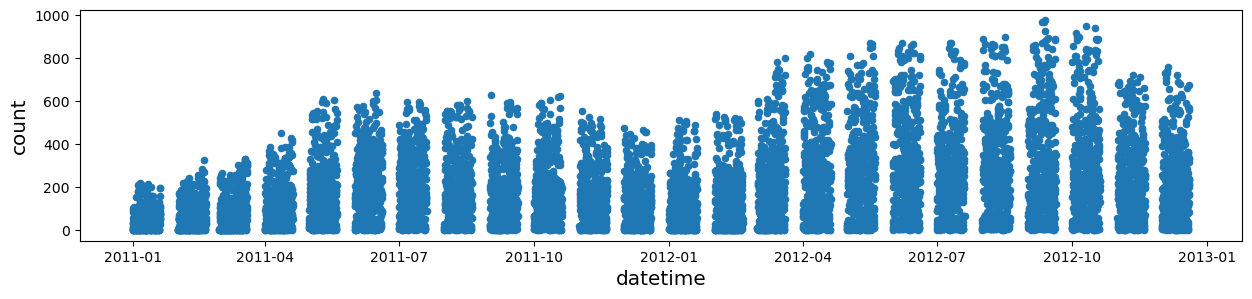

In [9]:
df_train.plot(x='datetime', y='count', figsize=[15,3],kind='scatter',color='tab:blue')
plt.xlabel('datetime',fontsize='x-large')
plt.ylabel('count',fontsize='x-large')
plt.show()

El tipo de dato *datetime* permite extraer de forma sencilla datos categóricos como la hora, el día de la semana, entre otros. La siguiente celda agrega a los datos de *train* estas nuevas características.

In [10]:
df_train['hour'] = df_train['datetime'].dt.hour
df_train['weekday'] = df_train['datetime'].dt.weekday

df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5


#### Ejercicio:

 - Grafique count, registered y casual en función de las horas y el día de la semana. ([*Sugerencia:*](https://seaborn.pydata.org/generated/seaborn.barplot.html) Ejemplos de la librería *seaborn*)

/tmp/ipykernel_18483/794198271.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_18483/794198271.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


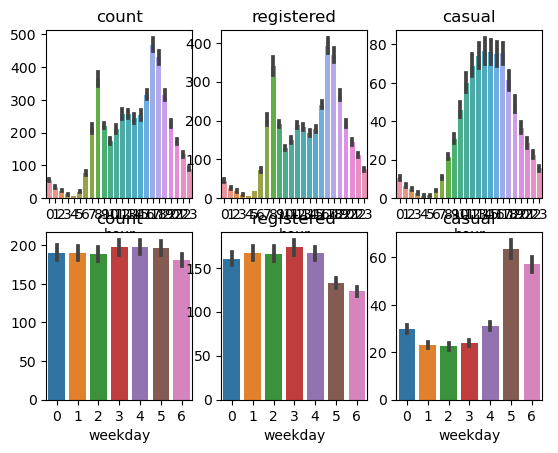

In [11]:
import seaborn as sns

columns = ["hour", "weekday"]
values = ["count", "registered", "casual"]

fig, ax = plt.subplots(len(columns), len(values))

for i, c in enumerate(columns):
  for j, v in enumerate(values):
    sns.barplot(df_train.pivot(columns=c, values=v), ax=ax[i, j])
    ax[i, j].set_title(v)

  fig.show()

##### A partir de las gráficas responder las siguientes preguntas:

 - ¿Cómo explicaría la diferencia entre las distribuciones de los clientes registrados y casuales?
 - ¿Qué desventaja le encuentra a utilizar un regresor lineal para predecir los alquileres a partir de la hora del día?¿Cómo transformaría esta característica para paliar este problema?
 - ¿Es necesaria esta transformación cuando se utilizan Árboles de Decisión?

- Los clientes registrados deben alquilar con mucha mas frecuencia y por lo tanto tienen distribuciones mas uniformes, pues tienen al ciclismo como un habito. Se notan picos en los horarios justo antes y despues del horario tipico laboral de 9 a 17 hs, apoyando la hipotesis del habito.
Los casuales por definicion van a andar en sus momentos libres y en tiempos mas agradables, por lo tanto la distribucion esta mas concentrada en los fines de semana y en la tarde o tardecita
- El problema principal es que la relacion entre alquileres y hora no es lineal. Se podria aplicar una transformacion polinomica para aumentar la complejidad del regresor y evitar un subajuste.
- No es necesaria ya que los arboles son no parametricos, es decir son capaces de ajustar su complejidad hacia el modelo (con el peligro de sobreajustarse facilmente)

#### Selección de Características:

*   Entre el día, el mes y el año ¿cuáles de estos datos les pareces agregar como nuevas características y cuáles no? y ¿Por qué?
*   Agregar las características seleccionadas.

- Me parece correcto agregar el mes pero no el ano ni el dia. La eleccion de partir los datos en entrenamiento y test en base a un dia del mes indica, o que no debemos depender del dia del mes ya que el modelo generalizaria mal, o que los dias del mes no son relevantes para el problema. No elegiria el ano ya que la grafica donde se compara mes a mes se ve que ambos anos tienen la misma distribucion, pero el 2012 con mas amplitud que el 2011, no es relevante para nuestro conjunto de test pero el crecimiento de los alquileres puede ser relevante si se quiere predecir en anos posteriores.

In [12]:
df_train['month'] = df_train['datetime'].dt.month


## Parte 3 - Preparación de los datos y Métrica de evaluación

Previo a trabajar con los estimadores:

*   Apartar la columna objetivo y eliminarla del conjunto de entrenamiento.
*   Eliminar las columnas *'casual'* y *'registered'*. ¿Por qué esto es necesario?.
*   Eliminar la columna *'datetime'*.

Durante la actividad los estimadores deben ser evaluados con la misma medida de desempeño utilizada en la competencia:

Root Mean Squared Logarithmic Error (RMSLE)
$$\sqrt{\frac{1}{n}\sum_{i}^{n}\big(\log(y_{i} + 1) - \log(\hat{y}_{i} + 1)\big)^2}$$

Este tipo de medida se utiliza cuando los valores a estimar son grandes. La librería *Scikit-Learn* incluye la función de desempeño [*mean_squared_log_error*](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error) (MSLE), esta función se puede utilizar  para la validación ya que alcanza las mismas soluciones que su raíz (RMSLE). De igual forma los resultados se deben mostrar con RMSLE.

In [13]:
from sklearn.model_selection import train_test_split

X = df_train.copy()
y = df_train["count"]

# "count" es la columna objetivo, "casual" y "registered" son parte del objetivo
# pero solo queremos predecir la cantidad total de bicicletas alquiladas.
X = X.drop(columns=["count", "casual", "registered", "datetime"])

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=None, random_state=42)

## Parte 4 - Decision Trees

### TransformedTargetRegressor

Observando los valores de las etiquetas se puede ver que la distribución de estos tiene una asimetría a la derecha, por lo que se puede aplicar una transformación logarítmica para que la distribución de las etiquetas sea más normal.

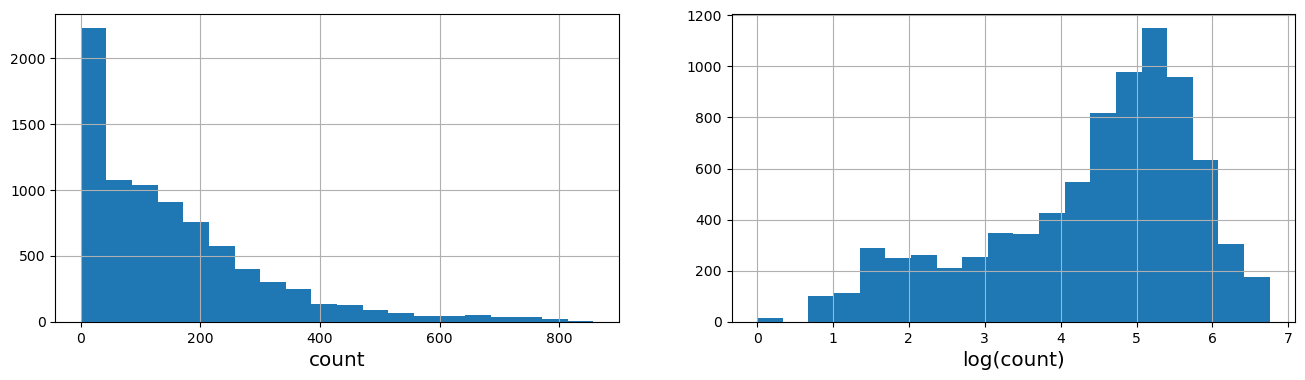

In [163]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
y_train.hist(bins=20)
plt.xlabel('count',fontsize='x-large')
plt.subplot(1,2,2)
np.log1p(y_train).hist(bins=20)
plt.xlabel('log(count)',fontsize='x-large')
plt.show()

Si le pasamos al regresor estas etqiquetas tranformadas este predecirá el logaritmo de los alquileres, por lo que luego deberíamos calcular la exponencial del valor predicho. Por suerte, Scikit-Learn cuenta con la función [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html) que resuelve este problema.

**Nota: Consultar el Capítulo 2 del Libro del Curso por más información**

#### Objetivos

*   Importar la función *DecisionTreeRegressor()* de *Scikit-Learn* y utilizar *TransformedTargetRegressor* para tranformar logarítmicamente las etiquetas. Utilizar las funciones ***np.log1p*** y ***np.expm1*** para calcular el logaritmo y la exponencial respectivamente (ver ejemplo en ayuda de la función *TransformedTargetRegressor*).
*   Aplicar validación cruzada (10-Folds) a un estimador con los hiper-parámetros por defecto.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Para lo último utilizar la función *fill_between()* de *matplotlib*.

**Nota:** Puede pasarle ***random-state=2*** al estimador,*DecisionTreeRegressor()*,  para controlar la aleatoreidad del mismo. De no hacerlo puede que los resultados que obtenga difieran en cierta medida de los esperados.

In [10]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate

regressor = TransformedTargetRegressor(
    regressor=DecisionTreeRegressor(random_state=42),
    func=np.log1p, inverse_func=np.expm1
)

cv = cross_validate(regressor, X_train, y_train, cv=10, scoring='neg_root_mean_squared_log_error', return_train_score=True)
rmsle_train = -cv['train_score']
rmsle_val = -cv['test_score']

mean_rmsle_train = rmsle_train.mean()
std_rmsle_train = rmsle_train.std()
mean_rmsle_val = rmsle_val.mean()
std_rmsle_val = rmsle_val.std()

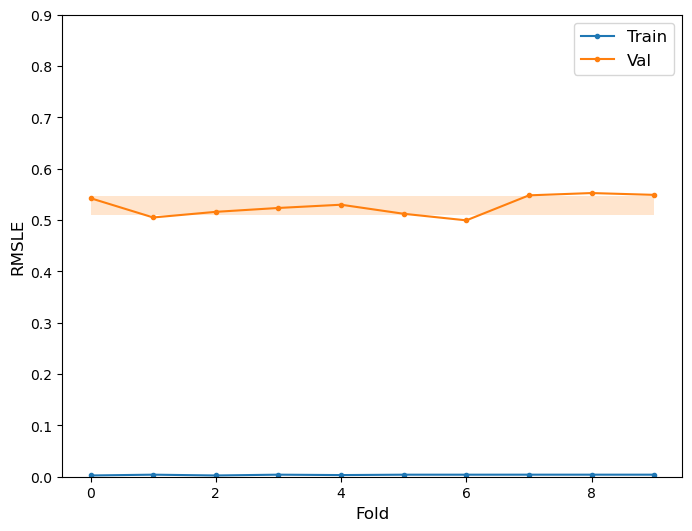

In [11]:
### Ayuda de Gráfica
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(rmsle_train, '.-',color='tab:blue',label='Train')
plt.plot(rmsle_val, '.-',color='tab:orange',label='Val')

## Se grafica la media y desviación etándar
plt.fill_between(np.arange(10), mean_rmsle_train + std_rmsle_train, mean_rmsle_train - std_rmsle_train, alpha=0.2)
plt.fill_between(np.arange(10), mean_rmsle_val + std_rmsle_val, mean_rmsle_val - std_rmsle_val, alpha=0.2)

plt.xlabel('Fold',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.ylim([0,0.9])
plt.show()

#### Preguntas:

*   ¿Qué fenómeno se logra apreciar en el gráfico? ¿A qué se debe? ¿Por qué esto es un problema?
*   Indicar y describir alguno de los hiper-parámetros que la función *DecisionTreeRegressor()* ofrece para limitar la complejidad del estimador.

Hay un gran sobreajuste debido a que el error es mucho mayor en el conjunto de validacion que en el de entrenamiento.

Uno de los hiperparametros que se puede ajustar es la profundidad del arbol, limitando este se logra regularizar el modelo.

#### Ejemplo Lack of smoothness

Como ejemplo se tomará la siguiente situación:

 - Domingo
 - Despejado o Parcialmente nublado
 - A las 19 horas
 - En primavera

Se observará el efecto de la temperatura en la predicción de alquileres de bicicletas.

 - ¿Cómo espera que sea dicho efecto en un rango de 10°C a 30°C?

In [86]:
index = 2685
Domingo = X_train.iloc[index:index+1]
Domingo

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month
8847,3,0,0,1,28.7,32.575,70,19.0012,0,5,8


In [87]:
## Se crea un dataframe con los datos del domingo
X_prueba = pd.concat([Domingo]*21,ignore_index=True)

index = 0
for k in np.linspace(10,30,21):
    X_prueba.loc[index,'temp']= k
    ## De igual manera se cambia la sensación térmica para mantener cierta coherencia
    X_prueba.loc[index,'atemp']= k
    index += 1

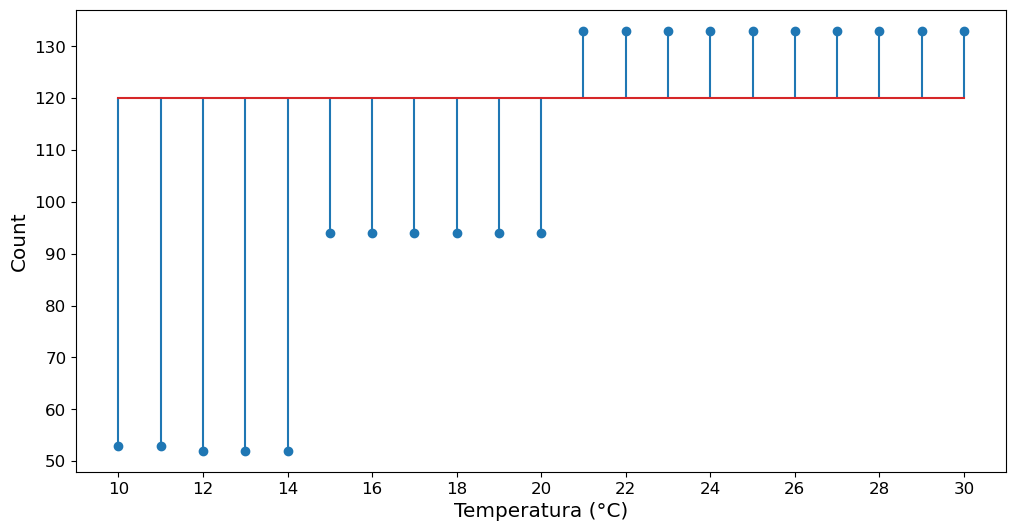

In [88]:
## regressor es el nombre de la variable que contiene el modelo de arbol de decisión
regressor.fit(X_train,y_train)

plt.figure(figsize=(12,6))
plt.stem(np.linspace(10,30,21),regressor.predict(X_prueba),bottom=120)
plt.xlabel('Temperatura (°C)',fontsize='x-large')
plt.ylabel('Count',fontsize='x-large')
plt.xticks(np.linspace(10,30,11),fontsize='large')
plt.yticks(fontsize='large')
plt.savefig('cambios_temp.png')
plt.show()

 - Observe el cambio que genera la temperatura a la salida (en particular el pasar de una temperatura de 23°C a 24°C, puede variar según la semilla, ver **Nota**).

 - ¿Qué desventaja le encuenta a los árboles de decisión en comparación con modelos lineales?

 **Nota:** Debido a la alta varianza de los Árboles de decisión los modelos obtenidos pueden variar de gran manera a efecto de pequeños cambios en el entrenamiento. En la carpeta se adjunta la imagen *cambios_temp.png* para que pueda discutir las preguntas a partir de la figura que se espera obtener.

La desventaja en cuestion es la discontinuidad en las predicciones, que no ocurren en un modelo lineal ya que el resultado es algebraico, mientras que un arbol decide de manera discreta.

### Ajuste Fino

#### Objetivos

*   Seleccionar uno de los hiper-parámetros y encontrar el mejor estimador.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados anteriores.
*   Graficar cómo varían los valores de RMSLE de entrenamiento y validación, para diferentes valores del hiper-parámetro.
*   Mostrar el mejor valor RMSLE (promedio de todos los *folds*) y el valor del hiper-parámetro.
*   Visualizar el árbol hasta los nodos de profundidad 2 utilizando la función *plot_tree()*. Agrandar el tamaño de la imagen de manera de poder leer la descripción de cada nodo.
*   Analizar las decisiones que está tomando el árbol para los primeros nodos.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones.

**Nota:** Puede ser útil la función *save_gs_results()* que se encuentra en el archivo *comet_log.py* de la carpeta del taller para organizar sus experimentos con Comet.

In [95]:
from comet_ml import Experiment

experiment = Experiment(
  api_key="tZzHrgZeB2lMeZSSnDvSFUAIV",
  project_name="taa-t3",
  workspace="xqft"
)

experiment.set_name("Decision tree CV")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/xqft/taa-t3/506084c9951f47a5883736942d5d87f1



In [12]:
from sklearn.model_selection import GridSearchCV

param_distributions = {"regressor__max_depth": [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

cv_gs = GridSearchCV(
    regressor, 
    param_distributions,
    scoring='neg_root_mean_squared_log_error',
    refit=True,
    return_train_score=True
).fit(X_train, y_train)

cv_results = pd.DataFrame(cv_gs.cv_results_)
best_cv_results = cv_results.iloc[cv_gs.best_index_]

best_cv_results

mean_fit_time                                    0.020402
std_fit_time                                     0.003473
mean_score_time                                  0.002512
std_score_time                                   0.000474
param_regressor__max_depth                              9
params                        {'regressor__max_depth': 9}
split0_test_score                               -0.496665
split1_test_score                               -0.503364
split2_test_score                               -0.510295
split3_test_score                               -0.486623
split4_test_score                               -0.472262
mean_test_score                                 -0.493842
std_test_score                                    0.01332
rank_test_score                                         1
split0_train_score                              -0.365262
split1_train_score                              -0.382643
split2_train_score                              -0.373994
split3_train_s

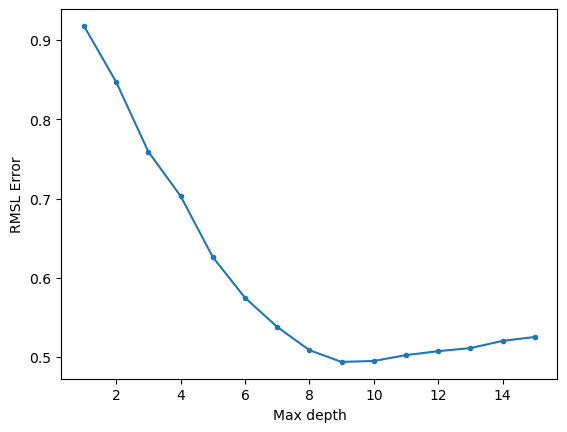

In [18]:
mean_test_scores = -cv_results["mean_test_score"]
params = cv_results["param_regressor__max_depth"]
plt.plot(params, mean_test_scores, '.-')
plt.xlabel("Max depth")
plt.ylabel("RMSL Error")
plt.savefig('max_depth.png', dpi=400)
plt.show()

In [97]:
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.058118,0.005531,0.003406,0.000485,None,{'regressor__max_depth': None},-0.550595,-0.532411,-0.542036,-0.533570,...,-0.541721,0.007751,10,-0.002566,-0.002571,-0.003363,-0.004203,-0.004233,-0.003387,0.000738
1,0.009682,0.000289,0.003373,0.000579,1,{'regressor__max_depth': 1},-0.936907,-0.914822,-0.925935,-0.902606,...,-0.917917,0.012190,16,-0.912737,-0.918220,-0.915524,-0.921261,-0.919640,-0.917476,0.003028
2,0.011672,0.000300,0.003174,0.000177,2,{'regressor__max_depth': 2},-0.856187,-0.842413,-0.846019,-0.842268,...,-0.847260,0.005182,15,-0.840192,-0.843581,-0.841690,-0.843586,-0.840903,-0.841990,0.001384
3,0.014715,0.000549,0.003349,0.000301,3,{'regressor__max_depth': 3},-0.774571,-0.755063,-0.763597,-0.753359,...,-0.759146,0.009033,14,-0.747732,-0.758466,-0.750142,-0.758396,-0.753704,-0.753688,0.004314
4,0.017294,0.000735,0.003676,0.000466,4,{'regressor__max_depth': 4},-0.714941,-0.705932,-0.699761,-0.708523,...,-0.703217,0.009489,13,-0.682362,-0.697508,-0.680885,-0.696117,-0.687218,-0.688818,0.006870


In [98]:
from comet_log import save_gs_results

rmsle_train = -pd.Series([
    best_cv_results['split0_train_score'],
    best_cv_results['split1_train_score'],
    best_cv_results['split2_train_score'],
    best_cv_results['split3_train_score'],
    best_cv_results['split4_train_score'],
])
rmsle_val = -pd.Series([
    best_cv_results['split0_test_score'],
    best_cv_results['split1_test_score'],
    best_cv_results['split2_test_score'],
    best_cv_results['split3_test_score'],
    best_cv_results['split4_test_score'],
])

mean_rmsle_train = -best_cv_results['mean_train_score']
std_rmsle_train = best_cv_results['std_train_score']
mean_rmsle_val = -best_cv_results['mean_test_score']
std_rmsle_val = best_cv_results['std_test_score']

save_gs_results(experiment, cv_gs)

experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Fine tune decision tree
COMET INFO:     url                   : https://www.comet.com/xqft/taa-t3/506084c9951f47a5883736942d5d87f1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Train RMSLE [5] : (0.358488410230979, 0.38763515818942984)
COMET INFO:     Val RMSLE [5]   : (0.47226185202107224, 0.5102954895425696)
COMET INFO:   Others:
COMET INFO:     Name : Fine tune decision tree
COMET INFO:   Parameters:
COMET INFO:     accept_sparse                                  : False
COMET INFO:     ccp_alpha                                      : 0.0
COMET INFO:     check_inverse                                  : True
COMET INFO:     criterion    

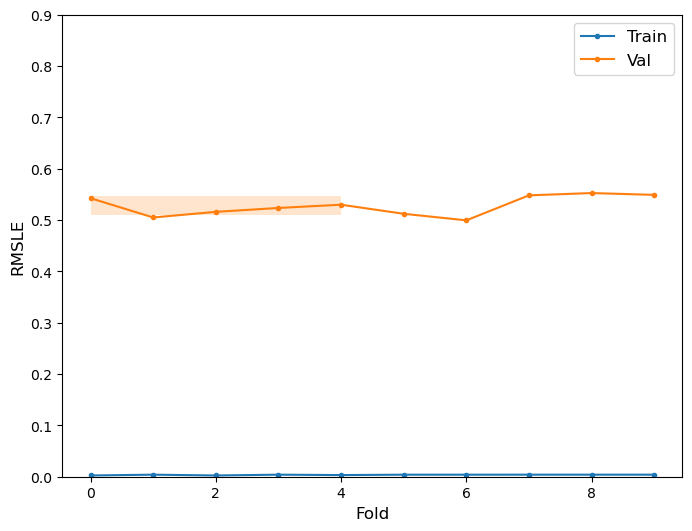

In [19]:
### Ayuda de Gráfica
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(rmsle_train, '.-',color='tab:blue',label='Train')
plt.plot(rmsle_val, '.-',color='tab:orange',label='Val')

## Se grafica la media y desviación etándar
plt.fill_between(np.arange(5), mean_rmsle_train + std_rmsle_train, mean_rmsle_train - std_rmsle_train, alpha=0.2)
plt.fill_between(np.arange(5), mean_rmsle_val + std_rmsle_val, mean_rmsle_val - std_rmsle_val, alpha=0.2)

plt.xlabel('Fold',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.ylim([0,0.9])
plt.show()

Se observa menor varianza y una leve mejora en el error de validacion, y mucha menos distancia entre el error fuera y dentro de muestra, indicando que el modelo fue regularizado

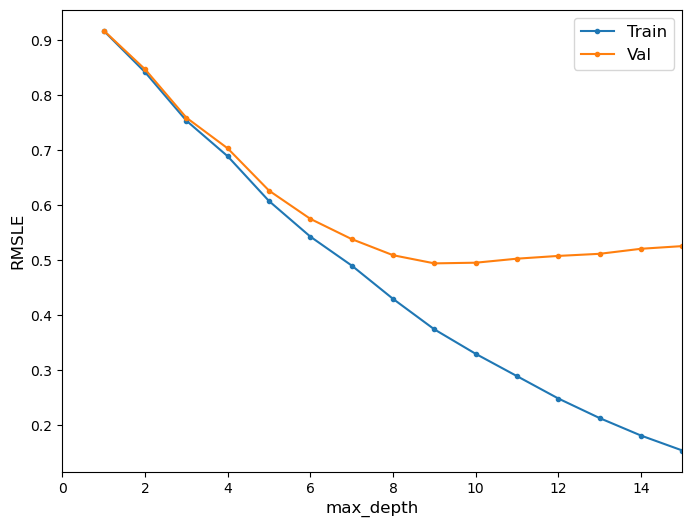

In [94]:
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(cv_results['param_regressor__max_depth'], -cv_results['mean_train_score'], '.-',color='tab:blue',label='Train')
plt.plot(cv_results['param_regressor__max_depth'], -cv_results['mean_test_score'], '.-',color='tab:orange',label='Val')

plt.xlabel('max_depth',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.xlim([0,15])
plt.show()

La mejoria no es en el rendimiento del modelo sino en su eficiencia: al limitar el tamano del arbol es posible entrenarlo mas rapidamente. Esto puede resultar muy util para ensambles grandes de arboles (random forest por ejemplo)

## Parte 5 - Random Forest

#### Preguntas sobre métodos de Ensamble:

*   ¿Cuáles son las ventajes de los métodos de Ensamble?
*   ¿A qué métodos de ensamble está asociado *Random Forest*?.
*   Importar la función *RandomForestRegressor()* de *Scikit-Learn*.
*   Indicar y describir los principales hiper-parámetros correspondientes a los métodos de ensamble que ofrece la función.




Respuestas:
- La ventaja es obtener un modelo altamente performante utilizando varios modelos debiles, a traves de alguna estrategia (bagging, boosting, stacking)
- Random Forest utiliza bagging: son multiples arboles de decision entrenados en subconjuntos aleatorios de los datos de entrenamiento.
- Los hiperparametros son los mismos a los de un arbol de decision, mas algunos especificos al metodo de ensamble: num_estimators es la cantidad de arboles en el bosque.

#### Ajuste fino



*   Encontrar el mejor estimador para *Random Forest* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los resultados correspondientes de la parte 4.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con el de la parte 4. Mostrar los valores seleccionados de los hiper-parámetros.
*   ¿Qué ventaja se pierde con repecto a usar un sólo árbol?
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con el gráfico correspondiente de la parte 4.
*   Mostrar la importancia de cada característica utilizando la variable *feature_importances_*.



In [99]:
from comet_ml import Experiment

experiment = Experiment(
  api_key="tZzHrgZeB2lMeZSSnDvSFUAIV",
  project_name="taa-t3",
  workspace="xqft"
)

experiment.set_name("Random forest CV")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/xqft/taa-t3/31948194c19f4f26904a4819cfbba466



In [112]:
from sklearn.ensemble import RandomForestRegressor

ensemble = RandomForestRegressor(
    n_estimators=100,
    max_depth = best_cv_results.params['regressor__max_depth'],
    random_state=42
)

regressor = TransformedTargetRegressor(
    regressor=ensemble,
    func=np.log1p, inverse_func=np.expm1
)

In [118]:
param_distributions = {"regressor__max_depth": [None] + list(range(1, 20))}
cv_splits=5
cv_gs = GridSearchCV(
    regressor, 
    param_distributions,
    scoring='neg_root_mean_squared_log_error',
    refit=True,
    return_train_score=True,
    cv=cv_splits
).fit(X_train, y_train)

cv_results = pd.DataFrame(cv_gs.cv_results_)
best_cv_results = cv_results.iloc[cv_gs.best_index_]

best_cv_results

mean_fit_time                                       2.517312
std_fit_time                                        0.030629
mean_score_time                                     0.049065
std_score_time                                       0.00356
param_regressor__max_depth                              None
params                        {'regressor__max_depth': None}
split0_test_score                                   -0.39455
split1_test_score                                    -0.3879
split2_test_score                                  -0.391166
split3_test_score                                  -0.374107
split4_test_score                                  -0.382594
mean_test_score                                    -0.386063
std_test_score                                      0.007161
rank_test_score                                            1
split0_train_score                                 -0.143935
split1_train_score                                 -0.144616
split2_train_score      

In [114]:
from comet_log import save_gs_results

rmsle_train = -pd.Series([best_cv_results[f'split{i}_train_score'] for i in range(cv_splits)])
rmsle_val = -pd.Series([best_cv_results[f'split{i}_test_score'] for i in range(cv_splits)])

mean_rmsle_train = -best_cv_results['mean_train_score']
std_rmsle_train = best_cv_results['std_train_score']
mean_rmsle_val = -best_cv_results['mean_test_score']
std_rmsle_val = best_cv_results['std_test_score']

save_gs_results(experiment, cv_gs)

experiment.end()

KeyError: 'split5_train_score'

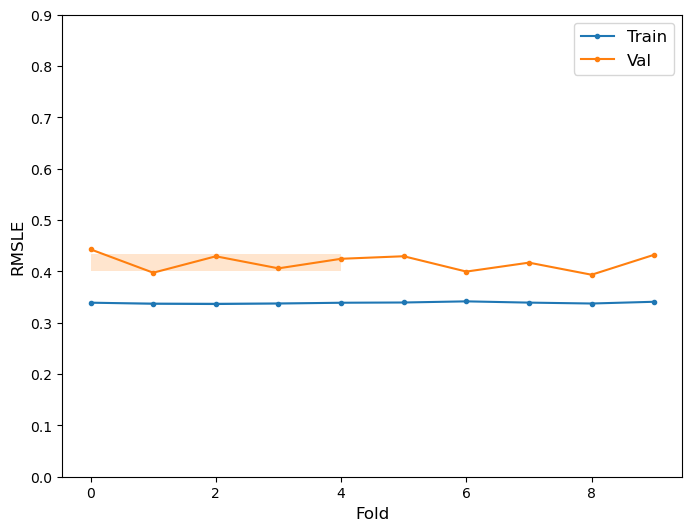

In [119]:
### Ayuda de Gráfica
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(rmsle_train, '.-',color='tab:blue',label='Train')
plt.plot(rmsle_val, '.-',color='tab:orange',label='Val')

## Se grafica la media y desviación etándar
plt.fill_between(np.arange(cv_splits), mean_rmsle_train + std_rmsle_train, mean_rmsle_train - std_rmsle_train, alpha=0.2)
plt.fill_between(np.arange(cv_splits), mean_rmsle_val + std_rmsle_val, mean_rmsle_val - std_rmsle_val, alpha=0.2)

plt.xlabel('Fold',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.ylim([0,0.9])
plt.show()

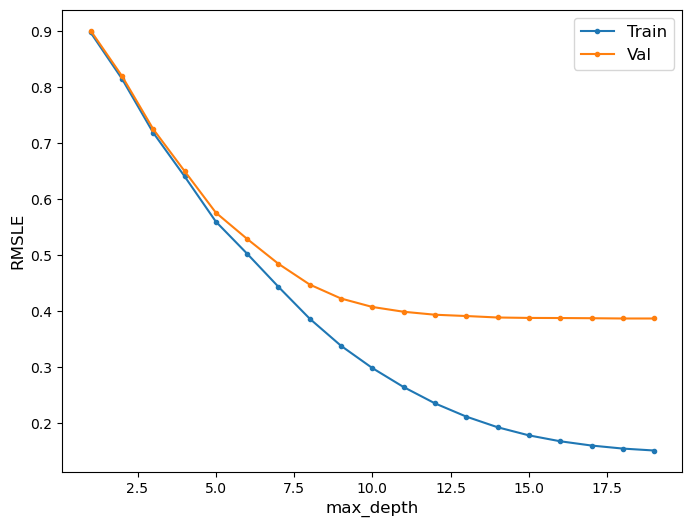

In [122]:
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(cv_results['param_regressor__max_depth'], -cv_results['mean_train_score'], '.-',color='tab:blue',label='Train')
plt.plot(cv_results['param_regressor__max_depth'], -cv_results['mean_test_score'], '.-',color='tab:orange',label='Val')

plt.xlabel('max_depth',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.show()

Hubo una leve mejora en la generalizacion del modelo. A pesar de que la busqueda concluyo en que el arbol no limitado es el optimo, se puede notar que luego de 10 no hay gran diferencia y a partir de ahi el modelo empieza a sobreajustarse, por lo que se puede mantener este valor y optimizar otros

## Parte 6 - Gradient Boosting

#### XGBoost

*   Indicar cuál es la principal diferencia entre *Bagging* y *Boosting*.
*   Importar la función *XGBRegressor()* de la librería [*xgboost*](https://github.com/dmlc/xgboost).
*   Este estimador a diferencia de los anteriores puede devolver predicciones negativas para estos datos. Indicar en que caso se pueda dar esto y por qué esto no sucedía con los estimadores anteriores.
*   Las predicciones negativas no pueden ser evaluadas por RMSLE. Por lo tanto, crear una nueva función de evaluación que fuerce a cero todos los valores negativos de las predicciones y luego calcule el valor de RMSLE. Para esto se debe utilizar la función *make_score* de *Sickit-Learn*, para que la nueva función pueda ser utilizada en las funciones de selección de modelos.


**Nota:** *Scikit-Learn* ofrece una implementación de *Gradient Boosting*, pero *XGBRegressor()* es la implementación de [*eXtreme Gradient Boosting*](https://arxiv.org/pdf/1603.02754.pdf?__hstc=133736337.1bb630f9cde2cb5f07430159d50a3c91.1513641600097.1513641600098.1513641600099.1&__hssc=133736337.1.1513641600100&__hsfp=528229161) un variante del algoritmo tradicional que dentro de algunas ventajas requiere menos tiempo de entrenamiento. La implementación de las funciones de la librería son muy similares a las de *Scikit-Learn*, de igual forma aquí le dejamos un [ejemplo](https://www.kaggle.com/alexisbcook/xgboost) de cómo usarla.







**Nota:** A partir de la versión **0.21** *Scikit-Learn* también ofrece una implementación de *Gradient Boosting* optimizada para data-sets grandes: [Histogram-based Gradient Boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html). Su funcionamiento se basa en agrupar en *bins* a los features de entrada, remplazandolos por integers. El número de *bins* es controlado por el hiperparámetro *max_bins*, el cual por defecto toma el valor 255 y no puede ser seteado a un valor mayor que este. En el Capítulo 7 del libro se encuentra más información acerca de este algoritmo.

- Bagging implica entrenar el mismo modelo en subconjuntos de los datos de entrenamiento y luego anadir los resultados finales mediante algun metodo. Boosting implica un entrenamiento secuencial, en donde un modelo se enfoca en arreglar los errores del anterior.

#### Ajuste fino



*   Encontrar el mejor estimador para *Gradient Boosting* usando como estimador base el encontrado en la parte 4.
*   Graficar los valores de RMSLE de entrenamiento y validación. Calcular la media y la desviación estandar e incluir esta última en el gráfico. Comparar con los gráficos correspondientes.
*   Mostrar el mejor valor de RMSLE (promedio de todos los folds) y compararlo con los anteriores. Mostrar los valores seleccionados de los hiper-parámetros.
*   Graficar los primeros 200 valores objetivo junto con sus predicciones. Comparar con los gráficos corespondientes.
*   ¿Qué compromiso hay entre los hiper-parámetros *n_estimators* y *learning_rate*?



In [121]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.4 MB/s eta 0:00:000m eta 0:00:010:00:01


In [191]:
from comet_ml import Experiment

experiment = Experiment(
  api_key="tZzHrgZeB2lMeZSSnDvSFUAIV",
  project_name="taa-t3",
  workspace="xqft"
)

experiment.set_name("XGBoost CV")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/xqft/taa-t3/42de43c9ea4144348147a2b5c434ae36



In [136]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
# debemos hacer un conjunto de validacion para utilizar early stopping rounds

In [20]:
from xgboost import XGBRegressor

boost = XGBRegressor(
    n_jobs=-1,
    n_estimators=1000,
    early_stopping_rounds=5,
    eval_metrc='neg_root_mean_squared_log_error',
    random_state=42
)
regressor = TransformedTargetRegressor(
    regressor=boost,
    func=np.log1p, inverse_func=np.expm1
)

In [26]:

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'regressor__max_depth': list(range(5, 12)),
    'regressor__learning_rate': np.linspace(0.01, 0.5, 100),
}

cv_splits = 2

cv_gs = RandomizedSearchCV(
    regressor, 
    param_distributions,
    scoring='neg_root_mean_squared_log_error',
    refit=True,
    return_train_score=True,
    cv=cv_splits,
    n_iter=100
    #n_candidates=10,
).fit(X_train, y_train, eval_set=[(X_val, y_val)])

[0]	validation_0-rmse:260.62771
[1]	validation_0-rmse:260.49177
[2]	validation_0-rmse:260.39678
[3]	validation_0-rmse:260.32995
[4]	validation_0-rmse:260.27971
[5]	validation_0-rmse:260.23221
[6]	validation_0-rmse:260.21160
[7]	validation_0-rmse:260.19434
[8]	validation_0-rmse:260.18131
[9]	validation_0-rmse:260.16984
[10]	validation_0-rmse:260.16402
[11]	validation_0-rmse:260.15891
[12]	validation_0-rmse:260.15581
[13]	validation_0-rmse:260.15174
[14]	validation_0-rmse:260.14849
[15]	validation_0-rmse:260.13653
[16]	validation_0-rmse:260.13166
[17]	validation_0-rmse:260.13086
[18]	validation_0-rmse:260.12942
[19]	validation_0-rmse:260.12679
[20]	validation_0-rmse:260.12453
[21]	validation_0-rmse:260.12380
[22]	validation_0-rmse:260.12330
[23]	validation_0-rmse:260.12320
[24]	validation_0-rmse:260.12131
[25]	validation_0-rmse:260.11553
[26]	validation_0-rmse:260.11194
[27]	validation_0-rmse:260.11104
[28]	validation_0-rmse:260.10731
[29]	validation_0-rmse:260.10691
[30]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.10555
[36]	validation_0-rmse:260.10533
[37]	validation_0-rmse:260.10496
[38]	validation_0-rmse:260.10357
[39]	validation_0-rmse:260.10329
[40]	validation_0-rmse:260.10299
[41]	validation_0-rmse:260.10250
[42]	validation_0-rmse:260.10134
[43]	validation_0-rmse:260.10104
[44]	validation_0-rmse:260.10103
[45]	validation_0-rmse:260.10104
[46]	validation_0-rmse:260.10120
[47]	validation_0-rmse:260.10106
[48]	validation_0-rmse:260.10091
[49]	validation_0-rmse:260.10034
[50]	validation_0-rmse:260.10009
[51]	validation_0-rmse:260.10047
[52]	validation_0-rmse:260.10012
[53]	validation_0-rmse:260.09928
[54]	validation_0-rmse:260.09905
[55]	validation_0-rmse:260.09936
[56]	validation_0-rmse:260.09926
[57]	validation_0-rmse:260.09780
[58]	validation_0-rmse:260.09763
[59]	validation_0-rmse:260.09739
[60]	validation_0-rmse:260.09670
[61]	validation_0-rmse:260.09661
[62]	validation_0-rmse:260.09641
[63]	validation_0-rmse:260.09564
[64]	validation_0-rmse:260.09544
[65]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-rmse:260.11820
[38]	validation_0-rmse:260.11738
[39]	validation_0-rmse:260.11822
[40]	validation_0-rmse:260.11800
[41]	validation_0-rmse:260.11789
[42]	validation_0-rmse:260.11743
[43]	validation_0-rmse:260.11688
[44]	validation_0-rmse:260.11693
[45]	validation_0-rmse:260.11588
[46]	validation_0-rmse:260.11576
[47]	validation_0-rmse:260.11477
[48]	validation_0-rmse:260.11470
[49]	validation_0-rmse:260.11351
[50]	validation_0-rmse:260.11430
[51]	validation_0-rmse:260.11432
[52]	validation_0-rmse:260.11226
[53]	validation_0-rmse:260.11254
[54]	validation_0-rmse:260.11106
[55]	validation_0-rmse:260.11100
[56]	validation_0-rmse:260.11011
[57]	validation_0-rmse:260.11035
[58]	validation_0-rmse:260.11047
[59]	validation_0-rmse:260.11018
[60]	validation_0-rmse:260.10927
[61]	validation_0-rmse:260.10900
[62]	validation_0-rmse:260.10868
[63]	validation_0-rmse:260.10844
[64]	validation_0-rmse:260.10795
[65]	validation_0-rmse:260.10771
[66]	validation_0-rmse:260.10770
[67]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.09346
[18]	validation_0-rmse:260.09255
[19]	validation_0-rmse:260.09249
[20]	validation_0-rmse:260.09225
[21]	validation_0-rmse:260.09218
[22]	validation_0-rmse:260.09197
[23]	validation_0-rmse:260.09143
[24]	validation_0-rmse:260.09061
[25]	validation_0-rmse:260.09001
[26]	validation_0-rmse:260.08995
[27]	validation_0-rmse:260.09030
[28]	validation_0-rmse:260.09044
[29]	validation_0-rmse:260.09052
[30]	validation_0-rmse:260.09082
[31]	validation_0-rmse:260.09067
[0]	validation_0-rmse:260.52921
[1]	validation_0-rmse:260.34706
[2]	validation_0-rmse:260.24458
[3]	validation_0-rmse:260.18944
[4]	validation_0-rmse:260.15407
[5]	validation_0-rmse:260.13644
[6]	validation_0-rmse:260.12669
[7]	validation_0-rmse:260.11905
[8]	validation_0-rmse:260.11375
[9]	validation_0-rmse:260.11042
[10]	validation_0-rmse:260.10846


/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:260.10730
[12]	validation_0-rmse:260.10442
[13]	validation_0-rmse:260.10472
[14]	validation_0-rmse:260.10393
[15]	validation_0-rmse:260.10294
[16]	validation_0-rmse:260.10254
[17]	validation_0-rmse:260.10145
[18]	validation_0-rmse:260.10128
[19]	validation_0-rmse:260.10110
[20]	validation_0-rmse:260.10083
[21]	validation_0-rmse:260.10089
[22]	validation_0-rmse:260.10069
[23]	validation_0-rmse:260.10071
[24]	validation_0-rmse:260.10027
[25]	validation_0-rmse:260.09995
[26]	validation_0-rmse:260.09972
[27]	validation_0-rmse:260.09965
[28]	validation_0-rmse:260.09940
[29]	validation_0-rmse:260.09939
[30]	validation_0-rmse:260.09876
[31]	validation_0-rmse:260.09816
[32]	validation_0-rmse:260.09802
[33]	validation_0-rmse:260.09742
[34]	validation_0-rmse:260.09715
[35]	validation_0-rmse:260.09699
[36]	validation_0-rmse:260.09700
[37]	validation_0-rmse:260.09697
[38]	validation_0-rmse:260.09657
[39]	validation_0-rmse:260.09665
[40]	validation_0-rmse:260.09646
[41]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:260.11320
[13]	validation_0-rmse:260.10793
[14]	validation_0-rmse:260.10793
[15]	validation_0-rmse:260.10533
[16]	validation_0-rmse:260.10436
[17]	validation_0-rmse:260.10211
[18]	validation_0-rmse:260.10231
[19]	validation_0-rmse:260.10112
[20]	validation_0-rmse:260.10035
[21]	validation_0-rmse:260.09702
[22]	validation_0-rmse:260.09712
[23]	validation_0-rmse:260.09545
[24]	validation_0-rmse:260.09452
[25]	validation_0-rmse:260.09331
[26]	validation_0-rmse:260.09281
[27]	validation_0-rmse:260.09256
[28]	validation_0-rmse:260.09185
[29]	validation_0-rmse:260.09094
[30]	validation_0-rmse:260.09123
[31]	validation_0-rmse:260.09131
[32]	validation_0-rmse:260.09137
[33]	validation_0-rmse:260.09109
[34]	validation_0-rmse:260.09081
[35]	validation_0-rmse:260.09087
[36]	validation_0-rmse:260.08990
[37]	validation_0-rmse:260.08980
[38]	validation_0-rmse:260.08974
[39]	validation_0-rmse:260.08963
[40]	validation_0-rmse:260.08873
[41]	validation_0-rmse:260.08883
[42]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:260.11330
[21]	validation_0-rmse:260.11169
[22]	validation_0-rmse:260.11141
[23]	validation_0-rmse:260.11154
[24]	validation_0-rmse:260.11059
[25]	validation_0-rmse:260.10965
[26]	validation_0-rmse:260.10862
[27]	validation_0-rmse:260.10878
[28]	validation_0-rmse:260.10856
[29]	validation_0-rmse:260.10738
[30]	validation_0-rmse:260.10716
[31]	validation_0-rmse:260.10731
[32]	validation_0-rmse:260.10732
[33]	validation_0-rmse:260.10784
[34]	validation_0-rmse:260.10784
[0]	validation_0-rmse:260.63643
[1]	validation_0-rmse:260.48697
[2]	validation_0-rmse:260.38827
[3]	validation_0-rmse:260.31353
[4]	validation_0-rmse:260.25770
[5]	validation_0-rmse:260.22213
[6]	validation_0-rmse:260.19218
[7]	validation_0-rmse:260.17218
[8]	validation_0-rmse:260.15592
[9]	validation_0-rmse:260.14263
[10]	validation_0-rmse:260.13360
[11]	validation_0-rmse:260.12554
[12]	validation_0-rmse:260.12194
[13]	validation_0-rmse:260.11839
[14]	validation_0-rmse:260.11444
[15]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.10250
[24]	validation_0-rmse:260.10213
[25]	validation_0-rmse:260.10143
[26]	validation_0-rmse:260.10139
[27]	validation_0-rmse:260.10005
[28]	validation_0-rmse:260.09941
[29]	validation_0-rmse:260.09820
[30]	validation_0-rmse:260.09811
[31]	validation_0-rmse:260.09813
[32]	validation_0-rmse:260.09731
[33]	validation_0-rmse:260.09669
[34]	validation_0-rmse:260.09621
[35]	validation_0-rmse:260.09582
[36]	validation_0-rmse:260.09559
[37]	validation_0-rmse:260.09531
[38]	validation_0-rmse:260.09495
[39]	validation_0-rmse:260.09483
[40]	validation_0-rmse:260.09480
[41]	validation_0-rmse:260.09468
[42]	validation_0-rmse:260.09480
[43]	validation_0-rmse:260.09456
[44]	validation_0-rmse:260.09459
[45]	validation_0-rmse:260.09377
[46]	validation_0-rmse:260.09349
[47]	validation_0-rmse:260.09326
[48]	validation_0-rmse:260.09298
[49]	validation_0-rmse:260.09251
[50]	validation_0-rmse:260.09258
[51]	validation_0-rmse:260.09257
[52]	validation_0-rmse:260.09238
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.11879
[17]	validation_0-rmse:260.11779
[18]	validation_0-rmse:260.11754
[19]	validation_0-rmse:260.11763
[20]	validation_0-rmse:260.11562
[21]	validation_0-rmse:260.11507
[22]	validation_0-rmse:260.11326
[23]	validation_0-rmse:260.11317
[24]	validation_0-rmse:260.11225
[25]	validation_0-rmse:260.11183
[26]	validation_0-rmse:260.11032
[27]	validation_0-rmse:260.11001
[28]	validation_0-rmse:260.10998
[29]	validation_0-rmse:260.10921
[30]	validation_0-rmse:260.10829
[31]	validation_0-rmse:260.10796
[32]	validation_0-rmse:260.10770
[33]	validation_0-rmse:260.10764
[34]	validation_0-rmse:260.10758
[35]	validation_0-rmse:260.10679
[36]	validation_0-rmse:260.10665
[37]	validation_0-rmse:260.10615
[38]	validation_0-rmse:260.10609
[39]	validation_0-rmse:260.10584
[40]	validation_0-rmse:260.10600
[41]	validation_0-rmse:260.10523
[42]	validation_0-rmse:260.10472
[43]	validation_0-rmse:260.10435
[44]	validation_0-rmse:260.10399
[45]	validation_0-rmse:260.10359
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.38905
[25]	validation_0-rmse:260.37980
[26]	validation_0-rmse:260.37092
[27]	validation_0-rmse:260.36242
[28]	validation_0-rmse:260.35447
[29]	validation_0-rmse:260.34717
[30]	validation_0-rmse:260.34030
[31]	validation_0-rmse:260.33283
[32]	validation_0-rmse:260.32655
[33]	validation_0-rmse:260.31841
[34]	validation_0-rmse:260.31100
[35]	validation_0-rmse:260.30297
[36]	validation_0-rmse:260.29522
[37]	validation_0-rmse:260.28798
[38]	validation_0-rmse:260.28316
[39]	validation_0-rmse:260.27615
[40]	validation_0-rmse:260.27129
[41]	validation_0-rmse:260.26630
[42]	validation_0-rmse:260.26189
[43]	validation_0-rmse:260.25614
[44]	validation_0-rmse:260.25181
[45]	validation_0-rmse:260.24657
[46]	validation_0-rmse:260.24297
[47]	validation_0-rmse:260.23992
[48]	validation_0-rmse:260.23664
[49]	validation_0-rmse:260.23185
[50]	validation_0-rmse:260.22838
[51]	validation_0-rmse:260.22467
[52]	validation_0-rmse:260.22217
[53]	validation_0-rmse:260.21838
[54]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.39070
[28]	validation_0-rmse:260.38252
[29]	validation_0-rmse:260.37470
[30]	validation_0-rmse:260.36658
[31]	validation_0-rmse:260.35630
[32]	validation_0-rmse:260.34859
[33]	validation_0-rmse:260.34127
[34]	validation_0-rmse:260.33402
[35]	validation_0-rmse:260.32612
[36]	validation_0-rmse:260.31991
[37]	validation_0-rmse:260.31370
[38]	validation_0-rmse:260.30832
[39]	validation_0-rmse:260.30320
[40]	validation_0-rmse:260.29810
[41]	validation_0-rmse:260.29373
[42]	validation_0-rmse:260.28961
[43]	validation_0-rmse:260.28534
[44]	validation_0-rmse:260.28095
[45]	validation_0-rmse:260.27584
[46]	validation_0-rmse:260.27211
[47]	validation_0-rmse:260.26672
[48]	validation_0-rmse:260.26181
[49]	validation_0-rmse:260.25846
[50]	validation_0-rmse:260.25573
[51]	validation_0-rmse:260.25300
[52]	validation_0-rmse:260.24971
[53]	validation_0-rmse:260.24688
[54]	validation_0-rmse:260.24416
[55]	validation_0-rmse:260.24146
[56]	validation_0-rmse:260.23891
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:260.12141
[35]	validation_0-rmse:260.12046
[36]	validation_0-rmse:260.12008
[37]	validation_0-rmse:260.11927
[38]	validation_0-rmse:260.11804
[39]	validation_0-rmse:260.11726
[40]	validation_0-rmse:260.11555
[41]	validation_0-rmse:260.11527
[42]	validation_0-rmse:260.11430
[43]	validation_0-rmse:260.11410
[44]	validation_0-rmse:260.11360
[45]	validation_0-rmse:260.11229
[46]	validation_0-rmse:260.11114
[47]	validation_0-rmse:260.11073
[48]	validation_0-rmse:260.11005
[49]	validation_0-rmse:260.10970
[50]	validation_0-rmse:260.10944
[51]	validation_0-rmse:260.10840
[52]	validation_0-rmse:260.10837
[53]	validation_0-rmse:260.10814
[54]	validation_0-rmse:260.10760
[55]	validation_0-rmse:260.10725
[56]	validation_0-rmse:260.10651
[57]	validation_0-rmse:260.10637
[58]	validation_0-rmse:260.10623
[59]	validation_0-rmse:260.10542
[60]	validation_0-rmse:260.10520
[61]	validation_0-rmse:260.10523
[62]	validation_0-rmse:260.10502
[63]	validation_0-rmse:260.10496
[64]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.13581
[36]	validation_0-rmse:260.13393
[37]	validation_0-rmse:260.13216
[38]	validation_0-rmse:260.13137
[39]	validation_0-rmse:260.12891
[40]	validation_0-rmse:260.12845
[41]	validation_0-rmse:260.12599
[42]	validation_0-rmse:260.12493
[43]	validation_0-rmse:260.12478
[44]	validation_0-rmse:260.12416
[45]	validation_0-rmse:260.12380
[46]	validation_0-rmse:260.12259
[47]	validation_0-rmse:260.12081
[48]	validation_0-rmse:260.12042
[49]	validation_0-rmse:260.11989
[50]	validation_0-rmse:260.11923
[51]	validation_0-rmse:260.11866
[52]	validation_0-rmse:260.11790
[53]	validation_0-rmse:260.11755
[54]	validation_0-rmse:260.11713
[55]	validation_0-rmse:260.11677
[56]	validation_0-rmse:260.11637
[57]	validation_0-rmse:260.11621
[58]	validation_0-rmse:260.11587
[59]	validation_0-rmse:260.11557
[60]	validation_0-rmse:260.11516
[61]	validation_0-rmse:260.11494
[62]	validation_0-rmse:260.11486
[63]	validation_0-rmse:260.11451
[64]	validation_0-rmse:260.11439
[65]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.10728
[18]	validation_0-rmse:260.10626
[19]	validation_0-rmse:260.10589
[20]	validation_0-rmse:260.10581
[21]	validation_0-rmse:260.10531
[22]	validation_0-rmse:260.10521
[23]	validation_0-rmse:260.10561
[24]	validation_0-rmse:260.10528
[25]	validation_0-rmse:260.10519
[26]	validation_0-rmse:260.10530
[27]	validation_0-rmse:260.10523
[28]	validation_0-rmse:260.10512
[29]	validation_0-rmse:260.10498
[30]	validation_0-rmse:260.10477
[31]	validation_0-rmse:260.10454
[32]	validation_0-rmse:260.10423
[33]	validation_0-rmse:260.10394
[34]	validation_0-rmse:260.10370
[35]	validation_0-rmse:260.10351
[36]	validation_0-rmse:260.10345
[37]	validation_0-rmse:260.10331
[38]	validation_0-rmse:260.10324
[39]	validation_0-rmse:260.10310
[40]	validation_0-rmse:260.10304
[41]	validation_0-rmse:260.10308
[42]	validation_0-rmse:260.10302
[43]	validation_0-rmse:260.10297
[44]	validation_0-rmse:260.10295
[45]	validation_0-rmse:260.10297
[46]	validation_0-rmse:260.10294
[47]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.11618
[14]	validation_0-rmse:260.11437
[15]	validation_0-rmse:260.11329
[16]	validation_0-rmse:260.11228
[17]	validation_0-rmse:260.11221
[18]	validation_0-rmse:260.11142
[19]	validation_0-rmse:260.11139
[20]	validation_0-rmse:260.11106
[21]	validation_0-rmse:260.11099
[22]	validation_0-rmse:260.11043
[23]	validation_0-rmse:260.11040
[24]	validation_0-rmse:260.11025
[25]	validation_0-rmse:260.10984
[26]	validation_0-rmse:260.11001
[27]	validation_0-rmse:260.10991
[28]	validation_0-rmse:260.10936
[29]	validation_0-rmse:260.10929
[30]	validation_0-rmse:260.10930
[31]	validation_0-rmse:260.10913
[32]	validation_0-rmse:260.10917
[33]	validation_0-rmse:260.10922
[34]	validation_0-rmse:260.10910
[35]	validation_0-rmse:260.10891
[36]	validation_0-rmse:260.10882
[37]	validation_0-rmse:260.10878
[38]	validation_0-rmse:260.10881
[39]	validation_0-rmse:260.10880
[40]	validation_0-rmse:260.10876
[41]	validation_0-rmse:260.10871
[42]	validation_0-rmse:260.10862
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.10524
[23]	validation_0-rmse:260.10473
[24]	validation_0-rmse:260.10344
[25]	validation_0-rmse:260.10337
[26]	validation_0-rmse:260.10268
[27]	validation_0-rmse:260.10172
[28]	validation_0-rmse:260.10158
[29]	validation_0-rmse:260.10049
[30]	validation_0-rmse:260.10048
[31]	validation_0-rmse:260.10041
[32]	validation_0-rmse:260.09930
[33]	validation_0-rmse:260.09864
[34]	validation_0-rmse:260.09816
[35]	validation_0-rmse:260.09779
[36]	validation_0-rmse:260.09792
[37]	validation_0-rmse:260.09765
[38]	validation_0-rmse:260.09751
[39]	validation_0-rmse:260.09704
[40]	validation_0-rmse:260.09654
[41]	validation_0-rmse:260.09682
[42]	validation_0-rmse:260.09609
[43]	validation_0-rmse:260.09580
[44]	validation_0-rmse:260.09522
[45]	validation_0-rmse:260.09455
[46]	validation_0-rmse:260.09404
[47]	validation_0-rmse:260.09399
[48]	validation_0-rmse:260.09356
[49]	validation_0-rmse:260.09327
[50]	validation_0-rmse:260.09298
[51]	validation_0-rmse:260.09292
[52]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.10293
[27]	validation_0-rmse:260.10274
[28]	validation_0-rmse:260.10232
[29]	validation_0-rmse:260.10219
[30]	validation_0-rmse:260.10139
[31]	validation_0-rmse:260.10143
[32]	validation_0-rmse:260.10129
[33]	validation_0-rmse:260.10056
[34]	validation_0-rmse:260.10034
[35]	validation_0-rmse:260.10076
[36]	validation_0-rmse:260.10089
[37]	validation_0-rmse:260.09897
[38]	validation_0-rmse:260.09851
[39]	validation_0-rmse:260.09821
[40]	validation_0-rmse:260.09810
[41]	validation_0-rmse:260.09794
[42]	validation_0-rmse:260.09782
[43]	validation_0-rmse:260.09787
[44]	validation_0-rmse:260.09788
[45]	validation_0-rmse:260.09821
[46]	validation_0-rmse:260.09812
[47]	validation_0-rmse:260.09835
[0]	validation_0-rmse:260.70894
[1]	validation_0-rmse:260.60939
[2]	validation_0-rmse:260.53161
[3]	validation_0-rmse:260.46441
[4]	validation_0-rmse:260.41223
[5]	validation_0-rmse:260.36998
[6]	validation_0-rmse:260.33346
[7]	validation_0-rmse:260.30331
[8]	validation_0-r

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.12327
[28]	validation_0-rmse:260.12123
[29]	validation_0-rmse:260.12038
[30]	validation_0-rmse:260.11980
[31]	validation_0-rmse:260.11798
[32]	validation_0-rmse:260.11652
[33]	validation_0-rmse:260.11575
[34]	validation_0-rmse:260.11564
[35]	validation_0-rmse:260.11514
[36]	validation_0-rmse:260.11480
[37]	validation_0-rmse:260.11473
[38]	validation_0-rmse:260.11423
[39]	validation_0-rmse:260.11254
[40]	validation_0-rmse:260.11227
[41]	validation_0-rmse:260.11180
[42]	validation_0-rmse:260.11185
[43]	validation_0-rmse:260.11177
[44]	validation_0-rmse:260.11180
[45]	validation_0-rmse:260.11147
[46]	validation_0-rmse:260.11003
[47]	validation_0-rmse:260.10944
[48]	validation_0-rmse:260.10845
[49]	validation_0-rmse:260.10755
[50]	validation_0-rmse:260.10743
[51]	validation_0-rmse:260.10746
[52]	validation_0-rmse:260.10705
[53]	validation_0-rmse:260.10686
[54]	validation_0-rmse:260.10659
[55]	validation_0-rmse:260.10652
[56]	validation_0-rmse:260.10651
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.13801
[28]	validation_0-rmse:260.13610
[29]	validation_0-rmse:260.13431
[30]	validation_0-rmse:260.13128
[31]	validation_0-rmse:260.12959
[32]	validation_0-rmse:260.12862
[33]	validation_0-rmse:260.12779
[34]	validation_0-rmse:260.12730
[35]	validation_0-rmse:260.12657
[36]	validation_0-rmse:260.12575
[37]	validation_0-rmse:260.12374
[38]	validation_0-rmse:260.12270
[39]	validation_0-rmse:260.12204
[40]	validation_0-rmse:260.12050
[41]	validation_0-rmse:260.12044
[42]	validation_0-rmse:260.12026
[43]	validation_0-rmse:260.11878
[44]	validation_0-rmse:260.11845
[45]	validation_0-rmse:260.11817
[46]	validation_0-rmse:260.11797
[47]	validation_0-rmse:260.11779
[48]	validation_0-rmse:260.11659
[49]	validation_0-rmse:260.11631
[50]	validation_0-rmse:260.11563
[51]	validation_0-rmse:260.11580
[52]	validation_0-rmse:260.11591
[53]	validation_0-rmse:260.11562
[54]	validation_0-rmse:260.11565
[55]	validation_0-rmse:260.11502
[56]	validation_0-rmse:260.11483
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-rmse:260.15133
[31]	validation_0-rmse:260.15046
[32]	validation_0-rmse:260.14717
[33]	validation_0-rmse:260.14514
[34]	validation_0-rmse:260.14427
[35]	validation_0-rmse:260.14328
[36]	validation_0-rmse:260.14213
[37]	validation_0-rmse:260.14082
[38]	validation_0-rmse:260.13703
[39]	validation_0-rmse:260.13599
[40]	validation_0-rmse:260.13553
[41]	validation_0-rmse:260.13356
[42]	validation_0-rmse:260.13330
[43]	validation_0-rmse:260.13019
[44]	validation_0-rmse:260.12941
[45]	validation_0-rmse:260.12877
[46]	validation_0-rmse:260.12842
[47]	validation_0-rmse:260.12794
[48]	validation_0-rmse:260.12721
[49]	validation_0-rmse:260.12566
[50]	validation_0-rmse:260.12316
[51]	validation_0-rmse:260.12277
[52]	validation_0-rmse:260.12211
[53]	validation_0-rmse:260.12164
[54]	validation_0-rmse:260.12157
[55]	validation_0-rmse:260.12140
[56]	validation_0-rmse:260.12086
[57]	validation_0-rmse:260.11906
[58]	validation_0-rmse:260.11815
[59]	validation_0-rmse:260.11798
[60]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-rmse:260.16970
[31]	validation_0-rmse:260.16778
[32]	validation_0-rmse:260.16649
[33]	validation_0-rmse:260.16117
[34]	validation_0-rmse:260.15964
[35]	validation_0-rmse:260.15865
[36]	validation_0-rmse:260.15479
[37]	validation_0-rmse:260.15278
[38]	validation_0-rmse:260.15187
[39]	validation_0-rmse:260.15126
[40]	validation_0-rmse:260.14715
[41]	validation_0-rmse:260.14479
[42]	validation_0-rmse:260.14433
[43]	validation_0-rmse:260.14278
[44]	validation_0-rmse:260.13975
[45]	validation_0-rmse:260.13895
[46]	validation_0-rmse:260.13844
[47]	validation_0-rmse:260.13801
[48]	validation_0-rmse:260.13723
[49]	validation_0-rmse:260.13518
[50]	validation_0-rmse:260.13312
[51]	validation_0-rmse:260.13318
[52]	validation_0-rmse:260.13317
[53]	validation_0-rmse:260.13173
[54]	validation_0-rmse:260.13092
[55]	validation_0-rmse:260.13008
[56]	validation_0-rmse:260.12998
[57]	validation_0-rmse:260.12979
[58]	validation_0-rmse:260.12919
[59]	validation_0-rmse:260.12883
[60]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:260.11052
[11]	validation_0-rmse:260.10730
[12]	validation_0-rmse:260.10606
[13]	validation_0-rmse:260.10600
[14]	validation_0-rmse:260.10536
[15]	validation_0-rmse:260.10540
[16]	validation_0-rmse:260.10489
[17]	validation_0-rmse:260.10438
[18]	validation_0-rmse:260.10429
[19]	validation_0-rmse:260.10421
[20]	validation_0-rmse:260.10422
[21]	validation_0-rmse:260.10331
[22]	validation_0-rmse:260.10277
[23]	validation_0-rmse:260.10220
[24]	validation_0-rmse:260.10214
[25]	validation_0-rmse:260.10216
[26]	validation_0-rmse:260.10193
[27]	validation_0-rmse:260.10171
[28]	validation_0-rmse:260.10161
[29]	validation_0-rmse:260.10156
[30]	validation_0-rmse:260.10138
[31]	validation_0-rmse:260.10160
[32]	validation_0-rmse:260.10162
[33]	validation_0-rmse:260.10189
[34]	validation_0-rmse:260.10184
[0]	validation_0-rmse:260.55941
[1]	validation_0-rmse:260.37975
[2]	validation_0-rmse:260.27550
[3]	validation_0-rmse:260.21298
[4]	validation_0-rmse:260.17442
[5]	validation_

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:260.10979
[13]	validation_0-rmse:260.10981
[14]	validation_0-rmse:260.10835
[15]	validation_0-rmse:260.10760
[16]	validation_0-rmse:260.10685
[17]	validation_0-rmse:260.10645
[18]	validation_0-rmse:260.10584
[19]	validation_0-rmse:260.10560
[20]	validation_0-rmse:260.10589
[21]	validation_0-rmse:260.10571
[22]	validation_0-rmse:260.10536
[23]	validation_0-rmse:260.10536
[24]	validation_0-rmse:260.10494
[25]	validation_0-rmse:260.10457
[26]	validation_0-rmse:260.10461
[27]	validation_0-rmse:260.10470
[28]	validation_0-rmse:260.10482
[29]	validation_0-rmse:260.10457
[30]	validation_0-rmse:260.10442
[31]	validation_0-rmse:260.10438
[32]	validation_0-rmse:260.10418
[33]	validation_0-rmse:260.10404
[34]	validation_0-rmse:260.10380
[35]	validation_0-rmse:260.10380
[36]	validation_0-rmse:260.10382
[37]	validation_0-rmse:260.10374
[38]	validation_0-rmse:260.10377
[39]	validation_0-rmse:260.10376
[40]	validation_0-rmse:260.10366
[41]	validation_0-rmse:260.10368
[42]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-rmse:260.18304
[19]	validation_0-rmse:260.17449
[20]	validation_0-rmse:260.16719
[21]	validation_0-rmse:260.16035
[22]	validation_0-rmse:260.15455
[23]	validation_0-rmse:260.14968
[24]	validation_0-rmse:260.14398
[25]	validation_0-rmse:260.13973
[26]	validation_0-rmse:260.13588
[27]	validation_0-rmse:260.13273
[28]	validation_0-rmse:260.12977
[29]	validation_0-rmse:260.12733
[30]	validation_0-rmse:260.12442
[31]	validation_0-rmse:260.12188
[32]	validation_0-rmse:260.11990
[33]	validation_0-rmse:260.11769
[34]	validation_0-rmse:260.11570
[35]	validation_0-rmse:260.11400
[36]	validation_0-rmse:260.11254
[37]	validation_0-rmse:260.11154
[38]	validation_0-rmse:260.11083
[39]	validation_0-rmse:260.10977
[40]	validation_0-rmse:260.10879
[41]	validation_0-rmse:260.10794
[42]	validation_0-rmse:260.10706
[43]	validation_0-rmse:260.10635
[44]	validation_0-rmse:260.10569
[45]	validation_0-rmse:260.10531
[46]	validation_0-rmse:260.10479
[47]	validation_0-rmse:260.10437
[48]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:53:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.23041
[16]	validation_0-rmse:260.21751
[17]	validation_0-rmse:260.20689
[18]	validation_0-rmse:260.19740
[19]	validation_0-rmse:260.18823
[20]	validation_0-rmse:260.18039
[21]	validation_0-rmse:260.17361
[22]	validation_0-rmse:260.16760
[23]	validation_0-rmse:260.16141
[24]	validation_0-rmse:260.15675
[25]	validation_0-rmse:260.15220
[26]	validation_0-rmse:260.14833
[27]	validation_0-rmse:260.14384
[28]	validation_0-rmse:260.14004
[29]	validation_0-rmse:260.13683
[30]	validation_0-rmse:260.13371
[31]	validation_0-rmse:260.13130
[32]	validation_0-rmse:260.12883
[33]	validation_0-rmse:260.12686
[34]	validation_0-rmse:260.12536
[35]	validation_0-rmse:260.12344
[36]	validation_0-rmse:260.12195
[37]	validation_0-rmse:260.12059
[38]	validation_0-rmse:260.11944
[39]	validation_0-rmse:260.11808
[40]	validation_0-rmse:260.11682
[41]	validation_0-rmse:260.11569
[42]	validation_0-rmse:260.11515
[43]	validation_0-rmse:260.11478
[44]	validation_0-rmse:260.11444
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.10043
[29]	validation_0-rmse:260.10029
[30]	validation_0-rmse:260.09991
[31]	validation_0-rmse:260.09960
[32]	validation_0-rmse:260.09882
[33]	validation_0-rmse:260.09889
[34]	validation_0-rmse:260.09830
[35]	validation_0-rmse:260.09797
[36]	validation_0-rmse:260.09783
[37]	validation_0-rmse:260.09714
[38]	validation_0-rmse:260.09697
[39]	validation_0-rmse:260.09686
[40]	validation_0-rmse:260.09672
[41]	validation_0-rmse:260.09686
[42]	validation_0-rmse:260.09685
[43]	validation_0-rmse:260.09689
[44]	validation_0-rmse:260.09668
[45]	validation_0-rmse:260.09560
[46]	validation_0-rmse:260.09506
[47]	validation_0-rmse:260.09486
[48]	validation_0-rmse:260.09374
[49]	validation_0-rmse:260.09334
[50]	validation_0-rmse:260.09357
[51]	validation_0-rmse:260.09396
[52]	validation_0-rmse:260.09378
[53]	validation_0-rmse:260.09316
[54]	validation_0-rmse:260.09277
[55]	validation_0-rmse:260.09267
[56]	validation_0-rmse:260.09256
[57]	validation_0-rmse:260.09252
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.12223
[23]	validation_0-rmse:260.11933
[24]	validation_0-rmse:260.11848
[25]	validation_0-rmse:260.11738
[26]	validation_0-rmse:260.11696
[27]	validation_0-rmse:260.11629
[28]	validation_0-rmse:260.11451
[29]	validation_0-rmse:260.11421
[30]	validation_0-rmse:260.11388
[31]	validation_0-rmse:260.11354
[32]	validation_0-rmse:260.11266
[33]	validation_0-rmse:260.11296
[34]	validation_0-rmse:260.11295
[35]	validation_0-rmse:260.11322
[36]	validation_0-rmse:260.11325
[37]	validation_0-rmse:260.11235
[38]	validation_0-rmse:260.11182
[39]	validation_0-rmse:260.11148
[40]	validation_0-rmse:260.11103
[41]	validation_0-rmse:260.11075
[42]	validation_0-rmse:260.11080
[43]	validation_0-rmse:260.11065
[44]	validation_0-rmse:260.11066
[45]	validation_0-rmse:260.11070
[46]	validation_0-rmse:260.11072
[47]	validation_0-rmse:260.11061
[48]	validation_0-rmse:260.10986
[49]	validation_0-rmse:260.10992
[50]	validation_0-rmse:260.10976
[51]	validation_0-rmse:260.10967
[52]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:260.11959
[20]	validation_0-rmse:260.11632
[21]	validation_0-rmse:260.11470
[22]	validation_0-rmse:260.11313
[23]	validation_0-rmse:260.11179
[24]	validation_0-rmse:260.11022
[25]	validation_0-rmse:260.10838
[26]	validation_0-rmse:260.10767
[27]	validation_0-rmse:260.10696
[28]	validation_0-rmse:260.10639
[29]	validation_0-rmse:260.10557
[30]	validation_0-rmse:260.10482
[31]	validation_0-rmse:260.10364
[32]	validation_0-rmse:260.10312
[33]	validation_0-rmse:260.10290
[34]	validation_0-rmse:260.10263
[35]	validation_0-rmse:260.10235
[36]	validation_0-rmse:260.10209
[37]	validation_0-rmse:260.10203
[38]	validation_0-rmse:260.10212
[39]	validation_0-rmse:260.10232
[40]	validation_0-rmse:260.10225
[41]	validation_0-rmse:260.10107
[42]	validation_0-rmse:260.10061
[43]	validation_0-rmse:260.10033
[44]	validation_0-rmse:260.10044
[45]	validation_0-rmse:260.10045
[46]	validation_0-rmse:260.10041
[47]	validation_0-rmse:260.10014
[48]	validation_0-rmse:260.10013
[49]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:260.12060
[22]	validation_0-rmse:260.11940
[23]	validation_0-rmse:260.11735
[24]	validation_0-rmse:260.11541
[25]	validation_0-rmse:260.11501
[26]	validation_0-rmse:260.11394
[27]	validation_0-rmse:260.11247
[28]	validation_0-rmse:260.11202
[29]	validation_0-rmse:260.11143
[30]	validation_0-rmse:260.10950
[31]	validation_0-rmse:260.10904
[32]	validation_0-rmse:260.10867
[33]	validation_0-rmse:260.10821
[34]	validation_0-rmse:260.10800
[35]	validation_0-rmse:260.10786
[36]	validation_0-rmse:260.10730
[37]	validation_0-rmse:260.10713
[38]	validation_0-rmse:260.10705
[39]	validation_0-rmse:260.10698
[40]	validation_0-rmse:260.10587
[41]	validation_0-rmse:260.10536
[42]	validation_0-rmse:260.10439
[43]	validation_0-rmse:260.10401
[44]	validation_0-rmse:260.10385
[45]	validation_0-rmse:260.10344
[46]	validation_0-rmse:260.10284
[47]	validation_0-rmse:260.10255
[48]	validation_0-rmse:260.10213
[49]	validation_0-rmse:260.10205
[50]	validation_0-rmse:260.10189
[51]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.09499
[14]	validation_0-rmse:260.09437
[15]	validation_0-rmse:260.09443
[16]	validation_0-rmse:260.09345
[17]	validation_0-rmse:260.09327
[18]	validation_0-rmse:260.09270
[19]	validation_0-rmse:260.09272
[20]	validation_0-rmse:260.09237
[21]	validation_0-rmse:260.09211
[22]	validation_0-rmse:260.09216
[23]	validation_0-rmse:260.09188
[24]	validation_0-rmse:260.09201
[25]	validation_0-rmse:260.09189
[26]	validation_0-rmse:260.09200
[27]	validation_0-rmse:260.09188
[28]	validation_0-rmse:260.09157
[29]	validation_0-rmse:260.09148
[30]	validation_0-rmse:260.09143
[31]	validation_0-rmse:260.09124
[32]	validation_0-rmse:260.09119
[33]	validation_0-rmse:260.09114
[34]	validation_0-rmse:260.09115
[35]	validation_0-rmse:260.09111
[36]	validation_0-rmse:260.09109
[37]	validation_0-rmse:260.09106
[38]	validation_0-rmse:260.09109
[39]	validation_0-rmse:260.09115
[40]	validation_0-rmse:260.09117
[41]	validation_0-rmse:260.09116
[42]	validation_0-rmse:260.09113
[0]	valida

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.10607
[15]	validation_0-rmse:260.10533
[16]	validation_0-rmse:260.10534
[17]	validation_0-rmse:260.10478
[18]	validation_0-rmse:260.10476
[19]	validation_0-rmse:260.10497
[20]	validation_0-rmse:260.10461
[21]	validation_0-rmse:260.10466
[22]	validation_0-rmse:260.10438
[23]	validation_0-rmse:260.10457
[24]	validation_0-rmse:260.10414
[25]	validation_0-rmse:260.10426
[26]	validation_0-rmse:260.10417
[27]	validation_0-rmse:260.10427
[28]	validation_0-rmse:260.10434
[29]	validation_0-rmse:260.10415
[0]	validation_0-rmse:260.80659
[1]	validation_0-rmse:260.78471
[2]	validation_0-rmse:260.76421
[3]	validation_0-rmse:260.74382
[4]	validation_0-rmse:260.72405
[5]	validation_0-rmse:260.70548
[6]	validation_0-rmse:260.68729
[7]	validation_0-rmse:260.66867
[8]	validation_0-rmse:260.65075
[9]	validation_0-rmse:260.63429
[10]	validation_0-rmse:260.61759
[11]	validation_0-rmse:260.60253
[12]	validation_0-rmse:260.58725
[13]	validation_0-rmse:260.57321
[14]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.40415
[29]	validation_0-rmse:260.39565
[30]	validation_0-rmse:260.38791
[31]	validation_0-rmse:260.37962
[32]	validation_0-rmse:260.37220
[33]	validation_0-rmse:260.36510
[34]	validation_0-rmse:260.35783
[35]	validation_0-rmse:260.35050
[36]	validation_0-rmse:260.34350
[37]	validation_0-rmse:260.33718
[38]	validation_0-rmse:260.33082
[39]	validation_0-rmse:260.32436
[40]	validation_0-rmse:260.31782
[41]	validation_0-rmse:260.31207
[42]	validation_0-rmse:260.30651
[43]	validation_0-rmse:260.30084
[44]	validation_0-rmse:260.29567
[45]	validation_0-rmse:260.29031
[46]	validation_0-rmse:260.28513
[47]	validation_0-rmse:260.28033
[48]	validation_0-rmse:260.27564
[49]	validation_0-rmse:260.27094
[50]	validation_0-rmse:260.26648
[51]	validation_0-rmse:260.26211
[52]	validation_0-rmse:260.25794
[53]	validation_0-rmse:260.25400
[54]	validation_0-rmse:260.25012
[55]	validation_0-rmse:260.24676
[56]	validation_0-rmse:260.24315
[57]	validation_0-rmse:260.23942
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.44221
[28]	validation_0-rmse:260.43286
[29]	validation_0-rmse:260.42420
[30]	validation_0-rmse:260.41520
[31]	validation_0-rmse:260.40728
[32]	validation_0-rmse:260.39858
[33]	validation_0-rmse:260.39066
[34]	validation_0-rmse:260.38268
[35]	validation_0-rmse:260.37531
[36]	validation_0-rmse:260.36781
[37]	validation_0-rmse:260.36055
[38]	validation_0-rmse:260.35364
[39]	validation_0-rmse:260.34687
[40]	validation_0-rmse:260.34064
[41]	validation_0-rmse:260.33436
[42]	validation_0-rmse:260.32869
[43]	validation_0-rmse:260.32272
[44]	validation_0-rmse:260.31752
[45]	validation_0-rmse:260.31217
[46]	validation_0-rmse:260.30729
[47]	validation_0-rmse:260.30240
[48]	validation_0-rmse:260.29745
[49]	validation_0-rmse:260.29290
[50]	validation_0-rmse:260.28820
[51]	validation_0-rmse:260.28372
[52]	validation_0-rmse:260.27951
[53]	validation_0-rmse:260.27548
[54]	validation_0-rmse:260.27082
[55]	validation_0-rmse:260.26706
[56]	validation_0-rmse:260.26249
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.10300
[15]	validation_0-rmse:260.10223
[16]	validation_0-rmse:260.10134
[17]	validation_0-rmse:260.10061
[18]	validation_0-rmse:260.10001
[19]	validation_0-rmse:260.09975
[20]	validation_0-rmse:260.09959
[21]	validation_0-rmse:260.09919
[22]	validation_0-rmse:260.09785
[23]	validation_0-rmse:260.09740
[24]	validation_0-rmse:260.09662
[25]	validation_0-rmse:260.09618
[26]	validation_0-rmse:260.09636
[27]	validation_0-rmse:260.09615
[28]	validation_0-rmse:260.09609
[29]	validation_0-rmse:260.09549
[30]	validation_0-rmse:260.09528
[31]	validation_0-rmse:260.09455
[32]	validation_0-rmse:260.09479
[33]	validation_0-rmse:260.09422
[34]	validation_0-rmse:260.09408
[35]	validation_0-rmse:260.09392
[36]	validation_0-rmse:260.09383
[37]	validation_0-rmse:260.09365
[38]	validation_0-rmse:260.09394
[39]	validation_0-rmse:260.09403
[40]	validation_0-rmse:260.09405
[41]	validation_0-rmse:260.09382
[0]	validation_0-rmse:260.62337
[1]	validation_0-rmse:260.46662
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.10938
[17]	validation_0-rmse:260.10861
[18]	validation_0-rmse:260.10863
[19]	validation_0-rmse:260.10828
[20]	validation_0-rmse:260.10735
[21]	validation_0-rmse:260.10644
[22]	validation_0-rmse:260.10505
[23]	validation_0-rmse:260.10478
[24]	validation_0-rmse:260.10387
[25]	validation_0-rmse:260.10344
[26]	validation_0-rmse:260.10313
[27]	validation_0-rmse:260.10324
[28]	validation_0-rmse:260.10262
[29]	validation_0-rmse:260.10237
[30]	validation_0-rmse:260.10207
[31]	validation_0-rmse:260.10173
[32]	validation_0-rmse:260.10165
[33]	validation_0-rmse:260.10198
[34]	validation_0-rmse:260.10180
[35]	validation_0-rmse:260.10110
[36]	validation_0-rmse:260.10146
[37]	validation_0-rmse:260.10127
[38]	validation_0-rmse:260.10123
[39]	validation_0-rmse:260.10103
[40]	validation_0-rmse:260.10106
[41]	validation_0-rmse:260.10104
[42]	validation_0-rmse:260.10101
[43]	validation_0-rmse:260.10103
[44]	validation_0-rmse:260.10106
[45]	validation_0-rmse:260.10095
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-rmse:260.12498
[38]	validation_0-rmse:260.12362
[39]	validation_0-rmse:260.12335
[40]	validation_0-rmse:260.12228
[41]	validation_0-rmse:260.12191
[42]	validation_0-rmse:260.12154
[43]	validation_0-rmse:260.11867
[44]	validation_0-rmse:260.11793
[45]	validation_0-rmse:260.11757
[46]	validation_0-rmse:260.11706
[47]	validation_0-rmse:260.11681
[48]	validation_0-rmse:260.11571
[49]	validation_0-rmse:260.11548
[50]	validation_0-rmse:260.11343
[51]	validation_0-rmse:260.11284
[52]	validation_0-rmse:260.11230
[53]	validation_0-rmse:260.11225
[54]	validation_0-rmse:260.11228
[55]	validation_0-rmse:260.11212
[56]	validation_0-rmse:260.11216
[57]	validation_0-rmse:260.11211
[58]	validation_0-rmse:260.11163
[59]	validation_0-rmse:260.11163
[60]	validation_0-rmse:260.11112
[61]	validation_0-rmse:260.11113
[62]	validation_0-rmse:260.11077
[63]	validation_0-rmse:260.11069
[64]	validation_0-rmse:260.11066
[65]	validation_0-rmse:260.11056
[66]	validation_0-rmse:260.11033
[67]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:260.14521
[35]	validation_0-rmse:260.14341
[36]	validation_0-rmse:260.14175
[37]	validation_0-rmse:260.13870
[38]	validation_0-rmse:260.13824
[39]	validation_0-rmse:260.13736
[40]	validation_0-rmse:260.13670
[41]	validation_0-rmse:260.13551
[42]	validation_0-rmse:260.13444
[43]	validation_0-rmse:260.13380
[44]	validation_0-rmse:260.13337
[45]	validation_0-rmse:260.13306
[46]	validation_0-rmse:260.13231
[47]	validation_0-rmse:260.13189
[48]	validation_0-rmse:260.13161
[49]	validation_0-rmse:260.13044
[50]	validation_0-rmse:260.12922
[51]	validation_0-rmse:260.12924
[52]	validation_0-rmse:260.12845
[53]	validation_0-rmse:260.12662
[54]	validation_0-rmse:260.12560
[55]	validation_0-rmse:260.12410
[56]	validation_0-rmse:260.12373
[57]	validation_0-rmse:260.12366
[58]	validation_0-rmse:260.12331
[59]	validation_0-rmse:260.12341
[60]	validation_0-rmse:260.12229
[61]	validation_0-rmse:260.12167
[62]	validation_0-rmse:260.12146
[63]	validation_0-rmse:260.12148
[64]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.24676
[14]	validation_0-rmse:260.22918
[15]	validation_0-rmse:260.21717
[16]	validation_0-rmse:260.20337
[17]	validation_0-rmse:260.19516
[18]	validation_0-rmse:260.18832
[19]	validation_0-rmse:260.18235
[20]	validation_0-rmse:260.17317
[21]	validation_0-rmse:260.16905
[22]	validation_0-rmse:260.16436
[23]	validation_0-rmse:260.16070
[24]	validation_0-rmse:260.15410
[25]	validation_0-rmse:260.15042
[26]	validation_0-rmse:260.14524
[27]	validation_0-rmse:260.14031
[28]	validation_0-rmse:260.13645
[29]	validation_0-rmse:260.13445
[30]	validation_0-rmse:260.13256
[31]	validation_0-rmse:260.12958
[32]	validation_0-rmse:260.12852
[33]	validation_0-rmse:260.12679
[34]	validation_0-rmse:260.12601
[35]	validation_0-rmse:260.12491
[36]	validation_0-rmse:260.12411
[37]	validation_0-rmse:260.12332
[38]	validation_0-rmse:260.12083
[39]	validation_0-rmse:260.12076
[40]	validation_0-rmse:260.11998
[41]	validation_0-rmse:260.11952
[42]	validation_0-rmse:260.11931
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.15811
[28]	validation_0-rmse:260.15281
[29]	validation_0-rmse:260.15088
[30]	validation_0-rmse:260.14906
[31]	validation_0-rmse:260.14494
[32]	validation_0-rmse:260.14363
[33]	validation_0-rmse:260.14214
[34]	validation_0-rmse:260.13959
[35]	validation_0-rmse:260.13890
[36]	validation_0-rmse:260.13710
[37]	validation_0-rmse:260.13627
[38]	validation_0-rmse:260.13591
[39]	validation_0-rmse:260.13391
[40]	validation_0-rmse:260.13274
[41]	validation_0-rmse:260.13221
[42]	validation_0-rmse:260.12985
[43]	validation_0-rmse:260.12856
[44]	validation_0-rmse:260.12752
[45]	validation_0-rmse:260.12687
[46]	validation_0-rmse:260.12579
[47]	validation_0-rmse:260.12399
[48]	validation_0-rmse:260.12292
[49]	validation_0-rmse:260.12240
[50]	validation_0-rmse:260.12171
[51]	validation_0-rmse:260.12092
[52]	validation_0-rmse:260.12006
[53]	validation_0-rmse:260.11984
[54]	validation_0-rmse:260.11958
[55]	validation_0-rmse:260.11916
[56]	validation_0-rmse:260.11825
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.12522
[25]	validation_0-rmse:260.12138
[26]	validation_0-rmse:260.11866
[27]	validation_0-rmse:260.11759
[28]	validation_0-rmse:260.11612
[29]	validation_0-rmse:260.11513
[30]	validation_0-rmse:260.11324
[31]	validation_0-rmse:260.11290
[32]	validation_0-rmse:260.11200
[33]	validation_0-rmse:260.11160
[34]	validation_0-rmse:260.11137
[35]	validation_0-rmse:260.10951
[36]	validation_0-rmse:260.10934
[37]	validation_0-rmse:260.10810
[38]	validation_0-rmse:260.10780
[39]	validation_0-rmse:260.10699
[40]	validation_0-rmse:260.10656
[41]	validation_0-rmse:260.10603
[42]	validation_0-rmse:260.10593
[43]	validation_0-rmse:260.10589
[44]	validation_0-rmse:260.10565
[45]	validation_0-rmse:260.10548
[46]	validation_0-rmse:260.10536
[47]	validation_0-rmse:260.10391
[48]	validation_0-rmse:260.10381
[49]	validation_0-rmse:260.10378
[50]	validation_0-rmse:260.10368
[51]	validation_0-rmse:260.10367
[52]	validation_0-rmse:260.10344
[53]	validation_0-rmse:260.10318
[54]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.13498
[25]	validation_0-rmse:260.13385
[26]	validation_0-rmse:260.13114
[27]	validation_0-rmse:260.12962
[28]	validation_0-rmse:260.12712
[29]	validation_0-rmse:260.12627
[30]	validation_0-rmse:260.12513
[31]	validation_0-rmse:260.12363
[32]	validation_0-rmse:260.12285
[33]	validation_0-rmse:260.12259
[34]	validation_0-rmse:260.12149
[35]	validation_0-rmse:260.12105
[36]	validation_0-rmse:260.11998
[37]	validation_0-rmse:260.11964
[38]	validation_0-rmse:260.11958
[39]	validation_0-rmse:260.11814
[40]	validation_0-rmse:260.11708
[41]	validation_0-rmse:260.11711
[42]	validation_0-rmse:260.11685
[43]	validation_0-rmse:260.11647
[44]	validation_0-rmse:260.11588
[45]	validation_0-rmse:260.11469
[46]	validation_0-rmse:260.11447
[47]	validation_0-rmse:260.11441
[48]	validation_0-rmse:260.11392
[49]	validation_0-rmse:260.11365
[50]	validation_0-rmse:260.11338
[51]	validation_0-rmse:260.11264
[52]	validation_0-rmse:260.11217
[53]	validation_0-rmse:260.11207
[54]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:260.11902
[34]	validation_0-rmse:260.11780
[35]	validation_0-rmse:260.11700
[36]	validation_0-rmse:260.11666
[37]	validation_0-rmse:260.11522
[38]	validation_0-rmse:260.11412
[39]	validation_0-rmse:260.11391
[40]	validation_0-rmse:260.11220
[41]	validation_0-rmse:260.11217
[42]	validation_0-rmse:260.11197
[43]	validation_0-rmse:260.11170
[44]	validation_0-rmse:260.11064
[45]	validation_0-rmse:260.11089
[46]	validation_0-rmse:260.11052
[47]	validation_0-rmse:260.10988
[48]	validation_0-rmse:260.10972
[49]	validation_0-rmse:260.10917
[50]	validation_0-rmse:260.10889
[51]	validation_0-rmse:260.10877
[52]	validation_0-rmse:260.10830
[53]	validation_0-rmse:260.10763
[54]	validation_0-rmse:260.10740
[55]	validation_0-rmse:260.10738
[56]	validation_0-rmse:260.10602
[57]	validation_0-rmse:260.10374
[58]	validation_0-rmse:260.10340
[59]	validation_0-rmse:260.10309
[60]	validation_0-rmse:260.10274
[61]	validation_0-rmse:260.10086
[62]	validation_0-rmse:260.10067
[63]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-rmse:260.12999
[32]	validation_0-rmse:260.12822
[33]	validation_0-rmse:260.12853
[34]	validation_0-rmse:260.12575
[35]	validation_0-rmse:260.12577
[36]	validation_0-rmse:260.12514
[37]	validation_0-rmse:260.12471
[38]	validation_0-rmse:260.12508
[39]	validation_0-rmse:260.12496
[40]	validation_0-rmse:260.12431
[41]	validation_0-rmse:260.12358
[42]	validation_0-rmse:260.12287
[43]	validation_0-rmse:260.12228
[44]	validation_0-rmse:260.12236
[45]	validation_0-rmse:260.12199
[46]	validation_0-rmse:260.12023
[47]	validation_0-rmse:260.11995
[48]	validation_0-rmse:260.11949
[49]	validation_0-rmse:260.11855
[50]	validation_0-rmse:260.11874
[51]	validation_0-rmse:260.11765
[52]	validation_0-rmse:260.11742
[53]	validation_0-rmse:260.11752
[54]	validation_0-rmse:260.11690
[55]	validation_0-rmse:260.11680
[56]	validation_0-rmse:260.11640
[57]	validation_0-rmse:260.11610
[58]	validation_0-rmse:260.11600
[59]	validation_0-rmse:260.11579
[60]	validation_0-rmse:260.11588
[61]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:260.11061
[33]	validation_0-rmse:260.10971
[34]	validation_0-rmse:260.10923
[35]	validation_0-rmse:260.10868
[36]	validation_0-rmse:260.10767
[37]	validation_0-rmse:260.10674
[38]	validation_0-rmse:260.10670
[39]	validation_0-rmse:260.10619
[40]	validation_0-rmse:260.10548
[41]	validation_0-rmse:260.10513
[42]	validation_0-rmse:260.10460
[43]	validation_0-rmse:260.10411
[44]	validation_0-rmse:260.10374
[45]	validation_0-rmse:260.10329
[46]	validation_0-rmse:260.10315
[47]	validation_0-rmse:260.10269
[48]	validation_0-rmse:260.10255
[49]	validation_0-rmse:260.10236
[50]	validation_0-rmse:260.10213
[51]	validation_0-rmse:260.10220
[52]	validation_0-rmse:260.10214
[53]	validation_0-rmse:260.10196
[54]	validation_0-rmse:260.10124
[55]	validation_0-rmse:260.10106
[56]	validation_0-rmse:260.10052
[57]	validation_0-rmse:260.10050
[58]	validation_0-rmse:260.10041
[59]	validation_0-rmse:260.10028
[60]	validation_0-rmse:260.10019
[61]	validation_0-rmse:260.10018
[62]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-rmse:260.12393
[31]	validation_0-rmse:260.12268
[32]	validation_0-rmse:260.12229
[33]	validation_0-rmse:260.11953
[34]	validation_0-rmse:260.11915
[35]	validation_0-rmse:260.11828
[36]	validation_0-rmse:260.11740
[37]	validation_0-rmse:260.11679
[38]	validation_0-rmse:260.11697
[39]	validation_0-rmse:260.11596
[40]	validation_0-rmse:260.11534
[41]	validation_0-rmse:260.11489
[42]	validation_0-rmse:260.11444
[43]	validation_0-rmse:260.11432
[44]	validation_0-rmse:260.11429
[45]	validation_0-rmse:260.11359
[46]	validation_0-rmse:260.11331
[47]	validation_0-rmse:260.11282
[48]	validation_0-rmse:260.11231
[49]	validation_0-rmse:260.11178
[50]	validation_0-rmse:260.11134
[51]	validation_0-rmse:260.11114
[52]	validation_0-rmse:260.11107
[53]	validation_0-rmse:260.11134
[54]	validation_0-rmse:260.11118
[55]	validation_0-rmse:260.11075
[56]	validation_0-rmse:260.11095
[57]	validation_0-rmse:260.11091
[58]	validation_0-rmse:260.11000
[59]	validation_0-rmse:260.10981
[60]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.11499
[28]	validation_0-rmse:260.11400
[29]	validation_0-rmse:260.11119
[30]	validation_0-rmse:260.11029
[31]	validation_0-rmse:260.11031
[32]	validation_0-rmse:260.10993
[33]	validation_0-rmse:260.10933
[34]	validation_0-rmse:260.10883
[35]	validation_0-rmse:260.10856
[36]	validation_0-rmse:260.10767
[37]	validation_0-rmse:260.10677
[38]	validation_0-rmse:260.10547
[39]	validation_0-rmse:260.10495
[40]	validation_0-rmse:260.10452
[41]	validation_0-rmse:260.10363
[42]	validation_0-rmse:260.10316
[43]	validation_0-rmse:260.10276
[44]	validation_0-rmse:260.10213
[45]	validation_0-rmse:260.10077
[46]	validation_0-rmse:260.10082
[47]	validation_0-rmse:260.09959
[48]	validation_0-rmse:260.09921
[49]	validation_0-rmse:260.09892
[50]	validation_0-rmse:260.09880
[51]	validation_0-rmse:260.09864
[52]	validation_0-rmse:260.09854
[53]	validation_0-rmse:260.09818
[54]	validation_0-rmse:260.09786
[55]	validation_0-rmse:260.09766
[56]	validation_0-rmse:260.09739
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:260.12199
[33]	validation_0-rmse:260.12111
[34]	validation_0-rmse:260.12068
[35]	validation_0-rmse:260.11978
[36]	validation_0-rmse:260.11989
[37]	validation_0-rmse:260.11971
[38]	validation_0-rmse:260.11967
[39]	validation_0-rmse:260.11816
[40]	validation_0-rmse:260.11740
[41]	validation_0-rmse:260.11672
[42]	validation_0-rmse:260.11636
[43]	validation_0-rmse:260.11626
[44]	validation_0-rmse:260.11514
[45]	validation_0-rmse:260.11454
[46]	validation_0-rmse:260.11408
[47]	validation_0-rmse:260.11313
[48]	validation_0-rmse:260.11289
[49]	validation_0-rmse:260.11249
[50]	validation_0-rmse:260.11234
[51]	validation_0-rmse:260.11191
[52]	validation_0-rmse:260.11124
[53]	validation_0-rmse:260.11111
[54]	validation_0-rmse:260.11109
[55]	validation_0-rmse:260.11093
[56]	validation_0-rmse:260.11075
[57]	validation_0-rmse:260.11037
[58]	validation_0-rmse:260.11001
[59]	validation_0-rmse:260.11007
[60]	validation_0-rmse:260.10997
[61]	validation_0-rmse:260.10959
[62]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.35106
[15]	validation_0-rmse:260.33482
[16]	validation_0-rmse:260.32010
[17]	validation_0-rmse:260.30624
[18]	validation_0-rmse:260.29344
[19]	validation_0-rmse:260.28143
[20]	validation_0-rmse:260.27004
[21]	validation_0-rmse:260.25966
[22]	validation_0-rmse:260.25005
[23]	validation_0-rmse:260.24016
[24]	validation_0-rmse:260.23119
[25]	validation_0-rmse:260.22313
[26]	validation_0-rmse:260.21528
[27]	validation_0-rmse:260.20823
[28]	validation_0-rmse:260.20125
[29]	validation_0-rmse:260.19495
[30]	validation_0-rmse:260.18890
[31]	validation_0-rmse:260.18338
[32]	validation_0-rmse:260.17864
[33]	validation_0-rmse:260.17372
[34]	validation_0-rmse:260.16967
[35]	validation_0-rmse:260.16532
[36]	validation_0-rmse:260.16121
[37]	validation_0-rmse:260.15752
[38]	validation_0-rmse:260.15486
[39]	validation_0-rmse:260.15214
[40]	validation_0-rmse:260.14932
[41]	validation_0-rmse:260.14647
[42]	validation_0-rmse:260.14401
[43]	validation_0-rmse:260.14156
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.38712
[14]	validation_0-rmse:260.36870
[15]	validation_0-rmse:260.35117
[16]	validation_0-rmse:260.33498
[17]	validation_0-rmse:260.31928
[18]	validation_0-rmse:260.30522
[19]	validation_0-rmse:260.29223
[20]	validation_0-rmse:260.27971
[21]	validation_0-rmse:260.26818
[22]	validation_0-rmse:260.25787
[23]	validation_0-rmse:260.24781
[24]	validation_0-rmse:260.23820
[25]	validation_0-rmse:260.23001
[26]	validation_0-rmse:260.22211
[27]	validation_0-rmse:260.21461
[28]	validation_0-rmse:260.20807
[29]	validation_0-rmse:260.20153
[30]	validation_0-rmse:260.19550
[31]	validation_0-rmse:260.18968
[32]	validation_0-rmse:260.18460
[33]	validation_0-rmse:260.17958
[34]	validation_0-rmse:260.17500
[35]	validation_0-rmse:260.17122
[36]	validation_0-rmse:260.16704
[37]	validation_0-rmse:260.16317
[38]	validation_0-rmse:260.15963
[39]	validation_0-rmse:260.15615
[40]	validation_0-rmse:260.15295
[41]	validation_0-rmse:260.15008
[42]	validation_0-rmse:260.14729
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.09904
[23]	validation_0-rmse:260.09868
[24]	validation_0-rmse:260.09814
[25]	validation_0-rmse:260.09765
[26]	validation_0-rmse:260.09741
[27]	validation_0-rmse:260.09661
[28]	validation_0-rmse:260.09646
[29]	validation_0-rmse:260.09593
[30]	validation_0-rmse:260.09557
[31]	validation_0-rmse:260.09557
[32]	validation_0-rmse:260.09528
[33]	validation_0-rmse:260.09466
[34]	validation_0-rmse:260.09400
[35]	validation_0-rmse:260.09367
[36]	validation_0-rmse:260.09294
[37]	validation_0-rmse:260.09287
[38]	validation_0-rmse:260.09298
[39]	validation_0-rmse:260.09271
[40]	validation_0-rmse:260.09233
[41]	validation_0-rmse:260.09200
[42]	validation_0-rmse:260.09197
[43]	validation_0-rmse:260.09187
[44]	validation_0-rmse:260.09197
[45]	validation_0-rmse:260.09157
[46]	validation_0-rmse:260.09166
[47]	validation_0-rmse:260.09176
[48]	validation_0-rmse:260.09162
[49]	validation_0-rmse:260.09090
[50]	validation_0-rmse:260.09115
[51]	validation_0-rmse:260.09116
[52]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.10706
[26]	validation_0-rmse:260.10708
[27]	validation_0-rmse:260.10698
[28]	validation_0-rmse:260.10680
[29]	validation_0-rmse:260.10651
[30]	validation_0-rmse:260.10660
[31]	validation_0-rmse:260.10676
[32]	validation_0-rmse:260.10676
[33]	validation_0-rmse:260.10658
[34]	validation_0-rmse:260.10638
[35]	validation_0-rmse:260.10642
[36]	validation_0-rmse:260.10642
[37]	validation_0-rmse:260.10665
[38]	validation_0-rmse:260.10615
[39]	validation_0-rmse:260.10587
[40]	validation_0-rmse:260.10601
[41]	validation_0-rmse:260.10611
[42]	validation_0-rmse:260.10576
[43]	validation_0-rmse:260.10567
[44]	validation_0-rmse:260.10558
[45]	validation_0-rmse:260.10573
[46]	validation_0-rmse:260.10574
[47]	validation_0-rmse:260.10560
[48]	validation_0-rmse:260.10528
[49]	validation_0-rmse:260.10563
[50]	validation_0-rmse:260.10527
[51]	validation_0-rmse:260.10482
[52]	validation_0-rmse:260.10469
[53]	validation_0-rmse:260.10463
[54]	validation_0-rmse:260.10450
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.10227
[36]	validation_0-rmse:260.10139
[37]	validation_0-rmse:260.10116
[38]	validation_0-rmse:260.10050
[39]	validation_0-rmse:260.10034
[40]	validation_0-rmse:260.09969
[41]	validation_0-rmse:260.09933
[42]	validation_0-rmse:260.09859
[43]	validation_0-rmse:260.09921
[44]	validation_0-rmse:260.09924
[45]	validation_0-rmse:260.09900
[46]	validation_0-rmse:260.09932
[47]	validation_0-rmse:260.09826
[48]	validation_0-rmse:260.09749
[49]	validation_0-rmse:260.09663
[50]	validation_0-rmse:260.09655
[51]	validation_0-rmse:260.09674
[52]	validation_0-rmse:260.09627
[53]	validation_0-rmse:260.09625
[54]	validation_0-rmse:260.09612
[55]	validation_0-rmse:260.09622
[56]	validation_0-rmse:260.09399
[57]	validation_0-rmse:260.09316
[58]	validation_0-rmse:260.09334
[59]	validation_0-rmse:260.09352
[60]	validation_0-rmse:260.09375
[61]	validation_0-rmse:260.09440
[62]	validation_0-rmse:260.09418
[0]	validation_0-rmse:260.59453
[1]	validation_0-rmse:260.43376
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-rmse:260.11115
[30]	validation_0-rmse:260.11026
[31]	validation_0-rmse:260.11045
[32]	validation_0-rmse:260.11022
[33]	validation_0-rmse:260.10870
[34]	validation_0-rmse:260.10872
[35]	validation_0-rmse:260.10822
[36]	validation_0-rmse:260.10832
[37]	validation_0-rmse:260.10874
[38]	validation_0-rmse:260.10870
[39]	validation_0-rmse:260.10868
[40]	validation_0-rmse:260.10820
[41]	validation_0-rmse:260.10746
[42]	validation_0-rmse:260.10689
[43]	validation_0-rmse:260.10490
[44]	validation_0-rmse:260.10478
[45]	validation_0-rmse:260.10470
[46]	validation_0-rmse:260.10391
[47]	validation_0-rmse:260.10393
[48]	validation_0-rmse:260.10389
[49]	validation_0-rmse:260.10403
[50]	validation_0-rmse:260.10292
[51]	validation_0-rmse:260.10317
[52]	validation_0-rmse:260.10339
[53]	validation_0-rmse:260.10405
[54]	validation_0-rmse:260.10388
[55]	validation_0-rmse:260.10295
[0]	validation_0-rmse:260.78416
[1]	validation_0-rmse:260.74256
[2]	validation_0-rmse:260.70455
[3]	validatio

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.21796
[36]	validation_0-rmse:260.21213
[37]	validation_0-rmse:260.20886
[38]	validation_0-rmse:260.20585
[39]	validation_0-rmse:260.20183
[40]	validation_0-rmse:260.19920
[41]	validation_0-rmse:260.19626
[42]	validation_0-rmse:260.19280
[43]	validation_0-rmse:260.19018
[44]	validation_0-rmse:260.18747
[45]	validation_0-rmse:260.18456
[46]	validation_0-rmse:260.18197
[47]	validation_0-rmse:260.17908
[48]	validation_0-rmse:260.17708
[49]	validation_0-rmse:260.17427
[50]	validation_0-rmse:260.17299
[51]	validation_0-rmse:260.17161
[52]	validation_0-rmse:260.17060
[53]	validation_0-rmse:260.16808
[54]	validation_0-rmse:260.16711
[55]	validation_0-rmse:260.16489
[56]	validation_0-rmse:260.16310
[57]	validation_0-rmse:260.16173
[58]	validation_0-rmse:260.16102
[59]	validation_0-rmse:260.15932
[60]	validation_0-rmse:260.15863
[61]	validation_0-rmse:260.15750
[62]	validation_0-rmse:260.15566
[63]	validation_0-rmse:260.15483
[64]	validation_0-rmse:260.15394
[65]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:260.22213
[41]	validation_0-rmse:260.21843
[42]	validation_0-rmse:260.21477
[43]	validation_0-rmse:260.21223
[44]	validation_0-rmse:260.20996
[45]	validation_0-rmse:260.20777
[46]	validation_0-rmse:260.20476
[47]	validation_0-rmse:260.20277
[48]	validation_0-rmse:260.20091
[49]	validation_0-rmse:260.19847
[50]	validation_0-rmse:260.19610
[51]	validation_0-rmse:260.19517
[52]	validation_0-rmse:260.19141
[53]	validation_0-rmse:260.18980
[54]	validation_0-rmse:260.18849
[55]	validation_0-rmse:260.18683
[56]	validation_0-rmse:260.18592
[57]	validation_0-rmse:260.18466
[58]	validation_0-rmse:260.18378
[59]	validation_0-rmse:260.18034
[60]	validation_0-rmse:260.17911
[61]	validation_0-rmse:260.17528
[62]	validation_0-rmse:260.17432
[63]	validation_0-rmse:260.17083
[64]	validation_0-rmse:260.16849
[65]	validation_0-rmse:260.16581
[66]	validation_0-rmse:260.16470
[67]	validation_0-rmse:260.16378
[68]	validation_0-rmse:260.16244
[69]	validation_0-rmse:260.16173
[70]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[11]	validation_0-rmse:260.10823
[12]	validation_0-rmse:260.10690
[13]	validation_0-rmse:260.10628
[14]	validation_0-rmse:260.10547
[15]	validation_0-rmse:260.10492
[16]	validation_0-rmse:260.10472
[17]	validation_0-rmse:260.10417
[18]	validation_0-rmse:260.10401
[19]	validation_0-rmse:260.10399
[20]	validation_0-rmse:260.10419
[21]	validation_0-rmse:260.10390
[22]	validation_0-rmse:260.10366
[23]	validation_0-rmse:260.10364
[24]	validation_0-rmse:260.10316
[25]	validation_0-rmse:260.10334
[26]	validation_0-rmse:260.10317
[27]	validation_0-rmse:260.10299
[28]	validation_0-rmse:260.10293
[29]	validation_0-rmse:260.10260
[30]	validation_0-rmse:260.10249
[31]	validation_0-rmse:260.10234
[32]	validation_0-rmse:260.10227
[33]	validation_0-rmse:260.10228
[34]	validation_0-rmse:260.10211
[35]	validation_0-rmse:260.10204
[36]	validation_0-rmse:260.10209
[37]	validation_0-rmse:260.10208
[38]	validation_0-rmse:260.10201
[39]	validation_0-rmse:260.10200
[40]	validation_0-rmse:260.10198
[41]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[10]	validation_0-rmse:260.11573
[11]	validation_0-rmse:260.11383
[12]	validation_0-rmse:260.11250
[13]	validation_0-rmse:260.11172
[14]	validation_0-rmse:260.11016
[15]	validation_0-rmse:260.10906
[16]	validation_0-rmse:260.10902
[17]	validation_0-rmse:260.10848
[18]	validation_0-rmse:260.10769
[19]	validation_0-rmse:260.10752
[20]	validation_0-rmse:260.10794
[21]	validation_0-rmse:260.10786
[22]	validation_0-rmse:260.10761
[23]	validation_0-rmse:260.10787
[0]	validation_0-rmse:260.77216
[1]	validation_0-rmse:260.71905
[2]	validation_0-rmse:260.67049
[3]	validation_0-rmse:260.62426
[4]	validation_0-rmse:260.58409
[5]	validation_0-rmse:260.54686
[6]	validation_0-rmse:260.51420
[7]	validation_0-rmse:260.48144
[8]	validation_0-rmse:260.45124
[9]	validation_0-rmse:260.42518
[10]	validation_0-rmse:260.40109
[11]	validation_0-rmse:260.37924
[12]	validation_0-rmse:260.36017
[13]	validation_0-rmse:260.34307
[14]	validation_0-rmse:260.32548
[15]	validation_0-rmse:260.30947
[16]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.19902
[27]	validation_0-rmse:260.19118
[28]	validation_0-rmse:260.18581
[29]	validation_0-rmse:260.17959
[30]	validation_0-rmse:260.17490
[31]	validation_0-rmse:260.16888
[32]	validation_0-rmse:260.16345
[33]	validation_0-rmse:260.15918
[34]	validation_0-rmse:260.15621
[35]	validation_0-rmse:260.15206
[36]	validation_0-rmse:260.14969
[37]	validation_0-rmse:260.14689
[38]	validation_0-rmse:260.14482
[39]	validation_0-rmse:260.14301
[40]	validation_0-rmse:260.14079
[41]	validation_0-rmse:260.13856
[42]	validation_0-rmse:260.13575
[43]	validation_0-rmse:260.13443
[44]	validation_0-rmse:260.13309
[45]	validation_0-rmse:260.13140
[46]	validation_0-rmse:260.12886
[47]	validation_0-rmse:260.12731
[48]	validation_0-rmse:260.12556
[49]	validation_0-rmse:260.12470
[50]	validation_0-rmse:260.12353
[51]	validation_0-rmse:260.12167
[52]	validation_0-rmse:260.12051
[53]	validation_0-rmse:260.11893
[54]	validation_0-rmse:260.11797
[55]	validation_0-rmse:260.11718
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.24563
[23]	validation_0-rmse:260.23672
[24]	validation_0-rmse:260.22803
[25]	validation_0-rmse:260.21968
[26]	validation_0-rmse:260.21351
[27]	validation_0-rmse:260.20649
[28]	validation_0-rmse:260.20042
[29]	validation_0-rmse:260.19492
[30]	validation_0-rmse:260.19007
[31]	validation_0-rmse:260.18523
[32]	validation_0-rmse:260.18081
[33]	validation_0-rmse:260.17666
[34]	validation_0-rmse:260.17332
[35]	validation_0-rmse:260.17036
[36]	validation_0-rmse:260.16682
[37]	validation_0-rmse:260.16388
[38]	validation_0-rmse:260.16094
[39]	validation_0-rmse:260.15830
[40]	validation_0-rmse:260.15548
[41]	validation_0-rmse:260.15326
[42]	validation_0-rmse:260.15003
[43]	validation_0-rmse:260.14696
[44]	validation_0-rmse:260.14519
[45]	validation_0-rmse:260.14380
[46]	validation_0-rmse:260.14270
[47]	validation_0-rmse:260.14031
[48]	validation_0-rmse:260.13812
[49]	validation_0-rmse:260.13703
[50]	validation_0-rmse:260.13574
[51]	validation_0-rmse:260.13475
[52]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.09792
[26]	validation_0-rmse:260.09793
[27]	validation_0-rmse:260.09713
[28]	validation_0-rmse:260.09663
[29]	validation_0-rmse:260.09619
[30]	validation_0-rmse:260.09560
[31]	validation_0-rmse:260.09591
[32]	validation_0-rmse:260.09555
[33]	validation_0-rmse:260.09567
[34]	validation_0-rmse:260.09527
[35]	validation_0-rmse:260.09422
[36]	validation_0-rmse:260.09261
[37]	validation_0-rmse:260.09256
[38]	validation_0-rmse:260.09265
[39]	validation_0-rmse:260.09228
[40]	validation_0-rmse:260.09226
[41]	validation_0-rmse:260.09189
[42]	validation_0-rmse:260.09177
[43]	validation_0-rmse:260.09141
[44]	validation_0-rmse:260.09175
[45]	validation_0-rmse:260.09142
[46]	validation_0-rmse:260.09132
[47]	validation_0-rmse:260.09151
[48]	validation_0-rmse:260.09111
[49]	validation_0-rmse:260.09134
[50]	validation_0-rmse:260.09152
[51]	validation_0-rmse:260.09051
[52]	validation_0-rmse:260.09009
[53]	validation_0-rmse:260.09052
[54]	validation_0-rmse:260.09090
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-rmse:260.10923
[30]	validation_0-rmse:260.10887
[31]	validation_0-rmse:260.10832
[32]	validation_0-rmse:260.10778
[33]	validation_0-rmse:260.10764
[34]	validation_0-rmse:260.10638
[35]	validation_0-rmse:260.10633
[36]	validation_0-rmse:260.10540
[37]	validation_0-rmse:260.10485
[38]	validation_0-rmse:260.10462
[39]	validation_0-rmse:260.10370
[40]	validation_0-rmse:260.10276
[41]	validation_0-rmse:260.10191
[42]	validation_0-rmse:260.10122
[43]	validation_0-rmse:260.10079
[44]	validation_0-rmse:260.10051
[45]	validation_0-rmse:260.09983
[46]	validation_0-rmse:260.10013
[47]	validation_0-rmse:260.10006
[48]	validation_0-rmse:260.10008
[49]	validation_0-rmse:260.09899
[50]	validation_0-rmse:260.09905
[51]	validation_0-rmse:260.09904
[52]	validation_0-rmse:260.09916
[53]	validation_0-rmse:260.09936
[54]	validation_0-rmse:260.09948
[0]	validation_0-rmse:260.53047
[1]	validation_0-rmse:260.37664
[2]	validation_0-rmse:260.29344
[3]	validation_0-rmse:260.23529
[4]	validation

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:260.57435
[1]	validation_0-rmse:260.40588
[2]	validation_0-rmse:260.31194
[3]	validation_0-rmse:260.25428
[4]	validation_0-rmse:260.22671
[5]	validation_0-rmse:260.18089
[6]	validation_0-rmse:260.16896
[7]	validation_0-rmse:260.15589
[8]	validation_0-rmse:260.15026
[9]	validation_0-rmse:260.14871
[10]	validation_0-rmse:260.14617
[11]	validation_0-rmse:260.13823
[12]	validation_0-rmse:260.13453
[13]	validation_0-rmse:260.13113
[14]	validation_0-rmse:260.12713
[15]	validation_0-rmse:260.12523
[16]	validation_0-rmse:260.12501
[17]	validation_0-rmse:260.12019
[18]	validation_0-rmse:260.11979
[19]	validation_0-rmse:260.11915
[20]	validation_0-rmse:260.11651
[21]	validation_0-rmse:260.11589
[22]	validation_0-rmse:260.11479
[23]	validation_0-rmse:260.11082
[24]	validation_0-rmse:260.11097
[25]	validation_0-rmse:260.11029
[26]	validation_0-rmse:260.10970
[27]	validation_0-rmse:260.10984
[28]	validation_0-rmse:260.10973
[29]	validation_0-rmse:260.11046
[30]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:260.10642
[39]	validation_0-rmse:260.10611
[40]	validation_0-rmse:260.10510
[41]	validation_0-rmse:260.10508
[42]	validation_0-rmse:260.10504
[43]	validation_0-rmse:260.10549
[44]	validation_0-rmse:260.10579
[45]	validation_0-rmse:260.10529
[46]	validation_0-rmse:260.10583
[0]	validation_0-rmse:260.75330
[1]	validation_0-rmse:260.68659
[2]	validation_0-rmse:260.62612
[3]	validation_0-rmse:260.57285
[4]	validation_0-rmse:260.52505
[5]	validation_0-rmse:260.48188
[6]	validation_0-rmse:260.44397
[7]	validation_0-rmse:260.41127
[8]	validation_0-rmse:260.38014
[9]	validation_0-rmse:260.35292
[10]	validation_0-rmse:260.32790
[11]	validation_0-rmse:260.30573
[12]	validation_0-rmse:260.28572
[13]	validation_0-rmse:260.26791
[14]	validation_0-rmse:260.25281


/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.23860
[16]	validation_0-rmse:260.22594
[17]	validation_0-rmse:260.21501
[18]	validation_0-rmse:260.20513
[19]	validation_0-rmse:260.19537
[20]	validation_0-rmse:260.18766
[21]	validation_0-rmse:260.18040
[22]	validation_0-rmse:260.17331
[23]	validation_0-rmse:260.16649
[24]	validation_0-rmse:260.16114
[25]	validation_0-rmse:260.15516
[26]	validation_0-rmse:260.15085
[27]	validation_0-rmse:260.14677
[28]	validation_0-rmse:260.14305
[29]	validation_0-rmse:260.14023
[30]	validation_0-rmse:260.13717
[31]	validation_0-rmse:260.13400
[32]	validation_0-rmse:260.13100
[33]	validation_0-rmse:260.12871
[34]	validation_0-rmse:260.12592
[35]	validation_0-rmse:260.12399
[36]	validation_0-rmse:260.12190
[37]	validation_0-rmse:260.12048
[38]	validation_0-rmse:260.11888
[39]	validation_0-rmse:260.11748
[40]	validation_0-rmse:260.11600
[41]	validation_0-rmse:260.11481
[42]	validation_0-rmse:260.11383
[43]	validation_0-rmse:260.11306
[44]	validation_0-rmse:260.11241
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:40] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.22581
[18]	validation_0-rmse:260.21500
[19]	validation_0-rmse:260.20478
[20]	validation_0-rmse:260.19569
[21]	validation_0-rmse:260.18763
[22]	validation_0-rmse:260.18108
[23]	validation_0-rmse:260.17492
[24]	validation_0-rmse:260.16905
[25]	validation_0-rmse:260.16351
[26]	validation_0-rmse:260.15880
[27]	validation_0-rmse:260.15396
[28]	validation_0-rmse:260.15019
[29]	validation_0-rmse:260.14620
[30]	validation_0-rmse:260.14296
[31]	validation_0-rmse:260.13979
[32]	validation_0-rmse:260.13687
[33]	validation_0-rmse:260.13493
[34]	validation_0-rmse:260.13258
[35]	validation_0-rmse:260.13075
[36]	validation_0-rmse:260.12913
[37]	validation_0-rmse:260.12806
[38]	validation_0-rmse:260.12642
[39]	validation_0-rmse:260.12511
[40]	validation_0-rmse:260.12418
[41]	validation_0-rmse:260.12309
[42]	validation_0-rmse:260.12218
[43]	validation_0-rmse:260.12092
[44]	validation_0-rmse:260.12019
[45]	validation_0-rmse:260.11916
[46]	validation_0-rmse:260.11863
[47]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.34997
[14]	validation_0-rmse:260.33251
[15]	validation_0-rmse:260.31597
[16]	validation_0-rmse:260.30077
[17]	validation_0-rmse:260.28697
[18]	validation_0-rmse:260.27430
[19]	validation_0-rmse:260.26172
[20]	validation_0-rmse:260.25042
[21]	validation_0-rmse:260.24034
[22]	validation_0-rmse:260.23074
[23]	validation_0-rmse:260.22241
[24]	validation_0-rmse:260.21388
[25]	validation_0-rmse:260.20613
[26]	validation_0-rmse:260.19931
[27]	validation_0-rmse:260.19232
[28]	validation_0-rmse:260.18615
[29]	validation_0-rmse:260.18047
[30]	validation_0-rmse:260.17580
[31]	validation_0-rmse:260.17130
[32]	validation_0-rmse:260.16651
[33]	validation_0-rmse:260.16216
[34]	validation_0-rmse:260.15816
[35]	validation_0-rmse:260.15436
[36]	validation_0-rmse:260.15083
[37]	validation_0-rmse:260.14775
[38]	validation_0-rmse:260.14489
[39]	validation_0-rmse:260.14241
[40]	validation_0-rmse:260.14019
[41]	validation_0-rmse:260.13761
[42]	validation_0-rmse:260.13549
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-rmse:260.55023
[7]	validation_0-rmse:260.51857
[8]	validation_0-rmse:260.48855
[9]	validation_0-rmse:260.46125
[10]	validation_0-rmse:260.43526
[11]	validation_0-rmse:260.41117
[12]	validation_0-rmse:260.38890
[13]	validation_0-rmse:260.36866
[14]	validation_0-rmse:260.34984
[15]	validation_0-rmse:260.33217
[16]	validation_0-rmse:260.31576
[17]	validation_0-rmse:260.30101
[18]	validation_0-rmse:260.28671
[19]	validation_0-rmse:260.27401
[20]	validation_0-rmse:260.26231
[21]	validation_0-rmse:260.25158
[22]	validation_0-rmse:260.24147
[23]	validation_0-rmse:260.23213
[24]	validation_0-rmse:260.22359
[25]	validation_0-rmse:260.21524
[26]	validation_0-rmse:260.20818
[27]	validation_0-rmse:260.20138
[28]	validation_0-rmse:260.19500
[29]	validation_0-rmse:260.18916
[30]	validation_0-rmse:260.18393
[31]	validation_0-rmse:260.17875
[32]	validation_0-rmse:260.17398
[33]	validation_0-rmse:260.16945
[34]	validation_0-rmse:260.16527
[35]	validation_0-rmse:260.16126
[36]	validatio

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.13616
[24]	validation_0-rmse:260.13282
[25]	validation_0-rmse:260.13040
[26]	validation_0-rmse:260.12643
[27]	validation_0-rmse:260.12273
[28]	validation_0-rmse:260.11983
[29]	validation_0-rmse:260.11722
[30]	validation_0-rmse:260.11586
[31]	validation_0-rmse:260.11521
[32]	validation_0-rmse:260.11410
[33]	validation_0-rmse:260.11216
[34]	validation_0-rmse:260.11192
[35]	validation_0-rmse:260.11086
[36]	validation_0-rmse:260.11003
[37]	validation_0-rmse:260.10929
[38]	validation_0-rmse:260.10798
[39]	validation_0-rmse:260.10763
[40]	validation_0-rmse:260.10747
[41]	validation_0-rmse:260.10689
[42]	validation_0-rmse:260.10624
[43]	validation_0-rmse:260.10572
[44]	validation_0-rmse:260.10544
[45]	validation_0-rmse:260.10522
[46]	validation_0-rmse:260.10446
[47]	validation_0-rmse:260.10390
[48]	validation_0-rmse:260.10377
[49]	validation_0-rmse:260.10330
[50]	validation_0-rmse:260.10330
[51]	validation_0-rmse:260.10320
[52]	validation_0-rmse:260.10257
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.12827
[29]	validation_0-rmse:260.12634
[30]	validation_0-rmse:260.12391
[31]	validation_0-rmse:260.12229
[32]	validation_0-rmse:260.12041
[33]	validation_0-rmse:260.11884
[34]	validation_0-rmse:260.11715
[35]	validation_0-rmse:260.11660
[36]	validation_0-rmse:260.11579
[37]	validation_0-rmse:260.11530
[38]	validation_0-rmse:260.11409
[39]	validation_0-rmse:260.11356
[40]	validation_0-rmse:260.11282
[41]	validation_0-rmse:260.11197
[42]	validation_0-rmse:260.11181
[43]	validation_0-rmse:260.11118
[44]	validation_0-rmse:260.11085
[45]	validation_0-rmse:260.11029
[46]	validation_0-rmse:260.10992
[47]	validation_0-rmse:260.11011
[48]	validation_0-rmse:260.10986
[49]	validation_0-rmse:260.10957
[50]	validation_0-rmse:260.10920
[51]	validation_0-rmse:260.10877
[52]	validation_0-rmse:260.10867
[53]	validation_0-rmse:260.10857
[54]	validation_0-rmse:260.10799
[55]	validation_0-rmse:260.10790
[56]	validation_0-rmse:260.10793
[57]	validation_0-rmse:260.10777
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.10010
[29]	validation_0-rmse:260.09904
[30]	validation_0-rmse:260.09903
[31]	validation_0-rmse:260.09835
[32]	validation_0-rmse:260.09756
[33]	validation_0-rmse:260.09716
[34]	validation_0-rmse:260.09709
[35]	validation_0-rmse:260.09649
[36]	validation_0-rmse:260.09624
[37]	validation_0-rmse:260.09598
[38]	validation_0-rmse:260.09583
[39]	validation_0-rmse:260.09552
[40]	validation_0-rmse:260.09545
[41]	validation_0-rmse:260.09504
[42]	validation_0-rmse:260.09520
[43]	validation_0-rmse:260.09460
[44]	validation_0-rmse:260.09477
[45]	validation_0-rmse:260.09433
[46]	validation_0-rmse:260.09403
[47]	validation_0-rmse:260.09348
[48]	validation_0-rmse:260.09340
[49]	validation_0-rmse:260.09290
[50]	validation_0-rmse:260.09294
[51]	validation_0-rmse:260.09288
[52]	validation_0-rmse:260.09304
[53]	validation_0-rmse:260.09277
[54]	validation_0-rmse:260.09248
[55]	validation_0-rmse:260.09215
[56]	validation_0-rmse:260.09178
[57]	validation_0-rmse:260.09190
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.10906
[27]	validation_0-rmse:260.10883
[28]	validation_0-rmse:260.10761
[29]	validation_0-rmse:260.10798
[30]	validation_0-rmse:260.10704
[31]	validation_0-rmse:260.10655
[32]	validation_0-rmse:260.10562
[33]	validation_0-rmse:260.10546
[34]	validation_0-rmse:260.10512
[35]	validation_0-rmse:260.10519
[36]	validation_0-rmse:260.10430
[37]	validation_0-rmse:260.10426
[38]	validation_0-rmse:260.10406
[39]	validation_0-rmse:260.10359
[40]	validation_0-rmse:260.10334
[41]	validation_0-rmse:260.10317
[42]	validation_0-rmse:260.10306
[43]	validation_0-rmse:260.10285
[44]	validation_0-rmse:260.10263
[45]	validation_0-rmse:260.10266
[46]	validation_0-rmse:260.10272
[47]	validation_0-rmse:260.10221
[48]	validation_0-rmse:260.10230
[49]	validation_0-rmse:260.10190
[50]	validation_0-rmse:260.10175
[51]	validation_0-rmse:260.10190
[52]	validation_0-rmse:260.10150
[53]	validation_0-rmse:260.10160
[54]	validation_0-rmse:260.10158
[55]	validation_0-rmse:260.10147
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:260.11211
[35]	validation_0-rmse:260.11184
[36]	validation_0-rmse:260.11022
[37]	validation_0-rmse:260.10958
[38]	validation_0-rmse:260.10811
[39]	validation_0-rmse:260.10768
[40]	validation_0-rmse:260.10263
[41]	validation_0-rmse:260.10317
[42]	validation_0-rmse:260.10067
[43]	validation_0-rmse:260.10057
[44]	validation_0-rmse:260.09982
[45]	validation_0-rmse:260.09988
[46]	validation_0-rmse:260.10023
[47]	validation_0-rmse:260.10049
[48]	validation_0-rmse:260.10057
[49]	validation_0-rmse:260.09976
[50]	validation_0-rmse:260.09954
[51]	validation_0-rmse:260.09928
[52]	validation_0-rmse:260.09872
[53]	validation_0-rmse:260.09887
[54]	validation_0-rmse:260.09881
[55]	validation_0-rmse:260.09898
[56]	validation_0-rmse:260.09900
[57]	validation_0-rmse:260.09872
[58]	validation_0-rmse:260.09847
[59]	validation_0-rmse:260.09781
[60]	validation_0-rmse:260.09761
[61]	validation_0-rmse:260.09702
[62]	validation_0-rmse:260.09685
[63]	validation_0-rmse:260.09686
[64]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:260.11078
[41]	validation_0-rmse:260.11055
[42]	validation_0-rmse:260.10989
[43]	validation_0-rmse:260.10967
[44]	validation_0-rmse:260.11018
[45]	validation_0-rmse:260.11010
[46]	validation_0-rmse:260.10868
[47]	validation_0-rmse:260.10721
[48]	validation_0-rmse:260.10582
[49]	validation_0-rmse:260.10540
[50]	validation_0-rmse:260.10479
[51]	validation_0-rmse:260.10516
[52]	validation_0-rmse:260.10473
[53]	validation_0-rmse:260.10488
[54]	validation_0-rmse:260.10495
[55]	validation_0-rmse:260.10444
[56]	validation_0-rmse:260.10470
[57]	validation_0-rmse:260.10504
[58]	validation_0-rmse:260.10464
[59]	validation_0-rmse:260.10458
[60]	validation_0-rmse:260.10410
[61]	validation_0-rmse:260.10354
[62]	validation_0-rmse:260.10315
[63]	validation_0-rmse:260.10357
[64]	validation_0-rmse:260.10426
[65]	validation_0-rmse:260.10433
[66]	validation_0-rmse:260.10351
[67]	validation_0-rmse:260.10378
[0]	validation_0-rmse:260.68376
[1]	validation_0-rmse:260.57200
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.11572
[36]	validation_0-rmse:260.11145
[37]	validation_0-rmse:260.11112
[38]	validation_0-rmse:260.11084
[39]	validation_0-rmse:260.11063
[40]	validation_0-rmse:260.10715
[41]	validation_0-rmse:260.10654
[42]	validation_0-rmse:260.10631
[43]	validation_0-rmse:260.10523
[44]	validation_0-rmse:260.10493
[45]	validation_0-rmse:260.10365
[46]	validation_0-rmse:260.10248
[47]	validation_0-rmse:260.10239
[48]	validation_0-rmse:260.10239
[49]	validation_0-rmse:260.10148
[50]	validation_0-rmse:260.10149
[51]	validation_0-rmse:260.10172
[52]	validation_0-rmse:260.10182
[53]	validation_0-rmse:260.10154
[54]	validation_0-rmse:260.10151
[0]	validation_0-rmse:260.72435
[1]	validation_0-rmse:260.61059
[2]	validation_0-rmse:260.52197
[3]	validation_0-rmse:260.45312
[4]	validation_0-rmse:260.40113
[5]	validation_0-rmse:260.36123
[6]	validation_0-rmse:260.32413
[7]	validation_0-rmse:260.29537
[8]	validation_0-rmse:260.26759
[9]	validation_0-rmse:260.25151
[10]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.14588
[24]	validation_0-rmse:260.14431
[25]	validation_0-rmse:260.14300
[26]	validation_0-rmse:260.14187
[27]	validation_0-rmse:260.14060
[28]	validation_0-rmse:260.13785
[29]	validation_0-rmse:260.13675
[30]	validation_0-rmse:260.13651
[31]	validation_0-rmse:260.13567
[32]	validation_0-rmse:260.13164
[33]	validation_0-rmse:260.13023
[34]	validation_0-rmse:260.12937
[35]	validation_0-rmse:260.12907
[36]	validation_0-rmse:260.12769
[37]	validation_0-rmse:260.12725
[38]	validation_0-rmse:260.12614
[39]	validation_0-rmse:260.12514
[40]	validation_0-rmse:260.12501
[41]	validation_0-rmse:260.12448
[42]	validation_0-rmse:260.12433
[43]	validation_0-rmse:260.12372
[44]	validation_0-rmse:260.12352
[45]	validation_0-rmse:260.12286
[46]	validation_0-rmse:260.12174
[47]	validation_0-rmse:260.12174
[48]	validation_0-rmse:260.12047
[49]	validation_0-rmse:260.12047
[50]	validation_0-rmse:260.11998
[51]	validation_0-rmse:260.11962
[52]	validation_0-rmse:260.11958
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:260.11057
[39]	validation_0-rmse:260.11044
[40]	validation_0-rmse:260.10990
[41]	validation_0-rmse:260.11001
[42]	validation_0-rmse:260.10992
[43]	validation_0-rmse:260.10981
[44]	validation_0-rmse:260.10803
[45]	validation_0-rmse:260.10572
[46]	validation_0-rmse:260.10526
[47]	validation_0-rmse:260.10533
[48]	validation_0-rmse:260.10485
[49]	validation_0-rmse:260.10429
[50]	validation_0-rmse:260.10415
[51]	validation_0-rmse:260.10376
[52]	validation_0-rmse:260.10362
[53]	validation_0-rmse:260.10356
[54]	validation_0-rmse:260.10305
[55]	validation_0-rmse:260.10242
[56]	validation_0-rmse:260.10320
[57]	validation_0-rmse:260.10301
[58]	validation_0-rmse:260.10278
[59]	validation_0-rmse:260.10218
[60]	validation_0-rmse:260.10152
[61]	validation_0-rmse:260.10138
[62]	validation_0-rmse:260.10192
[63]	validation_0-rmse:260.10178
[64]	validation_0-rmse:260.10173
[65]	validation_0-rmse:260.10219
[0]	validation_0-rmse:260.71281
[1]	validation_0-rmse:260.59295
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:53] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[42]	validation_0-rmse:260.11952
[43]	validation_0-rmse:260.11886
[44]	validation_0-rmse:260.11868
[45]	validation_0-rmse:260.11815
[46]	validation_0-rmse:260.11784
[47]	validation_0-rmse:260.11789
[48]	validation_0-rmse:260.11698
[49]	validation_0-rmse:260.11680
[50]	validation_0-rmse:260.11700
[51]	validation_0-rmse:260.11602
[52]	validation_0-rmse:260.11521
[53]	validation_0-rmse:260.11547
[54]	validation_0-rmse:260.11508
[55]	validation_0-rmse:260.11470
[56]	validation_0-rmse:260.11411
[57]	validation_0-rmse:260.11317
[58]	validation_0-rmse:260.11292
[59]	validation_0-rmse:260.11250
[60]	validation_0-rmse:260.11248
[61]	validation_0-rmse:260.11241
[62]	validation_0-rmse:260.11212
[63]	validation_0-rmse:260.11203
[64]	validation_0-rmse:260.11168
[65]	validation_0-rmse:260.11139
[66]	validation_0-rmse:260.11069
[67]	validation_0-rmse:260.11074
[68]	validation_0-rmse:260.11044
[69]	validation_0-rmse:260.11000
[70]	validation_0-rmse:260.10958
[71]	validation_0-rmse:260.10911
[72]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:260.12623
[37]	validation_0-rmse:260.12529
[38]	validation_0-rmse:260.12450
[39]	validation_0-rmse:260.12286
[40]	validation_0-rmse:260.12215
[41]	validation_0-rmse:260.12143
[42]	validation_0-rmse:260.11961
[43]	validation_0-rmse:260.11832
[44]	validation_0-rmse:260.11724
[45]	validation_0-rmse:260.11632
[46]	validation_0-rmse:260.11542
[47]	validation_0-rmse:260.11513
[48]	validation_0-rmse:260.11488
[49]	validation_0-rmse:260.11405
[50]	validation_0-rmse:260.11376
[51]	validation_0-rmse:260.11278
[52]	validation_0-rmse:260.11263
[53]	validation_0-rmse:260.11217
[54]	validation_0-rmse:260.11165
[55]	validation_0-rmse:260.11120
[56]	validation_0-rmse:260.11098
[57]	validation_0-rmse:260.11050
[58]	validation_0-rmse:260.10989
[59]	validation_0-rmse:260.10925
[60]	validation_0-rmse:260.10877
[61]	validation_0-rmse:260.10849
[62]	validation_0-rmse:260.10846
[63]	validation_0-rmse:260.10747
[64]	validation_0-rmse:260.10709
[65]	validation_0-rmse:260.10697
[66]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:260.14584
[35]	validation_0-rmse:260.14458
[36]	validation_0-rmse:260.14363
[37]	validation_0-rmse:260.14033
[38]	validation_0-rmse:260.13853
[39]	validation_0-rmse:260.13693
[40]	validation_0-rmse:260.13523
[41]	validation_0-rmse:260.13379
[42]	validation_0-rmse:260.13321
[43]	validation_0-rmse:260.13271
[44]	validation_0-rmse:260.13061
[45]	validation_0-rmse:260.12981
[46]	validation_0-rmse:260.12916
[47]	validation_0-rmse:260.12839
[48]	validation_0-rmse:260.12798
[49]	validation_0-rmse:260.12742
[50]	validation_0-rmse:260.12639
[51]	validation_0-rmse:260.12605
[52]	validation_0-rmse:260.12527
[53]	validation_0-rmse:260.12387
[54]	validation_0-rmse:260.12372
[55]	validation_0-rmse:260.12360
[56]	validation_0-rmse:260.12303
[57]	validation_0-rmse:260.12264
[58]	validation_0-rmse:260.12211
[59]	validation_0-rmse:260.12079
[60]	validation_0-rmse:260.12011
[61]	validation_0-rmse:260.11932
[62]	validation_0-rmse:260.11902
[63]	validation_0-rmse:260.11857
[64]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.10041
[27]	validation_0-rmse:260.09934
[28]	validation_0-rmse:260.09918
[29]	validation_0-rmse:260.09887
[30]	validation_0-rmse:260.09859
[31]	validation_0-rmse:260.09873
[32]	validation_0-rmse:260.09857
[33]	validation_0-rmse:260.09772
[34]	validation_0-rmse:260.09761
[35]	validation_0-rmse:260.09725
[36]	validation_0-rmse:260.09706
[37]	validation_0-rmse:260.09683
[38]	validation_0-rmse:260.09663
[39]	validation_0-rmse:260.09669
[40]	validation_0-rmse:260.09626
[41]	validation_0-rmse:260.09583
[42]	validation_0-rmse:260.09538
[43]	validation_0-rmse:260.09504
[44]	validation_0-rmse:260.09471
[45]	validation_0-rmse:260.09491
[46]	validation_0-rmse:260.09454
[47]	validation_0-rmse:260.09461
[48]	validation_0-rmse:260.09440
[49]	validation_0-rmse:260.09409
[50]	validation_0-rmse:260.09405
[51]	validation_0-rmse:260.09391
[52]	validation_0-rmse:260.09382
[53]	validation_0-rmse:260.09380
[54]	validation_0-rmse:260.09345
[55]	validation_0-rmse:260.09324
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.11035
[26]	validation_0-rmse:260.11020
[27]	validation_0-rmse:260.10976
[28]	validation_0-rmse:260.10947
[29]	validation_0-rmse:260.10936
[30]	validation_0-rmse:260.10938
[31]	validation_0-rmse:260.10868
[32]	validation_0-rmse:260.10849
[33]	validation_0-rmse:260.10745
[34]	validation_0-rmse:260.10712
[35]	validation_0-rmse:260.10693
[36]	validation_0-rmse:260.10682
[37]	validation_0-rmse:260.10652
[38]	validation_0-rmse:260.10658
[39]	validation_0-rmse:260.10603
[40]	validation_0-rmse:260.10627
[41]	validation_0-rmse:260.10594
[42]	validation_0-rmse:260.10602
[43]	validation_0-rmse:260.10616
[44]	validation_0-rmse:260.10584
[45]	validation_0-rmse:260.10586
[46]	validation_0-rmse:260.10528
[47]	validation_0-rmse:260.10491
[48]	validation_0-rmse:260.10489
[49]	validation_0-rmse:260.10512
[50]	validation_0-rmse:260.10486
[51]	validation_0-rmse:260.10472
[52]	validation_0-rmse:260.10431
[53]	validation_0-rmse:260.10417
[54]	validation_0-rmse:260.10438
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.09331
[25]	validation_0-rmse:260.09337
[26]	validation_0-rmse:260.09309
[27]	validation_0-rmse:260.09284
[28]	validation_0-rmse:260.09194
[29]	validation_0-rmse:260.09151
[30]	validation_0-rmse:260.09132
[31]	validation_0-rmse:260.09134
[32]	validation_0-rmse:260.09128
[33]	validation_0-rmse:260.09130
[34]	validation_0-rmse:260.09123
[35]	validation_0-rmse:260.09105
[36]	validation_0-rmse:260.09090
[37]	validation_0-rmse:260.09036
[38]	validation_0-rmse:260.09045
[39]	validation_0-rmse:260.09044
[40]	validation_0-rmse:260.09045
[41]	validation_0-rmse:260.09044
[42]	validation_0-rmse:260.09043
[0]	validation_0-rmse:260.56423
[1]	validation_0-rmse:260.38888
[2]	validation_0-rmse:260.27867
[3]	validation_0-rmse:260.21788
[4]	validation_0-rmse:260.17838
[5]	validation_0-rmse:260.15150
[6]	validation_0-rmse:260.13379
[7]	validation_0-rmse:260.12429
[8]	validation_0-rmse:260.11797
[9]	validation_0-rmse:260.11505
[10]	validation_0-rmse:260.11210
[11]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.10346
[24]	validation_0-rmse:260.10252
[25]	validation_0-rmse:260.10240
[26]	validation_0-rmse:260.10172
[27]	validation_0-rmse:260.10146
[28]	validation_0-rmse:260.10160
[29]	validation_0-rmse:260.10173
[30]	validation_0-rmse:260.10101
[31]	validation_0-rmse:260.10046
[32]	validation_0-rmse:260.09994
[33]	validation_0-rmse:260.09995
[34]	validation_0-rmse:260.10006
[35]	validation_0-rmse:260.10028
[36]	validation_0-rmse:260.10007
[37]	validation_0-rmse:260.10043
[0]	validation_0-rmse:260.65587
[1]	validation_0-rmse:260.52381
[2]	validation_0-rmse:260.42423
[3]	validation_0-rmse:260.35133
[4]	validation_0-rmse:260.29461
[5]	validation_0-rmse:260.25198
[6]	validation_0-rmse:260.21942
[7]	validation_0-rmse:260.19489
[8]	validation_0-rmse:260.17676
[9]	validation_0-rmse:260.16123
[10]	validation_0-rmse:260.14892
[11]	validation_0-rmse:260.13885
[12]	validation_0-rmse:260.13004
[13]	validation_0-rmse:260.12468
[14]	validation_0-rmse:260.12131
[15]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.10077
[28]	validation_0-rmse:260.09997
[29]	validation_0-rmse:260.09966
[30]	validation_0-rmse:260.09983
[31]	validation_0-rmse:260.09969
[32]	validation_0-rmse:260.09936
[33]	validation_0-rmse:260.09889
[34]	validation_0-rmse:260.09855
[35]	validation_0-rmse:260.09783
[36]	validation_0-rmse:260.09775
[37]	validation_0-rmse:260.09748
[38]	validation_0-rmse:260.09731
[39]	validation_0-rmse:260.09714
[40]	validation_0-rmse:260.09721
[41]	validation_0-rmse:260.09715
[42]	validation_0-rmse:260.09697
[43]	validation_0-rmse:260.09689
[44]	validation_0-rmse:260.09692
[45]	validation_0-rmse:260.09670
[46]	validation_0-rmse:260.09663
[47]	validation_0-rmse:260.09619
[48]	validation_0-rmse:260.09620
[49]	validation_0-rmse:260.09606
[50]	validation_0-rmse:260.09604
[51]	validation_0-rmse:260.09595
[52]	validation_0-rmse:260.09592
[53]	validation_0-rmse:260.09576
[54]	validation_0-rmse:260.09543
[55]	validation_0-rmse:260.09514
[56]	validation_0-rmse:260.09502
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:54:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:260.11516
[20]	validation_0-rmse:260.11330
[21]	validation_0-rmse:260.11176
[22]	validation_0-rmse:260.11159
[23]	validation_0-rmse:260.11091
[24]	validation_0-rmse:260.11079
[25]	validation_0-rmse:260.11056
[26]	validation_0-rmse:260.10944
[27]	validation_0-rmse:260.10922
[28]	validation_0-rmse:260.10933
[29]	validation_0-rmse:260.10932
[30]	validation_0-rmse:260.10848
[31]	validation_0-rmse:260.10770
[32]	validation_0-rmse:260.10749
[33]	validation_0-rmse:260.10699
[34]	validation_0-rmse:260.10673
[35]	validation_0-rmse:260.10637
[36]	validation_0-rmse:260.10594
[37]	validation_0-rmse:260.10571
[38]	validation_0-rmse:260.10567
[39]	validation_0-rmse:260.10557
[40]	validation_0-rmse:260.10555
[41]	validation_0-rmse:260.10523
[42]	validation_0-rmse:260.10526
[43]	validation_0-rmse:260.10531
[44]	validation_0-rmse:260.10525
[45]	validation_0-rmse:260.10520
[46]	validation_0-rmse:260.10539
[47]	validation_0-rmse:260.10525
[48]	validation_0-rmse:260.10479
[49]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.09395
[23]	validation_0-rmse:260.09374
[24]	validation_0-rmse:260.09296
[25]	validation_0-rmse:260.09279
[26]	validation_0-rmse:260.09262
[27]	validation_0-rmse:260.09248
[28]	validation_0-rmse:260.09158
[29]	validation_0-rmse:260.09174
[30]	validation_0-rmse:260.09178
[31]	validation_0-rmse:260.09166
[32]	validation_0-rmse:260.09162
[33]	validation_0-rmse:260.09156
[34]	validation_0-rmse:260.09177
[35]	validation_0-rmse:260.09191
[36]	validation_0-rmse:260.09171
[37]	validation_0-rmse:260.09179
[0]	validation_0-rmse:260.52220
[1]	validation_0-rmse:260.33936
[2]	validation_0-rmse:260.23894
[3]	validation_0-rmse:260.18429
[4]	validation_0-rmse:260.15138
[5]	validation_0-rmse:260.13441
[6]	validation_0-rmse:260.12489
[7]	validation_0-rmse:260.12016
[8]	validation_0-rmse:260.11588
[9]	validation_0-rmse:260.11525
[10]	validation_0-rmse:260.11155
[11]	validation_0-rmse:260.11049
[12]	validation_0-rmse:260.10915
[13]	validation_0-rmse:260.10827
[14]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.10447
[25]	validation_0-rmse:260.10430
[26]	validation_0-rmse:260.10372
[27]	validation_0-rmse:260.10356
[28]	validation_0-rmse:260.10313
[29]	validation_0-rmse:260.10312
[30]	validation_0-rmse:260.10335
[31]	validation_0-rmse:260.10321
[32]	validation_0-rmse:260.10309
[33]	validation_0-rmse:260.10273
[34]	validation_0-rmse:260.10257
[35]	validation_0-rmse:260.10241
[36]	validation_0-rmse:260.10223
[37]	validation_0-rmse:260.10187
[38]	validation_0-rmse:260.10175
[39]	validation_0-rmse:260.10170
[40]	validation_0-rmse:260.10140
[41]	validation_0-rmse:260.10132
[42]	validation_0-rmse:260.10122
[43]	validation_0-rmse:260.10149
[44]	validation_0-rmse:260.10151
[45]	validation_0-rmse:260.10150
[46]	validation_0-rmse:260.10130
[0]	validation_0-rmse:260.58518
[1]	validation_0-rmse:260.42439
[2]	validation_0-rmse:260.32160
[3]	validation_0-rmse:260.25204
[4]	validation_0-rmse:260.20806
[5]	validation_0-rmse:260.17914
[6]	validation_0-rmse:260.15993
[7]	validation_0-

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.10899
[17]	validation_0-rmse:260.10808
[18]	validation_0-rmse:260.10783
[19]	validation_0-rmse:260.10707
[20]	validation_0-rmse:260.10720
[21]	validation_0-rmse:260.10691
[22]	validation_0-rmse:260.10657
[23]	validation_0-rmse:260.10619
[24]	validation_0-rmse:260.10595
[25]	validation_0-rmse:260.10555
[26]	validation_0-rmse:260.10553
[27]	validation_0-rmse:260.10540
[28]	validation_0-rmse:260.10541
[29]	validation_0-rmse:260.10527
[30]	validation_0-rmse:260.10525
[31]	validation_0-rmse:260.10501
[32]	validation_0-rmse:260.10491
[33]	validation_0-rmse:260.10510
[34]	validation_0-rmse:260.10491
[35]	validation_0-rmse:260.10502
[36]	validation_0-rmse:260.10496
[37]	validation_0-rmse:260.10499
[38]	validation_0-rmse:260.10480
[39]	validation_0-rmse:260.10469
[40]	validation_0-rmse:260.10468
[41]	validation_0-rmse:260.10464
[42]	validation_0-rmse:260.10452
[43]	validation_0-rmse:260.10461
[44]	validation_0-rmse:260.10458
[45]	validation_0-rmse:260.10454
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.10948
[14]	validation_0-rmse:260.10873
[15]	validation_0-rmse:260.10803
[16]	validation_0-rmse:260.10720
[17]	validation_0-rmse:260.10704
[18]	validation_0-rmse:260.10668
[19]	validation_0-rmse:260.10646
[20]	validation_0-rmse:260.10648
[21]	validation_0-rmse:260.10632
[22]	validation_0-rmse:260.10617
[23]	validation_0-rmse:260.10585
[24]	validation_0-rmse:260.10565
[25]	validation_0-rmse:260.10560
[26]	validation_0-rmse:260.10538
[27]	validation_0-rmse:260.10490
[28]	validation_0-rmse:260.10493
[29]	validation_0-rmse:260.10474
[30]	validation_0-rmse:260.10457
[31]	validation_0-rmse:260.10452
[32]	validation_0-rmse:260.10465
[33]	validation_0-rmse:260.10463
[34]	validation_0-rmse:260.10456
[35]	validation_0-rmse:260.10453
[36]	validation_0-rmse:260.10438
[37]	validation_0-rmse:260.10436
[38]	validation_0-rmse:260.10433
[39]	validation_0-rmse:260.10434
[40]	validation_0-rmse:260.10433
[41]	validation_0-rmse:260.10435
[42]	validation_0-rmse:260.10441
[0]	valida

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.10767
[28]	validation_0-rmse:260.10786
[29]	validation_0-rmse:260.10766
[30]	validation_0-rmse:260.10733
[31]	validation_0-rmse:260.10683
[32]	validation_0-rmse:260.10567
[33]	validation_0-rmse:260.10510
[34]	validation_0-rmse:260.10515
[35]	validation_0-rmse:260.10375
[36]	validation_0-rmse:260.10320
[37]	validation_0-rmse:260.10333
[38]	validation_0-rmse:260.10305
[39]	validation_0-rmse:260.10296
[40]	validation_0-rmse:260.10252
[41]	validation_0-rmse:260.10255
[42]	validation_0-rmse:260.10223
[43]	validation_0-rmse:260.10217
[44]	validation_0-rmse:260.10208
[45]	validation_0-rmse:260.10209
[46]	validation_0-rmse:260.10207
[47]	validation_0-rmse:260.10168
[48]	validation_0-rmse:260.10132
[49]	validation_0-rmse:260.10085
[50]	validation_0-rmse:260.10022
[51]	validation_0-rmse:260.09980
[52]	validation_0-rmse:260.09977
[53]	validation_0-rmse:260.09919
[54]	validation_0-rmse:260.09854
[55]	validation_0-rmse:260.09804
[56]	validation_0-rmse:260.09772
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.11472
[29]	validation_0-rmse:260.11350
[30]	validation_0-rmse:260.11204
[31]	validation_0-rmse:260.11167
[32]	validation_0-rmse:260.11017
[33]	validation_0-rmse:260.11004
[34]	validation_0-rmse:260.10953
[35]	validation_0-rmse:260.10898
[36]	validation_0-rmse:260.10864
[37]	validation_0-rmse:260.10781
[38]	validation_0-rmse:260.10723
[39]	validation_0-rmse:260.10750
[40]	validation_0-rmse:260.10737
[41]	validation_0-rmse:260.10679
[42]	validation_0-rmse:260.10675
[43]	validation_0-rmse:260.10627
[44]	validation_0-rmse:260.10634
[45]	validation_0-rmse:260.10591
[46]	validation_0-rmse:260.10570
[47]	validation_0-rmse:260.10560
[48]	validation_0-rmse:260.10562
[49]	validation_0-rmse:260.10559
[50]	validation_0-rmse:260.10554
[51]	validation_0-rmse:260.10511
[52]	validation_0-rmse:260.10501
[53]	validation_0-rmse:260.10462
[54]	validation_0-rmse:260.10449
[55]	validation_0-rmse:260.10415
[56]	validation_0-rmse:260.10380
[57]	validation_0-rmse:260.10367
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:260.16316
[34]	validation_0-rmse:260.16143
[35]	validation_0-rmse:260.15992
[36]	validation_0-rmse:260.15846
[37]	validation_0-rmse:260.15578
[38]	validation_0-rmse:260.15479
[39]	validation_0-rmse:260.15247
[40]	validation_0-rmse:260.14835
[41]	validation_0-rmse:260.14797
[42]	validation_0-rmse:260.14671
[43]	validation_0-rmse:260.14403
[44]	validation_0-rmse:260.14345
[45]	validation_0-rmse:260.14240
[46]	validation_0-rmse:260.13818
[47]	validation_0-rmse:260.13645
[48]	validation_0-rmse:260.13330
[49]	validation_0-rmse:260.13251
[50]	validation_0-rmse:260.13236
[51]	validation_0-rmse:260.13172
[52]	validation_0-rmse:260.13119
[53]	validation_0-rmse:260.13110
[54]	validation_0-rmse:260.13028
[55]	validation_0-rmse:260.12764
[56]	validation_0-rmse:260.12689
[57]	validation_0-rmse:260.12640
[58]	validation_0-rmse:260.12534
[59]	validation_0-rmse:260.12360
[60]	validation_0-rmse:260.12271
[61]	validation_0-rmse:260.12182
[62]	validation_0-rmse:260.12105
[63]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:260.16765
[39]	validation_0-rmse:260.16701
[40]	validation_0-rmse:260.16265
[41]	validation_0-rmse:260.16064
[42]	validation_0-rmse:260.15858
[43]	validation_0-rmse:260.15730
[44]	validation_0-rmse:260.15681
[45]	validation_0-rmse:260.15376
[46]	validation_0-rmse:260.15260
[47]	validation_0-rmse:260.15224
[48]	validation_0-rmse:260.15078
[49]	validation_0-rmse:260.15006
[50]	validation_0-rmse:260.14951
[51]	validation_0-rmse:260.14902
[52]	validation_0-rmse:260.14678
[53]	validation_0-rmse:260.14426
[54]	validation_0-rmse:260.14347
[55]	validation_0-rmse:260.14222
[56]	validation_0-rmse:260.14186
[57]	validation_0-rmse:260.14009
[58]	validation_0-rmse:260.13975
[59]	validation_0-rmse:260.13852
[60]	validation_0-rmse:260.13815
[61]	validation_0-rmse:260.13771
[62]	validation_0-rmse:260.13608
[63]	validation_0-rmse:260.13503
[64]	validation_0-rmse:260.13494
[65]	validation_0-rmse:260.13474
[66]	validation_0-rmse:260.13226
[67]	validation_0-rmse:260.13188
[68]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:260.09624
[41]	validation_0-rmse:260.09571
[42]	validation_0-rmse:260.09617
[43]	validation_0-rmse:260.09592
[44]	validation_0-rmse:260.09551
[45]	validation_0-rmse:260.09548
[46]	validation_0-rmse:260.09481
[47]	validation_0-rmse:260.09446
[48]	validation_0-rmse:260.09461
[49]	validation_0-rmse:260.09408
[50]	validation_0-rmse:260.09428
[51]	validation_0-rmse:260.09388
[52]	validation_0-rmse:260.09283
[53]	validation_0-rmse:260.09323
[54]	validation_0-rmse:260.09351
[55]	validation_0-rmse:260.09320
[56]	validation_0-rmse:260.09237
[57]	validation_0-rmse:260.09211
[58]	validation_0-rmse:260.09195
[59]	validation_0-rmse:260.09241
[60]	validation_0-rmse:260.09202
[61]	validation_0-rmse:260.09200
[62]	validation_0-rmse:260.09099
[63]	validation_0-rmse:260.09108
[64]	validation_0-rmse:260.09140
[65]	validation_0-rmse:260.09096
[66]	validation_0-rmse:260.08989
[67]	validation_0-rmse:260.08960
[68]	validation_0-rmse:260.08905
[69]	validation_0-rmse:260.08933
[70]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:260.10978
[39]	validation_0-rmse:260.10919
[40]	validation_0-rmse:260.10952
[41]	validation_0-rmse:260.10739
[42]	validation_0-rmse:260.10741
[43]	validation_0-rmse:260.10701
[44]	validation_0-rmse:260.10677
[45]	validation_0-rmse:260.10592
[46]	validation_0-rmse:260.10574
[47]	validation_0-rmse:260.10497
[48]	validation_0-rmse:260.10545
[49]	validation_0-rmse:260.10558
[50]	validation_0-rmse:260.10492
[51]	validation_0-rmse:260.10507
[52]	validation_0-rmse:260.10491
[53]	validation_0-rmse:260.10531
[54]	validation_0-rmse:260.10533
[55]	validation_0-rmse:260.10519
[56]	validation_0-rmse:260.10458
[57]	validation_0-rmse:260.10505
[58]	validation_0-rmse:260.10523
[59]	validation_0-rmse:260.10551
[60]	validation_0-rmse:260.10521
[61]	validation_0-rmse:260.10483
[0]	validation_0-rmse:260.75989
[1]	validation_0-rmse:260.69814
[2]	validation_0-rmse:260.64252
[3]	validation_0-rmse:260.59134
[4]	validation_0-rmse:260.54591
[5]	validation_0-rmse:260.50671
[6]	validation_0

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:06] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.27525
[15]	validation_0-rmse:260.26031
[16]	validation_0-rmse:260.24668
[17]	validation_0-rmse:260.23446
[18]	validation_0-rmse:260.22281
[19]	validation_0-rmse:260.21257
[20]	validation_0-rmse:260.20328
[21]	validation_0-rmse:260.19522
[22]	validation_0-rmse:260.18790
[23]	validation_0-rmse:260.18077
[24]	validation_0-rmse:260.17464
[25]	validation_0-rmse:260.16843
[26]	validation_0-rmse:260.16270
[27]	validation_0-rmse:260.15845
[28]	validation_0-rmse:260.15333
[29]	validation_0-rmse:260.14842
[30]	validation_0-rmse:260.14494
[31]	validation_0-rmse:260.14102
[32]	validation_0-rmse:260.13792
[33]	validation_0-rmse:260.13506
[34]	validation_0-rmse:260.13288
[35]	validation_0-rmse:260.13051
[36]	validation_0-rmse:260.12806
[37]	validation_0-rmse:260.12594
[38]	validation_0-rmse:260.12408
[39]	validation_0-rmse:260.12239
[40]	validation_0-rmse:260.12129
[41]	validation_0-rmse:260.12013
[42]	validation_0-rmse:260.11894
[43]	validation_0-rmse:260.11794
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.24644
[18]	validation_0-rmse:260.23469
[19]	validation_0-rmse:260.22370
[20]	validation_0-rmse:260.21386
[21]	validation_0-rmse:260.20440
[22]	validation_0-rmse:260.19627
[23]	validation_0-rmse:260.18868
[24]	validation_0-rmse:260.18254
[25]	validation_0-rmse:260.17613
[26]	validation_0-rmse:260.17053
[27]	validation_0-rmse:260.16547
[28]	validation_0-rmse:260.16083
[29]	validation_0-rmse:260.15632
[30]	validation_0-rmse:260.15270
[31]	validation_0-rmse:260.14939
[32]	validation_0-rmse:260.14633
[33]	validation_0-rmse:260.14336
[34]	validation_0-rmse:260.14093
[35]	validation_0-rmse:260.13858
[36]	validation_0-rmse:260.13672
[37]	validation_0-rmse:260.13472
[38]	validation_0-rmse:260.13276
[39]	validation_0-rmse:260.13085
[40]	validation_0-rmse:260.12931
[41]	validation_0-rmse:260.12800
[42]	validation_0-rmse:260.12647
[43]	validation_0-rmse:260.12540
[44]	validation_0-rmse:260.12426
[45]	validation_0-rmse:260.12333
[46]	validation_0-rmse:260.12250
[47]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-rmse:260.09319
[40]	validation_0-rmse:260.09275
[41]	validation_0-rmse:260.09268
[42]	validation_0-rmse:260.09269
[43]	validation_0-rmse:260.09136
[44]	validation_0-rmse:260.09131
[45]	validation_0-rmse:260.09135
[46]	validation_0-rmse:260.09119
[47]	validation_0-rmse:260.09078
[48]	validation_0-rmse:260.09033
[49]	validation_0-rmse:260.09076
[50]	validation_0-rmse:260.09009
[51]	validation_0-rmse:260.09026
[52]	validation_0-rmse:260.08982
[53]	validation_0-rmse:260.08962
[54]	validation_0-rmse:260.08861
[55]	validation_0-rmse:260.08860
[56]	validation_0-rmse:260.08853
[57]	validation_0-rmse:260.08854
[58]	validation_0-rmse:260.08823
[59]	validation_0-rmse:260.08803
[60]	validation_0-rmse:260.08807
[61]	validation_0-rmse:260.08747
[62]	validation_0-rmse:260.08767
[63]	validation_0-rmse:260.08772
[64]	validation_0-rmse:260.08782
[65]	validation_0-rmse:260.08835
[0]	validation_0-rmse:260.62374
[1]	validation_0-rmse:260.46102
[2]	validation_0-rmse:260.36210
[3]	validatio

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:260.10901
[37]	validation_0-rmse:260.10848
[38]	validation_0-rmse:260.10822
[39]	validation_0-rmse:260.10780
[40]	validation_0-rmse:260.10862
[41]	validation_0-rmse:260.10779
[42]	validation_0-rmse:260.10775
[43]	validation_0-rmse:260.10703
[44]	validation_0-rmse:260.10678
[45]	validation_0-rmse:260.10703
[46]	validation_0-rmse:260.10704
[47]	validation_0-rmse:260.10721
[48]	validation_0-rmse:260.10650
[49]	validation_0-rmse:260.10631
[50]	validation_0-rmse:260.10628
[51]	validation_0-rmse:260.10684
[52]	validation_0-rmse:260.10615
[53]	validation_0-rmse:260.10615
[54]	validation_0-rmse:260.10560
[55]	validation_0-rmse:260.10523
[56]	validation_0-rmse:260.10508
[57]	validation_0-rmse:260.10488
[58]	validation_0-rmse:260.10453
[59]	validation_0-rmse:260.10403
[60]	validation_0-rmse:260.10415
[61]	validation_0-rmse:260.10415
[62]	validation_0-rmse:260.10407
[63]	validation_0-rmse:260.10405
[0]	validation_0-rmse:260.76763
[1]	validation_0-rmse:260.70883
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:11] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.17220
[28]	validation_0-rmse:260.16745
[29]	validation_0-rmse:260.16274
[30]	validation_0-rmse:260.15892
[31]	validation_0-rmse:260.15385
[32]	validation_0-rmse:260.14927
[33]	validation_0-rmse:260.14636
[34]	validation_0-rmse:260.14257
[35]	validation_0-rmse:260.13892
[36]	validation_0-rmse:260.13633
[37]	validation_0-rmse:260.13415
[38]	validation_0-rmse:260.13223
[39]	validation_0-rmse:260.12972
[40]	validation_0-rmse:260.12750
[41]	validation_0-rmse:260.12615
[42]	validation_0-rmse:260.12478
[43]	validation_0-rmse:260.12361
[44]	validation_0-rmse:260.12235
[45]	validation_0-rmse:260.12022
[46]	validation_0-rmse:260.11927
[47]	validation_0-rmse:260.11802
[48]	validation_0-rmse:260.11654
[49]	validation_0-rmse:260.11554
[50]	validation_0-rmse:260.11473
[51]	validation_0-rmse:260.11388
[52]	validation_0-rmse:260.11249
[53]	validation_0-rmse:260.11194
[54]	validation_0-rmse:260.11090
[55]	validation_0-rmse:260.11047
[56]	validation_0-rmse:260.10963
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.21408
[24]	validation_0-rmse:260.20634
[25]	validation_0-rmse:260.19900
[26]	validation_0-rmse:260.19290
[27]	validation_0-rmse:260.18622
[28]	validation_0-rmse:260.18045
[29]	validation_0-rmse:260.17493
[30]	validation_0-rmse:260.17103
[31]	validation_0-rmse:260.16584
[32]	validation_0-rmse:260.16249
[33]	validation_0-rmse:260.15786
[34]	validation_0-rmse:260.15459
[35]	validation_0-rmse:260.15103
[36]	validation_0-rmse:260.14831
[37]	validation_0-rmse:260.14514
[38]	validation_0-rmse:260.14280
[39]	validation_0-rmse:260.14099
[40]	validation_0-rmse:260.13941
[41]	validation_0-rmse:260.13759
[42]	validation_0-rmse:260.13547
[43]	validation_0-rmse:260.13350
[44]	validation_0-rmse:260.13195
[45]	validation_0-rmse:260.13002
[46]	validation_0-rmse:260.12845
[47]	validation_0-rmse:260.12739
[48]	validation_0-rmse:260.12617
[49]	validation_0-rmse:260.12551
[50]	validation_0-rmse:260.12427
[51]	validation_0-rmse:260.12295
[52]	validation_0-rmse:260.12244
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:260.09330
[33]	validation_0-rmse:260.09277
[34]	validation_0-rmse:260.09216
[35]	validation_0-rmse:260.09165
[36]	validation_0-rmse:260.09138
[37]	validation_0-rmse:260.09122
[38]	validation_0-rmse:260.09108
[39]	validation_0-rmse:260.09051
[40]	validation_0-rmse:260.09061
[41]	validation_0-rmse:260.08997
[42]	validation_0-rmse:260.08968
[43]	validation_0-rmse:260.08967
[44]	validation_0-rmse:260.08939
[45]	validation_0-rmse:260.08901
[46]	validation_0-rmse:260.08918
[47]	validation_0-rmse:260.08922
[48]	validation_0-rmse:260.08911
[49]	validation_0-rmse:260.08892
[50]	validation_0-rmse:260.08847
[51]	validation_0-rmse:260.08848
[52]	validation_0-rmse:260.08824
[53]	validation_0-rmse:260.08787
[54]	validation_0-rmse:260.08768
[55]	validation_0-rmse:260.08745
[56]	validation_0-rmse:260.08729
[57]	validation_0-rmse:260.08734
[58]	validation_0-rmse:260.08713
[59]	validation_0-rmse:260.08720
[60]	validation_0-rmse:260.08659
[61]	validation_0-rmse:260.08673
[62]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.10906
[26]	validation_0-rmse:260.10888
[27]	validation_0-rmse:260.10843
[28]	validation_0-rmse:260.10723
[29]	validation_0-rmse:260.10709
[30]	validation_0-rmse:260.10725
[31]	validation_0-rmse:260.10686
[32]	validation_0-rmse:260.10668
[33]	validation_0-rmse:260.10531
[34]	validation_0-rmse:260.10563
[35]	validation_0-rmse:260.10431
[36]	validation_0-rmse:260.10366
[37]	validation_0-rmse:260.10280
[38]	validation_0-rmse:260.10236
[39]	validation_0-rmse:260.10170
[40]	validation_0-rmse:260.10132
[41]	validation_0-rmse:260.10139
[42]	validation_0-rmse:260.10119
[43]	validation_0-rmse:260.10153
[44]	validation_0-rmse:260.10058
[45]	validation_0-rmse:260.10074
[46]	validation_0-rmse:260.10141
[47]	validation_0-rmse:260.10139
[48]	validation_0-rmse:260.10114
[49]	validation_0-rmse:260.10136
[0]	validation_0-rmse:260.70848
[1]	validation_0-rmse:260.60944
[2]	validation_0-rmse:260.52603
[3]	validation_0-rmse:260.45680
[4]	validation_0-rmse:260.39878
[5]	validation_

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.15936
[15]	validation_0-rmse:260.15184
[16]	validation_0-rmse:260.14407
[17]	validation_0-rmse:260.13912
[18]	validation_0-rmse:260.13369
[19]	validation_0-rmse:260.12942
[20]	validation_0-rmse:260.12608
[21]	validation_0-rmse:260.12345
[22]	validation_0-rmse:260.12036
[23]	validation_0-rmse:260.11874
[24]	validation_0-rmse:260.11648
[25]	validation_0-rmse:260.11473
[26]	validation_0-rmse:260.11303
[27]	validation_0-rmse:260.11150
[28]	validation_0-rmse:260.11012
[29]	validation_0-rmse:260.10931
[30]	validation_0-rmse:260.10838
[31]	validation_0-rmse:260.10774
[32]	validation_0-rmse:260.10744
[33]	validation_0-rmse:260.10715
[34]	validation_0-rmse:260.10689
[35]	validation_0-rmse:260.10629
[36]	validation_0-rmse:260.10592
[37]	validation_0-rmse:260.10565
[38]	validation_0-rmse:260.10561
[39]	validation_0-rmse:260.10550
[40]	validation_0-rmse:260.10558
[41]	validation_0-rmse:260.10506
[42]	validation_0-rmse:260.10491
[43]	validation_0-rmse:260.10471
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.16955
[15]	validation_0-rmse:260.16037
[16]	validation_0-rmse:260.15263
[17]	validation_0-rmse:260.14643
[18]	validation_0-rmse:260.14112
[19]	validation_0-rmse:260.13736
[20]	validation_0-rmse:260.13343
[21]	validation_0-rmse:260.13041
[22]	validation_0-rmse:260.12837
[23]	validation_0-rmse:260.12608
[24]	validation_0-rmse:260.12325
[25]	validation_0-rmse:260.12203
[26]	validation_0-rmse:260.12076
[27]	validation_0-rmse:260.11982
[28]	validation_0-rmse:260.11863
[29]	validation_0-rmse:260.11762
[30]	validation_0-rmse:260.11698
[31]	validation_0-rmse:260.11641
[32]	validation_0-rmse:260.11575
[33]	validation_0-rmse:260.11530
[34]	validation_0-rmse:260.11493
[35]	validation_0-rmse:260.11466
[36]	validation_0-rmse:260.11432
[37]	validation_0-rmse:260.11380
[38]	validation_0-rmse:260.11356
[39]	validation_0-rmse:260.11319
[40]	validation_0-rmse:260.11299
[41]	validation_0-rmse:260.11264
[42]	validation_0-rmse:260.11233
[43]	validation_0-rmse:260.11219
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.09928
[36]	validation_0-rmse:260.09898
[37]	validation_0-rmse:260.09825
[38]	validation_0-rmse:260.09738
[39]	validation_0-rmse:260.09771
[40]	validation_0-rmse:260.09689
[41]	validation_0-rmse:260.09681
[42]	validation_0-rmse:260.09671
[43]	validation_0-rmse:260.09609
[44]	validation_0-rmse:260.09589
[45]	validation_0-rmse:260.09561
[46]	validation_0-rmse:260.09576
[47]	validation_0-rmse:260.09583
[48]	validation_0-rmse:260.09554
[49]	validation_0-rmse:260.09569
[50]	validation_0-rmse:260.09483
[51]	validation_0-rmse:260.09448
[52]	validation_0-rmse:260.09459
[53]	validation_0-rmse:260.09435
[54]	validation_0-rmse:260.09455
[55]	validation_0-rmse:260.09447
[56]	validation_0-rmse:260.09434
[57]	validation_0-rmse:260.09396
[58]	validation_0-rmse:260.09388
[59]	validation_0-rmse:260.09334
[60]	validation_0-rmse:260.09338
[61]	validation_0-rmse:260.09356
[62]	validation_0-rmse:260.09355
[63]	validation_0-rmse:260.09365
[64]	validation_0-rmse:260.09303
[65]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:260.74878
[1]	validation_0-rmse:260.67954
[2]	validation_0-rmse:260.61802
[3]	validation_0-rmse:260.56396
[4]	validation_0-rmse:260.51776
[5]	validation_0-rmse:260.47723
[6]	validation_0-rmse:260.43933
[7]	validation_0-rmse:260.40564
[8]	validation_0-rmse:260.37601
[9]	validation_0-rmse:260.35118
[10]	validation_0-rmse:260.32945
[11]	validation_0-rmse:260.30840
[12]	validation_0-rmse:260.28908
[13]	validation_0-rmse:260.27434
[14]	validation_0-rmse:260.25828
[15]	validation_0-rmse:260.24296
[16]	validation_0-rmse:260.23049
[17]	validation_0-rmse:260.21843
[18]	validation_0-rmse:260.20858
[19]	validation_0-rmse:260.19703
[20]	validation_0-rmse:260.19020
[21]	validation_0-rmse:260.18331
[22]	validation_0-rmse:260.17855
[23]	validation_0-rmse:260.17296
[24]	validation_0-rmse:260.16908
[25]	validation_0-rmse:260.16588
[26]	validation_0-rmse:260.16070
[27]	validation_0-rmse:260.15680
[28]	validation_0-rmse:260.15430
[29]	validation_0-rmse:260.14814
[30]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:260.14075
[33]	validation_0-rmse:260.13711
[34]	validation_0-rmse:260.13629
[35]	validation_0-rmse:260.13463
[36]	validation_0-rmse:260.13297
[37]	validation_0-rmse:260.13204
[38]	validation_0-rmse:260.12950
[39]	validation_0-rmse:260.12613
[40]	validation_0-rmse:260.12559
[41]	validation_0-rmse:260.12455
[42]	validation_0-rmse:260.12390
[43]	validation_0-rmse:260.12255
[44]	validation_0-rmse:260.12193
[45]	validation_0-rmse:260.12151
[46]	validation_0-rmse:260.12012
[47]	validation_0-rmse:260.11981
[48]	validation_0-rmse:260.11915
[49]	validation_0-rmse:260.11720
[50]	validation_0-rmse:260.11638
[51]	validation_0-rmse:260.11546
[52]	validation_0-rmse:260.11466
[53]	validation_0-rmse:260.11349
[54]	validation_0-rmse:260.11306
[55]	validation_0-rmse:260.11163
[56]	validation_0-rmse:260.11135
[57]	validation_0-rmse:260.11099
[58]	validation_0-rmse:260.11067
[59]	validation_0-rmse:260.11042
[60]	validation_0-rmse:260.11001
[61]	validation_0-rmse:260.10983
[62]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-rmse:260.16461
[30]	validation_0-rmse:260.15951
[31]	validation_0-rmse:260.15486
[32]	validation_0-rmse:260.15322
[33]	validation_0-rmse:260.15051
[34]	validation_0-rmse:260.14929
[35]	validation_0-rmse:260.14569
[36]	validation_0-rmse:260.14407
[37]	validation_0-rmse:260.14211
[38]	validation_0-rmse:260.14118
[39]	validation_0-rmse:260.14043
[40]	validation_0-rmse:260.13931
[41]	validation_0-rmse:260.13701
[42]	validation_0-rmse:260.13585
[43]	validation_0-rmse:260.13537
[44]	validation_0-rmse:260.13304
[45]	validation_0-rmse:260.13244
[46]	validation_0-rmse:260.13143
[47]	validation_0-rmse:260.13081
[48]	validation_0-rmse:260.12992
[49]	validation_0-rmse:260.12865
[50]	validation_0-rmse:260.12760
[51]	validation_0-rmse:260.12693
[52]	validation_0-rmse:260.12545
[53]	validation_0-rmse:260.12425
[54]	validation_0-rmse:260.12305
[55]	validation_0-rmse:260.12231
[56]	validation_0-rmse:260.12207
[57]	validation_0-rmse:260.12164
[58]	validation_0-rmse:260.12167
[59]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-rmse:260.10267
[19]	validation_0-rmse:260.10171
[20]	validation_0-rmse:260.10077
[21]	validation_0-rmse:260.09988
[22]	validation_0-rmse:260.09962
[23]	validation_0-rmse:260.09855
[24]	validation_0-rmse:260.09803
[25]	validation_0-rmse:260.09751
[26]	validation_0-rmse:260.09726
[27]	validation_0-rmse:260.09704
[28]	validation_0-rmse:260.09680
[29]	validation_0-rmse:260.09683
[30]	validation_0-rmse:260.09677
[31]	validation_0-rmse:260.09673
[32]	validation_0-rmse:260.09640
[33]	validation_0-rmse:260.09614
[34]	validation_0-rmse:260.09592
[35]	validation_0-rmse:260.09608
[36]	validation_0-rmse:260.09576
[37]	validation_0-rmse:260.09563
[38]	validation_0-rmse:260.09543
[39]	validation_0-rmse:260.09533
[40]	validation_0-rmse:260.09518
[41]	validation_0-rmse:260.09511
[42]	validation_0-rmse:260.09505
[43]	validation_0-rmse:260.09493
[44]	validation_0-rmse:260.09485
[45]	validation_0-rmse:260.09487
[46]	validation_0-rmse:260.09508
[47]	validation_0-rmse:260.09497
[48]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.11735
[18]	validation_0-rmse:260.11652
[19]	validation_0-rmse:260.11509
[20]	validation_0-rmse:260.11376
[21]	validation_0-rmse:260.11261
[22]	validation_0-rmse:260.11224
[23]	validation_0-rmse:260.11106
[24]	validation_0-rmse:260.11066
[25]	validation_0-rmse:260.11070
[26]	validation_0-rmse:260.11041
[27]	validation_0-rmse:260.11043
[28]	validation_0-rmse:260.11016
[29]	validation_0-rmse:260.11007
[30]	validation_0-rmse:260.10982
[31]	validation_0-rmse:260.10902
[32]	validation_0-rmse:260.10872
[33]	validation_0-rmse:260.10851
[34]	validation_0-rmse:260.10850
[35]	validation_0-rmse:260.10853
[36]	validation_0-rmse:260.10855
[37]	validation_0-rmse:260.10837
[38]	validation_0-rmse:260.10874
[39]	validation_0-rmse:260.10853
[40]	validation_0-rmse:260.10837
[41]	validation_0-rmse:260.10819
[42]	validation_0-rmse:260.10814
[43]	validation_0-rmse:260.10802
[44]	validation_0-rmse:260.10751
[45]	validation_0-rmse:260.10763
[46]	validation_0-rmse:260.10761
[47]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.10556
[17]	validation_0-rmse:260.10502
[18]	validation_0-rmse:260.10404
[19]	validation_0-rmse:260.10348
[20]	validation_0-rmse:260.10320
[21]	validation_0-rmse:260.10264
[22]	validation_0-rmse:260.10099
[23]	validation_0-rmse:260.09960
[24]	validation_0-rmse:260.09958
[25]	validation_0-rmse:260.09985
[26]	validation_0-rmse:260.09952
[27]	validation_0-rmse:260.09952
[28]	validation_0-rmse:260.09914
[29]	validation_0-rmse:260.09923
[30]	validation_0-rmse:260.09903
[31]	validation_0-rmse:260.09817
[32]	validation_0-rmse:260.09798
[33]	validation_0-rmse:260.09854
[34]	validation_0-rmse:260.09818
[35]	validation_0-rmse:260.09804
[36]	validation_0-rmse:260.09785
[37]	validation_0-rmse:260.09781
[38]	validation_0-rmse:260.09781
[39]	validation_0-rmse:260.09793
[40]	validation_0-rmse:260.09777
[41]	validation_0-rmse:260.09770
[42]	validation_0-rmse:260.09762
[43]	validation_0-rmse:260.09748
[44]	validation_0-rmse:260.09741
[45]	validation_0-rmse:260.09737
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:260.10395
[22]	validation_0-rmse:260.10366
[23]	validation_0-rmse:260.10352
[24]	validation_0-rmse:260.10326
[25]	validation_0-rmse:260.10311
[26]	validation_0-rmse:260.10296
[27]	validation_0-rmse:260.10292
[28]	validation_0-rmse:260.10278
[29]	validation_0-rmse:260.10284
[30]	validation_0-rmse:260.10225
[31]	validation_0-rmse:260.10206
[32]	validation_0-rmse:260.10208
[33]	validation_0-rmse:260.10195
[34]	validation_0-rmse:260.10188
[35]	validation_0-rmse:260.10169
[36]	validation_0-rmse:260.10130
[37]	validation_0-rmse:260.10113
[38]	validation_0-rmse:260.10119
[39]	validation_0-rmse:260.10085
[40]	validation_0-rmse:260.10085
[41]	validation_0-rmse:260.10097
[42]	validation_0-rmse:260.10060
[43]	validation_0-rmse:260.10006
[44]	validation_0-rmse:260.09996
[45]	validation_0-rmse:260.09986
[46]	validation_0-rmse:260.09984
[47]	validation_0-rmse:260.09971
[48]	validation_0-rmse:260.10000
[49]	validation_0-rmse:260.09985
[50]	validation_0-rmse:260.09992
[51]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:23] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.12069
[15]	validation_0-rmse:260.11637
[16]	validation_0-rmse:260.11370
[17]	validation_0-rmse:260.11133
[18]	validation_0-rmse:260.10967
[19]	validation_0-rmse:260.10813
[20]	validation_0-rmse:260.10629
[21]	validation_0-rmse:260.10491
[22]	validation_0-rmse:260.10399
[23]	validation_0-rmse:260.10361
[24]	validation_0-rmse:260.10324
[25]	validation_0-rmse:260.10266
[26]	validation_0-rmse:260.10233
[27]	validation_0-rmse:260.10207
[28]	validation_0-rmse:260.10167
[29]	validation_0-rmse:260.10158
[30]	validation_0-rmse:260.10149
[31]	validation_0-rmse:260.10141
[32]	validation_0-rmse:260.10120
[33]	validation_0-rmse:260.10114
[34]	validation_0-rmse:260.10114
[35]	validation_0-rmse:260.10101
[36]	validation_0-rmse:260.10079
[37]	validation_0-rmse:260.10077
[38]	validation_0-rmse:260.10062
[39]	validation_0-rmse:260.10059
[40]	validation_0-rmse:260.10049
[41]	validation_0-rmse:260.10035
[42]	validation_0-rmse:260.10046
[43]	validation_0-rmse:260.10039
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.12847
[16]	validation_0-rmse:260.12571
[17]	validation_0-rmse:260.12308
[18]	validation_0-rmse:260.12134
[19]	validation_0-rmse:260.11962
[20]	validation_0-rmse:260.11817
[21]	validation_0-rmse:260.11708
[22]	validation_0-rmse:260.11602
[23]	validation_0-rmse:260.11537
[24]	validation_0-rmse:260.11484
[25]	validation_0-rmse:260.11472
[26]	validation_0-rmse:260.11446
[27]	validation_0-rmse:260.11387
[28]	validation_0-rmse:260.11351
[29]	validation_0-rmse:260.11300
[30]	validation_0-rmse:260.11285
[31]	validation_0-rmse:260.11289
[32]	validation_0-rmse:260.11285
[33]	validation_0-rmse:260.11261
[34]	validation_0-rmse:260.11227
[35]	validation_0-rmse:260.11231
[36]	validation_0-rmse:260.11211
[37]	validation_0-rmse:260.11201
[38]	validation_0-rmse:260.11198
[39]	validation_0-rmse:260.11194
[40]	validation_0-rmse:260.11185
[41]	validation_0-rmse:260.11164
[42]	validation_0-rmse:260.11139
[43]	validation_0-rmse:260.11138
[44]	validation_0-rmse:260.11118
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.30322
[29]	validation_0-rmse:260.29424
[30]	validation_0-rmse:260.28641
[31]	validation_0-rmse:260.27891
[32]	validation_0-rmse:260.27246
[33]	validation_0-rmse:260.26539
[34]	validation_0-rmse:260.25913
[35]	validation_0-rmse:260.25262
[36]	validation_0-rmse:260.24695
[37]	validation_0-rmse:260.24088
[38]	validation_0-rmse:260.23513
[39]	validation_0-rmse:260.22980
[40]	validation_0-rmse:260.22504
[41]	validation_0-rmse:260.22020
[42]	validation_0-rmse:260.21584
[43]	validation_0-rmse:260.21123
[44]	validation_0-rmse:260.20710
[45]	validation_0-rmse:260.20314
[46]	validation_0-rmse:260.19914
[47]	validation_0-rmse:260.19511
[48]	validation_0-rmse:260.19217
[49]	validation_0-rmse:260.18925
[50]	validation_0-rmse:260.18573
[51]	validation_0-rmse:260.18242
[52]	validation_0-rmse:260.17955
[53]	validation_0-rmse:260.17646
[54]	validation_0-rmse:260.17385
[55]	validation_0-rmse:260.17054
[56]	validation_0-rmse:260.16726
[57]	validation_0-rmse:260.16433
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.37437
[24]	validation_0-rmse:260.36369
[25]	validation_0-rmse:260.35269
[26]	validation_0-rmse:260.34226
[27]	validation_0-rmse:260.33288
[28]	validation_0-rmse:260.32355
[29]	validation_0-rmse:260.31496
[30]	validation_0-rmse:260.30589
[31]	validation_0-rmse:260.29793
[32]	validation_0-rmse:260.29039
[33]	validation_0-rmse:260.28310
[34]	validation_0-rmse:260.27643
[35]	validation_0-rmse:260.27016
[36]	validation_0-rmse:260.26406
[37]	validation_0-rmse:260.25797
[38]	validation_0-rmse:260.25214
[39]	validation_0-rmse:260.24661
[40]	validation_0-rmse:260.24163
[41]	validation_0-rmse:260.23655
[42]	validation_0-rmse:260.23175
[43]	validation_0-rmse:260.22703
[44]	validation_0-rmse:260.22248
[45]	validation_0-rmse:260.21767
[46]	validation_0-rmse:260.21368
[47]	validation_0-rmse:260.20984
[48]	validation_0-rmse:260.20618
[49]	validation_0-rmse:260.20167
[50]	validation_0-rmse:260.19765
[51]	validation_0-rmse:260.19377
[52]	validation_0-rmse:260.19053
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.15113
[26]	validation_0-rmse:260.14754
[27]	validation_0-rmse:260.14432
[28]	validation_0-rmse:260.14188
[29]	validation_0-rmse:260.13952
[30]	validation_0-rmse:260.13503
[31]	validation_0-rmse:260.13343
[32]	validation_0-rmse:260.13185
[33]	validation_0-rmse:260.12835
[34]	validation_0-rmse:260.12609
[35]	validation_0-rmse:260.12474
[36]	validation_0-rmse:260.12397
[37]	validation_0-rmse:260.12151
[38]	validation_0-rmse:260.12074
[39]	validation_0-rmse:260.11909
[40]	validation_0-rmse:260.11819
[41]	validation_0-rmse:260.11690
[42]	validation_0-rmse:260.11538
[43]	validation_0-rmse:260.11424
[44]	validation_0-rmse:260.11304
[45]	validation_0-rmse:260.11238
[46]	validation_0-rmse:260.11240
[47]	validation_0-rmse:260.11185
[48]	validation_0-rmse:260.11180
[49]	validation_0-rmse:260.11086
[50]	validation_0-rmse:260.11040
[51]	validation_0-rmse:260.11033
[52]	validation_0-rmse:260.10928
[53]	validation_0-rmse:260.10903
[54]	validation_0-rmse:260.10867
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.16741
[26]	validation_0-rmse:260.16387
[27]	validation_0-rmse:260.15923
[28]	validation_0-rmse:260.15568
[29]	validation_0-rmse:260.15302
[30]	validation_0-rmse:260.14881
[31]	validation_0-rmse:260.14603
[32]	validation_0-rmse:260.14247
[33]	validation_0-rmse:260.14060
[34]	validation_0-rmse:260.13869
[35]	validation_0-rmse:260.13604
[36]	validation_0-rmse:260.13427
[37]	validation_0-rmse:260.13219
[38]	validation_0-rmse:260.13103
[39]	validation_0-rmse:260.13011
[40]	validation_0-rmse:260.12910
[41]	validation_0-rmse:260.12795
[42]	validation_0-rmse:260.12647
[43]	validation_0-rmse:260.12550
[44]	validation_0-rmse:260.12455
[45]	validation_0-rmse:260.12404
[46]	validation_0-rmse:260.12384
[47]	validation_0-rmse:260.12238
[48]	validation_0-rmse:260.12158
[49]	validation_0-rmse:260.12107
[50]	validation_0-rmse:260.12011
[51]	validation_0-rmse:260.12011
[52]	validation_0-rmse:260.11945
[53]	validation_0-rmse:260.11914
[54]	validation_0-rmse:260.11864
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.11739
[15]	validation_0-rmse:260.11394
[16]	validation_0-rmse:260.11110
[17]	validation_0-rmse:260.10892
[18]	validation_0-rmse:260.10770
[19]	validation_0-rmse:260.10578
[20]	validation_0-rmse:260.10432
[21]	validation_0-rmse:260.10339
[22]	validation_0-rmse:260.10298
[23]	validation_0-rmse:260.10239
[24]	validation_0-rmse:260.10204
[25]	validation_0-rmse:260.10201
[26]	validation_0-rmse:260.10189
[27]	validation_0-rmse:260.10159
[28]	validation_0-rmse:260.10136
[29]	validation_0-rmse:260.10104
[30]	validation_0-rmse:260.10080
[31]	validation_0-rmse:260.10052
[32]	validation_0-rmse:260.10034
[33]	validation_0-rmse:260.10047
[34]	validation_0-rmse:260.10043
[35]	validation_0-rmse:260.10018
[36]	validation_0-rmse:260.09987
[37]	validation_0-rmse:260.09976
[38]	validation_0-rmse:260.09960
[39]	validation_0-rmse:260.09949
[40]	validation_0-rmse:260.09933
[41]	validation_0-rmse:260.09937
[42]	validation_0-rmse:260.09917
[43]	validation_0-rmse:260.09908
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.12562
[15]	validation_0-rmse:260.12241
[16]	validation_0-rmse:260.11991
[17]	validation_0-rmse:260.11741
[18]	validation_0-rmse:260.11605
[19]	validation_0-rmse:260.11511
[20]	validation_0-rmse:260.11351
[21]	validation_0-rmse:260.11300
[22]	validation_0-rmse:260.11236
[23]	validation_0-rmse:260.11152
[24]	validation_0-rmse:260.11120
[25]	validation_0-rmse:260.11081
[26]	validation_0-rmse:260.11041
[27]	validation_0-rmse:260.11027
[28]	validation_0-rmse:260.10959
[29]	validation_0-rmse:260.10953
[30]	validation_0-rmse:260.10891
[31]	validation_0-rmse:260.10870
[32]	validation_0-rmse:260.10877
[33]	validation_0-rmse:260.10888
[34]	validation_0-rmse:260.10887
[35]	validation_0-rmse:260.10888
[36]	validation_0-rmse:260.10863
[37]	validation_0-rmse:260.10847
[38]	validation_0-rmse:260.10845
[39]	validation_0-rmse:260.10855
[40]	validation_0-rmse:260.10847
[41]	validation_0-rmse:260.10823
[42]	validation_0-rmse:260.10809
[43]	validation_0-rmse:260.10796
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:260.09376
[37]	validation_0-rmse:260.09346
[38]	validation_0-rmse:260.09391
[39]	validation_0-rmse:260.09374
[40]	validation_0-rmse:260.09345
[41]	validation_0-rmse:260.09357
[42]	validation_0-rmse:260.09356
[43]	validation_0-rmse:260.09357
[44]	validation_0-rmse:260.09353
[45]	validation_0-rmse:260.09374
[0]	validation_0-rmse:260.60863
[1]	validation_0-rmse:260.44140
[2]	validation_0-rmse:260.34608
[3]	validation_0-rmse:260.27745
[4]	validation_0-rmse:260.22967
[5]	validation_0-rmse:260.18904
[6]	validation_0-rmse:260.17289
[7]	validation_0-rmse:260.16252
[8]	validation_0-rmse:260.15629
[9]	validation_0-rmse:260.15051
[10]	validation_0-rmse:260.14567
[11]	validation_0-rmse:260.13351
[12]	validation_0-rmse:260.13258
[13]	validation_0-rmse:260.13211
[14]	validation_0-rmse:260.12961
[15]	validation_0-rmse:260.12789
[16]	validation_0-rmse:260.12727
[17]	validation_0-rmse:260.12550
[18]	validation_0-rmse:260.12428
[19]	validation_0-rmse:260.12206
[20]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.11007
[29]	validation_0-rmse:260.10954
[30]	validation_0-rmse:260.10973
[31]	validation_0-rmse:260.10953
[32]	validation_0-rmse:260.10957
[33]	validation_0-rmse:260.10995
[34]	validation_0-rmse:260.10968
[35]	validation_0-rmse:260.10870
[36]	validation_0-rmse:260.10836
[37]	validation_0-rmse:260.10861
[38]	validation_0-rmse:260.10827
[39]	validation_0-rmse:260.10739
[40]	validation_0-rmse:260.10695
[41]	validation_0-rmse:260.10621
[42]	validation_0-rmse:260.10593
[43]	validation_0-rmse:260.10541
[44]	validation_0-rmse:260.10527
[45]	validation_0-rmse:260.10566
[46]	validation_0-rmse:260.10566
[47]	validation_0-rmse:260.10558
[48]	validation_0-rmse:260.10516
[49]	validation_0-rmse:260.10478
[50]	validation_0-rmse:260.10507
[51]	validation_0-rmse:260.10504
[52]	validation_0-rmse:260.10499
[53]	validation_0-rmse:260.10496
[54]	validation_0-rmse:260.10483
[0]	validation_0-rmse:260.56465
[1]	validation_0-rmse:260.39810
[2]	validation_0-rmse:260.29369
[3]	validatio

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.10352
[16]	validation_0-rmse:260.10249
[17]	validation_0-rmse:260.10234
[18]	validation_0-rmse:260.10181
[19]	validation_0-rmse:260.10116
[20]	validation_0-rmse:260.10136
[21]	validation_0-rmse:260.10078
[22]	validation_0-rmse:260.10020
[23]	validation_0-rmse:260.10001
[24]	validation_0-rmse:260.09991
[25]	validation_0-rmse:260.09955
[26]	validation_0-rmse:260.09926
[27]	validation_0-rmse:260.09923
[28]	validation_0-rmse:260.09872
[29]	validation_0-rmse:260.09856
[30]	validation_0-rmse:260.09849
[31]	validation_0-rmse:260.09845
[32]	validation_0-rmse:260.09856
[33]	validation_0-rmse:260.09846
[34]	validation_0-rmse:260.09833
[35]	validation_0-rmse:260.09825
[36]	validation_0-rmse:260.09821
[37]	validation_0-rmse:260.09818
[38]	validation_0-rmse:260.09809
[39]	validation_0-rmse:260.09814
[40]	validation_0-rmse:260.09817
[41]	validation_0-rmse:260.09811
[42]	validation_0-rmse:260.09823
[0]	validation_0-rmse:260.59145
[1]	validation_0-rmse:260.41956
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:36] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.11070
[17]	validation_0-rmse:260.11054
[18]	validation_0-rmse:260.10924
[19]	validation_0-rmse:260.10913
[20]	validation_0-rmse:260.10925
[21]	validation_0-rmse:260.10903
[22]	validation_0-rmse:260.10845
[23]	validation_0-rmse:260.10818
[24]	validation_0-rmse:260.10835
[25]	validation_0-rmse:260.10835
[26]	validation_0-rmse:260.10794
[27]	validation_0-rmse:260.10777
[28]	validation_0-rmse:260.10757
[29]	validation_0-rmse:260.10762
[30]	validation_0-rmse:260.10759
[31]	validation_0-rmse:260.10752
[32]	validation_0-rmse:260.10740
[33]	validation_0-rmse:260.10727
[34]	validation_0-rmse:260.10699
[35]	validation_0-rmse:260.10697
[36]	validation_0-rmse:260.10689
[37]	validation_0-rmse:260.10682
[38]	validation_0-rmse:260.10682
[39]	validation_0-rmse:260.10677
[40]	validation_0-rmse:260.10681
[41]	validation_0-rmse:260.10667
[42]	validation_0-rmse:260.10666
[43]	validation_0-rmse:260.10664
[44]	validation_0-rmse:260.10661
[45]	validation_0-rmse:260.10655
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:260.08835
[34]	validation_0-rmse:260.08798
[35]	validation_0-rmse:260.08787
[36]	validation_0-rmse:260.08749
[37]	validation_0-rmse:260.08689
[38]	validation_0-rmse:260.08623
[39]	validation_0-rmse:260.08614
[40]	validation_0-rmse:260.08619
[41]	validation_0-rmse:260.08618
[42]	validation_0-rmse:260.08605
[43]	validation_0-rmse:260.08574
[44]	validation_0-rmse:260.08568
[45]	validation_0-rmse:260.08547
[46]	validation_0-rmse:260.08469
[47]	validation_0-rmse:260.08512
[48]	validation_0-rmse:260.08485
[49]	validation_0-rmse:260.08482
[50]	validation_0-rmse:260.08476
[51]	validation_0-rmse:260.08453
[52]	validation_0-rmse:260.08353
[53]	validation_0-rmse:260.08347
[54]	validation_0-rmse:260.08321
[55]	validation_0-rmse:260.08329
[56]	validation_0-rmse:260.08337
[57]	validation_0-rmse:260.08312
[58]	validation_0-rmse:260.08279
[59]	validation_0-rmse:260.08255
[60]	validation_0-rmse:260.08238
[61]	validation_0-rmse:260.08251
[62]	validation_0-rmse:260.08226
[63]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-rmse:260.10189
[30]	validation_0-rmse:260.10157
[31]	validation_0-rmse:260.10142
[32]	validation_0-rmse:260.10084
[33]	validation_0-rmse:260.10034
[34]	validation_0-rmse:260.10023
[35]	validation_0-rmse:260.10014
[36]	validation_0-rmse:260.09969
[37]	validation_0-rmse:260.09996
[38]	validation_0-rmse:260.09946
[39]	validation_0-rmse:260.09870
[40]	validation_0-rmse:260.09837
[41]	validation_0-rmse:260.09818
[42]	validation_0-rmse:260.09818
[43]	validation_0-rmse:260.09808
[44]	validation_0-rmse:260.09828
[45]	validation_0-rmse:260.09789
[46]	validation_0-rmse:260.09779
[47]	validation_0-rmse:260.09727
[48]	validation_0-rmse:260.09672
[49]	validation_0-rmse:260.09664
[50]	validation_0-rmse:260.09656
[51]	validation_0-rmse:260.09669
[52]	validation_0-rmse:260.09702
[53]	validation_0-rmse:260.09681
[54]	validation_0-rmse:260.09694
[0]	validation_0-rmse:260.59502
[1]	validation_0-rmse:260.43671
[2]	validation_0-rmse:260.33130
[3]	validation_0-rmse:260.26343
[4]	validation

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:260.10179
[21]	validation_0-rmse:260.10093
[22]	validation_0-rmse:260.09988
[23]	validation_0-rmse:260.09970
[24]	validation_0-rmse:260.09961
[25]	validation_0-rmse:260.09921
[26]	validation_0-rmse:260.09849
[27]	validation_0-rmse:260.09784
[28]	validation_0-rmse:260.09782
[29]	validation_0-rmse:260.09798
[30]	validation_0-rmse:260.09785
[31]	validation_0-rmse:260.09800
[32]	validation_0-rmse:260.09749
[33]	validation_0-rmse:260.09718
[34]	validation_0-rmse:260.09695
[35]	validation_0-rmse:260.09614
[36]	validation_0-rmse:260.09627
[37]	validation_0-rmse:260.09617
[38]	validation_0-rmse:260.09597
[39]	validation_0-rmse:260.09590
[40]	validation_0-rmse:260.09583
[41]	validation_0-rmse:260.09579
[42]	validation_0-rmse:260.09562
[43]	validation_0-rmse:260.09537
[44]	validation_0-rmse:260.09530
[45]	validation_0-rmse:260.09483
[46]	validation_0-rmse:260.09478
[47]	validation_0-rmse:260.09479
[48]	validation_0-rmse:260.09483
[49]	validation_0-rmse:260.09494
[50]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.10332
[26]	validation_0-rmse:260.10293
[27]	validation_0-rmse:260.10255
[28]	validation_0-rmse:260.10275
[29]	validation_0-rmse:260.10236
[30]	validation_0-rmse:260.10198
[31]	validation_0-rmse:260.10189
[32]	validation_0-rmse:260.10158
[33]	validation_0-rmse:260.10173
[34]	validation_0-rmse:260.10207
[35]	validation_0-rmse:260.10171
[36]	validation_0-rmse:260.10175
[37]	validation_0-rmse:260.10143
[38]	validation_0-rmse:260.10168
[39]	validation_0-rmse:260.10166
[40]	validation_0-rmse:260.10127
[41]	validation_0-rmse:260.10116
[42]	validation_0-rmse:260.10131
[43]	validation_0-rmse:260.10083
[44]	validation_0-rmse:260.10058
[45]	validation_0-rmse:260.10043
[46]	validation_0-rmse:260.10000
[47]	validation_0-rmse:260.10021
[48]	validation_0-rmse:260.09984
[49]	validation_0-rmse:260.09973
[50]	validation_0-rmse:260.09987
[51]	validation_0-rmse:260.10002
[52]	validation_0-rmse:260.09986
[53]	validation_0-rmse:260.10001
[54]	validation_0-rmse:260.10014
[0]	valida

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-rmse:260.15135
[31]	validation_0-rmse:260.14855
[32]	validation_0-rmse:260.14551
[33]	validation_0-rmse:260.14296
[34]	validation_0-rmse:260.13917
[35]	validation_0-rmse:260.13726
[36]	validation_0-rmse:260.13468
[37]	validation_0-rmse:260.13154
[38]	validation_0-rmse:260.13042
[39]	validation_0-rmse:260.12776
[40]	validation_0-rmse:260.12541
[41]	validation_0-rmse:260.12413
[42]	validation_0-rmse:260.12273
[43]	validation_0-rmse:260.12195
[44]	validation_0-rmse:260.11994
[45]	validation_0-rmse:260.11850
[46]	validation_0-rmse:260.11762
[47]	validation_0-rmse:260.11704
[48]	validation_0-rmse:260.11630
[49]	validation_0-rmse:260.11462
[50]	validation_0-rmse:260.11407
[51]	validation_0-rmse:260.11310
[52]	validation_0-rmse:260.11273
[53]	validation_0-rmse:260.11214
[54]	validation_0-rmse:260.11179
[55]	validation_0-rmse:260.11128
[56]	validation_0-rmse:260.11005
[57]	validation_0-rmse:260.10921
[58]	validation_0-rmse:260.10831
[59]	validation_0-rmse:260.10796
[60]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:41] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.17349
[29]	validation_0-rmse:260.16977
[30]	validation_0-rmse:260.16621
[31]	validation_0-rmse:260.16137
[32]	validation_0-rmse:260.15841
[33]	validation_0-rmse:260.15485
[34]	validation_0-rmse:260.15181
[35]	validation_0-rmse:260.14936
[36]	validation_0-rmse:260.14642
[37]	validation_0-rmse:260.14344
[38]	validation_0-rmse:260.14195
[39]	validation_0-rmse:260.13971
[40]	validation_0-rmse:260.13780
[41]	validation_0-rmse:260.13610
[42]	validation_0-rmse:260.13446
[43]	validation_0-rmse:260.13334
[44]	validation_0-rmse:260.13114
[45]	validation_0-rmse:260.13023
[46]	validation_0-rmse:260.12885
[47]	validation_0-rmse:260.12802
[48]	validation_0-rmse:260.12702
[49]	validation_0-rmse:260.12552
[50]	validation_0-rmse:260.12468
[51]	validation_0-rmse:260.12414
[52]	validation_0-rmse:260.12357
[53]	validation_0-rmse:260.12337
[54]	validation_0-rmse:260.12315
[55]	validation_0-rmse:260.12231
[56]	validation_0-rmse:260.12172
[57]	validation_0-rmse:260.12118
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-rmse:260.10003
[44]	validation_0-rmse:260.10010
[45]	validation_0-rmse:260.09872
[46]	validation_0-rmse:260.09851
[47]	validation_0-rmse:260.09867
[48]	validation_0-rmse:260.09848
[49]	validation_0-rmse:260.09866
[50]	validation_0-rmse:260.09815
[51]	validation_0-rmse:260.09765
[52]	validation_0-rmse:260.09789
[53]	validation_0-rmse:260.09805
[54]	validation_0-rmse:260.09767
[55]	validation_0-rmse:260.09712
[56]	validation_0-rmse:260.09700
[57]	validation_0-rmse:260.09636
[58]	validation_0-rmse:260.09620
[59]	validation_0-rmse:260.09616
[60]	validation_0-rmse:260.09607
[61]	validation_0-rmse:260.09642
[62]	validation_0-rmse:260.09616
[63]	validation_0-rmse:260.09597
[64]	validation_0-rmse:260.09598
[65]	validation_0-rmse:260.09558
[66]	validation_0-rmse:260.09559
[67]	validation_0-rmse:260.09582
[68]	validation_0-rmse:260.09559
[69]	validation_0-rmse:260.09526
[70]	validation_0-rmse:260.09485
[71]	validation_0-rmse:260.09486
[72]	validation_0-rmse:260.09488
[73]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-rmse:260.11383
[40]	validation_0-rmse:260.11205
[41]	validation_0-rmse:260.11147
[42]	validation_0-rmse:260.11167
[43]	validation_0-rmse:260.11203
[44]	validation_0-rmse:260.11156
[45]	validation_0-rmse:260.11134
[46]	validation_0-rmse:260.11101
[47]	validation_0-rmse:260.11046
[48]	validation_0-rmse:260.11005
[49]	validation_0-rmse:260.11010
[50]	validation_0-rmse:260.10930
[51]	validation_0-rmse:260.10912
[52]	validation_0-rmse:260.10915
[53]	validation_0-rmse:260.10802
[54]	validation_0-rmse:260.10794
[55]	validation_0-rmse:260.10688
[56]	validation_0-rmse:260.10728
[57]	validation_0-rmse:260.10727
[58]	validation_0-rmse:260.10740
[59]	validation_0-rmse:260.10720
[60]	validation_0-rmse:260.10685
[61]	validation_0-rmse:260.10631
[62]	validation_0-rmse:260.10635
[63]	validation_0-rmse:260.10620
[64]	validation_0-rmse:260.10613
[65]	validation_0-rmse:260.10612
[66]	validation_0-rmse:260.10644
[67]	validation_0-rmse:260.10603
[68]	validation_0-rmse:260.10610
[69]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.09795
[24]	validation_0-rmse:260.09759
[25]	validation_0-rmse:260.09696
[26]	validation_0-rmse:260.09651
[27]	validation_0-rmse:260.09552
[28]	validation_0-rmse:260.09546
[29]	validation_0-rmse:260.09481
[30]	validation_0-rmse:260.09486
[31]	validation_0-rmse:260.09368
[32]	validation_0-rmse:260.09389
[33]	validation_0-rmse:260.09329
[34]	validation_0-rmse:260.09320
[35]	validation_0-rmse:260.09301
[36]	validation_0-rmse:260.09271
[37]	validation_0-rmse:260.09256
[38]	validation_0-rmse:260.09203
[39]	validation_0-rmse:260.09145
[40]	validation_0-rmse:260.09148
[41]	validation_0-rmse:260.09189
[42]	validation_0-rmse:260.09134
[43]	validation_0-rmse:260.09126
[44]	validation_0-rmse:260.09088
[45]	validation_0-rmse:260.09090
[46]	validation_0-rmse:260.09090
[47]	validation_0-rmse:260.09095
[48]	validation_0-rmse:260.09085
[49]	validation_0-rmse:260.09091
[50]	validation_0-rmse:260.09067
[51]	validation_0-rmse:260.09013
[52]	validation_0-rmse:260.08953
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.10499
[26]	validation_0-rmse:260.10545
[27]	validation_0-rmse:260.10426
[28]	validation_0-rmse:260.10416
[29]	validation_0-rmse:260.10426
[30]	validation_0-rmse:260.10516
[31]	validation_0-rmse:260.10393
[32]	validation_0-rmse:260.10330
[33]	validation_0-rmse:260.10241
[34]	validation_0-rmse:260.10137
[35]	validation_0-rmse:260.10139
[36]	validation_0-rmse:260.10175
[37]	validation_0-rmse:260.10166
[38]	validation_0-rmse:260.10130
[39]	validation_0-rmse:260.10074
[40]	validation_0-rmse:260.10110
[41]	validation_0-rmse:260.10070
[42]	validation_0-rmse:260.10069
[43]	validation_0-rmse:260.10060
[44]	validation_0-rmse:260.10033
[45]	validation_0-rmse:260.10018
[46]	validation_0-rmse:260.10036
[47]	validation_0-rmse:260.10026
[48]	validation_0-rmse:260.10031
[49]	validation_0-rmse:260.10017
[50]	validation_0-rmse:260.10028
[51]	validation_0-rmse:260.10004
[52]	validation_0-rmse:260.09966
[53]	validation_0-rmse:260.09951
[54]	validation_0-rmse:260.09929
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.10820
[15]	validation_0-rmse:260.10750
[16]	validation_0-rmse:260.10709
[17]	validation_0-rmse:260.10657
[18]	validation_0-rmse:260.10672
[19]	validation_0-rmse:260.10622
[20]	validation_0-rmse:260.10577
[21]	validation_0-rmse:260.10528
[22]	validation_0-rmse:260.10478
[23]	validation_0-rmse:260.10443
[24]	validation_0-rmse:260.10424
[25]	validation_0-rmse:260.10375
[26]	validation_0-rmse:260.10330
[27]	validation_0-rmse:260.10297
[28]	validation_0-rmse:260.10305
[29]	validation_0-rmse:260.10292
[30]	validation_0-rmse:260.10271
[31]	validation_0-rmse:260.10238
[32]	validation_0-rmse:260.10238
[33]	validation_0-rmse:260.10238
[34]	validation_0-rmse:260.10224
[35]	validation_0-rmse:260.10195
[36]	validation_0-rmse:260.10200
[37]	validation_0-rmse:260.10191
[38]	validation_0-rmse:260.10186
[39]	validation_0-rmse:260.10188
[40]	validation_0-rmse:260.10187
[41]	validation_0-rmse:260.10173
[42]	validation_0-rmse:260.10162
[43]	validation_0-rmse:260.10157
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.11966
[15]	validation_0-rmse:260.11806
[16]	validation_0-rmse:260.11645
[17]	validation_0-rmse:260.11575
[18]	validation_0-rmse:260.11478
[19]	validation_0-rmse:260.11422
[20]	validation_0-rmse:260.11382
[21]	validation_0-rmse:260.11320
[22]	validation_0-rmse:260.11317
[23]	validation_0-rmse:260.11309
[24]	validation_0-rmse:260.11305
[25]	validation_0-rmse:260.11326
[26]	validation_0-rmse:260.11246
[27]	validation_0-rmse:260.11247
[28]	validation_0-rmse:260.11282
[29]	validation_0-rmse:260.11274
[30]	validation_0-rmse:260.11259
[0]	validation_0-rmse:260.61599
[1]	validation_0-rmse:260.46604
[2]	validation_0-rmse:260.36548
[3]	validation_0-rmse:260.29235
[4]	validation_0-rmse:260.24202
[5]	validation_0-rmse:260.20482
[6]	validation_0-rmse:260.17663
[7]	validation_0-rmse:260.15619
[8]	validation_0-rmse:260.14135
[9]	validation_0-rmse:260.13221
[10]	validation_0-rmse:260.12444
[11]	validation_0-rmse:260.11938
[12]	validation_0-rmse:260.11618
[13]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.11141
[15]	validation_0-rmse:260.11016
[16]	validation_0-rmse:260.10857
[17]	validation_0-rmse:260.10718
[18]	validation_0-rmse:260.10649
[19]	validation_0-rmse:260.10585
[20]	validation_0-rmse:260.10521
[21]	validation_0-rmse:260.10485
[22]	validation_0-rmse:260.10481
[23]	validation_0-rmse:260.10409
[24]	validation_0-rmse:260.10347
[25]	validation_0-rmse:260.10315
[26]	validation_0-rmse:260.10303
[27]	validation_0-rmse:260.10323
[28]	validation_0-rmse:260.10311
[29]	validation_0-rmse:260.10273
[30]	validation_0-rmse:260.10296
[31]	validation_0-rmse:260.10276
[32]	validation_0-rmse:260.10283
[33]	validation_0-rmse:260.10270
[34]	validation_0-rmse:260.10253
[35]	validation_0-rmse:260.10239
[36]	validation_0-rmse:260.10233
[37]	validation_0-rmse:260.10223
[38]	validation_0-rmse:260.10218
[39]	validation_0-rmse:260.10219
[40]	validation_0-rmse:260.10205
[41]	validation_0-rmse:260.10208
[42]	validation_0-rmse:260.10214
[43]	validation_0-rmse:260.10217
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.11757
[15]	validation_0-rmse:260.11607
[16]	validation_0-rmse:260.11490
[17]	validation_0-rmse:260.11428
[18]	validation_0-rmse:260.11333
[19]	validation_0-rmse:260.11255
[20]	validation_0-rmse:260.11232
[21]	validation_0-rmse:260.11215
[22]	validation_0-rmse:260.11188
[23]	validation_0-rmse:260.11152
[24]	validation_0-rmse:260.11136
[25]	validation_0-rmse:260.11130
[26]	validation_0-rmse:260.11171
[27]	validation_0-rmse:260.11136
[28]	validation_0-rmse:260.11099
[29]	validation_0-rmse:260.11079
[30]	validation_0-rmse:260.11072
[31]	validation_0-rmse:260.11064
[32]	validation_0-rmse:260.11027
[33]	validation_0-rmse:260.11029
[34]	validation_0-rmse:260.11027
[35]	validation_0-rmse:260.10997
[36]	validation_0-rmse:260.11024
[37]	validation_0-rmse:260.11012
[38]	validation_0-rmse:260.11008
[39]	validation_0-rmse:260.10986
[40]	validation_0-rmse:260.10973
[41]	validation_0-rmse:260.10970
[42]	validation_0-rmse:260.10953
[43]	validation_0-rmse:260.10957
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[39]	validation_0-rmse:260.62925
[40]	validation_0-rmse:260.62526
[41]	validation_0-rmse:260.62125
[42]	validation_0-rmse:260.61729
[43]	validation_0-rmse:260.61335
[44]	validation_0-rmse:260.60956
[45]	validation_0-rmse:260.60568
[46]	validation_0-rmse:260.60196
[47]	validation_0-rmse:260.59814
[48]	validation_0-rmse:260.59442
[49]	validation_0-rmse:260.59075
[50]	validation_0-rmse:260.58708
[51]	validation_0-rmse:260.58337
[52]	validation_0-rmse:260.57980
[53]	validation_0-rmse:260.57634
[54]	validation_0-rmse:260.57282
[55]	validation_0-rmse:260.56943
[56]	validation_0-rmse:260.56591
[57]	validation_0-rmse:260.56250
[58]	validation_0-rmse:260.55915
[59]	validation_0-rmse:260.55570
[60]	validation_0-rmse:260.55240
[61]	validation_0-rmse:260.54908
[62]	validation_0-rmse:260.54576
[63]	validation_0-rmse:260.54254
[64]	validation_0-rmse:260.53936
[65]	validation_0-rmse:260.53623
[66]	validation_0-rmse:260.53300
[67]	validation_0-rmse:260.52990
[68]	validation_0-rmse:260.52679
[69]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:55:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:260.69640
[33]	validation_0-rmse:260.69193
[34]	validation_0-rmse:260.68761
[35]	validation_0-rmse:260.68323
[36]	validation_0-rmse:260.67887
[37]	validation_0-rmse:260.67456
[38]	validation_0-rmse:260.67042
[39]	validation_0-rmse:260.66630
[40]	validation_0-rmse:260.66219
[41]	validation_0-rmse:260.65816
[42]	validation_0-rmse:260.65410
[43]	validation_0-rmse:260.65006
[44]	validation_0-rmse:260.64608
[45]	validation_0-rmse:260.64213
[46]	validation_0-rmse:260.63820
[47]	validation_0-rmse:260.63435
[48]	validation_0-rmse:260.63037
[49]	validation_0-rmse:260.62659
[50]	validation_0-rmse:260.62277
[51]	validation_0-rmse:260.61900
[52]	validation_0-rmse:260.61532
[53]	validation_0-rmse:260.61149
[54]	validation_0-rmse:260.60792
[55]	validation_0-rmse:260.60428
[56]	validation_0-rmse:260.60075
[57]	validation_0-rmse:260.59717
[58]	validation_0-rmse:260.59377
[59]	validation_0-rmse:260.59024
[60]	validation_0-rmse:260.58678
[61]	validation_0-rmse:260.58339
[62]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:260.13028
[21]	validation_0-rmse:260.12604
[22]	validation_0-rmse:260.12330
[23]	validation_0-rmse:260.12152
[24]	validation_0-rmse:260.11892
[25]	validation_0-rmse:260.11695
[26]	validation_0-rmse:260.11413
[27]	validation_0-rmse:260.11337
[28]	validation_0-rmse:260.11204
[29]	validation_0-rmse:260.11096
[30]	validation_0-rmse:260.11028
[31]	validation_0-rmse:260.10954
[32]	validation_0-rmse:260.10908
[33]	validation_0-rmse:260.10884
[34]	validation_0-rmse:260.10878
[35]	validation_0-rmse:260.10859
[36]	validation_0-rmse:260.10735
[37]	validation_0-rmse:260.10699
[38]	validation_0-rmse:260.10645
[39]	validation_0-rmse:260.10610
[40]	validation_0-rmse:260.10595
[41]	validation_0-rmse:260.10502
[42]	validation_0-rmse:260.10491
[43]	validation_0-rmse:260.10443
[44]	validation_0-rmse:260.10434
[45]	validation_0-rmse:260.10429
[46]	validation_0-rmse:260.10419
[47]	validation_0-rmse:260.10371
[48]	validation_0-rmse:260.10299
[49]	validation_0-rmse:260.10305
[50]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.12298
[29]	validation_0-rmse:260.12187
[30]	validation_0-rmse:260.12146
[31]	validation_0-rmse:260.12069
[32]	validation_0-rmse:260.11911
[33]	validation_0-rmse:260.11874
[34]	validation_0-rmse:260.11803
[35]	validation_0-rmse:260.11710
[36]	validation_0-rmse:260.11590
[37]	validation_0-rmse:260.11486
[38]	validation_0-rmse:260.11417
[39]	validation_0-rmse:260.11359
[40]	validation_0-rmse:260.11371
[41]	validation_0-rmse:260.11322
[42]	validation_0-rmse:260.11248
[43]	validation_0-rmse:260.11245
[44]	validation_0-rmse:260.11129
[45]	validation_0-rmse:260.11118
[46]	validation_0-rmse:260.11096
[47]	validation_0-rmse:260.11016
[48]	validation_0-rmse:260.11001
[49]	validation_0-rmse:260.10905
[50]	validation_0-rmse:260.10876
[51]	validation_0-rmse:260.10844
[52]	validation_0-rmse:260.10841
[53]	validation_0-rmse:260.10816
[54]	validation_0-rmse:260.10767
[55]	validation_0-rmse:260.10768
[56]	validation_0-rmse:260.10713
[57]	validation_0-rmse:260.10678
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:260.11157
[35]	validation_0-rmse:260.11094
[36]	validation_0-rmse:260.10982
[37]	validation_0-rmse:260.10906
[38]	validation_0-rmse:260.10870
[39]	validation_0-rmse:260.10912
[40]	validation_0-rmse:260.10865
[41]	validation_0-rmse:260.10853
[42]	validation_0-rmse:260.10818
[43]	validation_0-rmse:260.10778
[44]	validation_0-rmse:260.10801
[45]	validation_0-rmse:260.10796
[46]	validation_0-rmse:260.10735
[47]	validation_0-rmse:260.10761
[48]	validation_0-rmse:260.10749
[49]	validation_0-rmse:260.10716
[50]	validation_0-rmse:260.10652
[51]	validation_0-rmse:260.10626
[52]	validation_0-rmse:260.10449
[53]	validation_0-rmse:260.10461
[54]	validation_0-rmse:260.10423
[55]	validation_0-rmse:260.10418
[56]	validation_0-rmse:260.10191
[57]	validation_0-rmse:260.10134
[58]	validation_0-rmse:260.10048
[59]	validation_0-rmse:260.10018
[60]	validation_0-rmse:260.09842
[61]	validation_0-rmse:260.09866
[62]	validation_0-rmse:260.09880
[63]	validation_0-rmse:260.09879
[64]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[41]	validation_0-rmse:260.12300
[42]	validation_0-rmse:260.12238
[43]	validation_0-rmse:260.12249
[44]	validation_0-rmse:260.12228
[45]	validation_0-rmse:260.12205
[46]	validation_0-rmse:260.12167
[47]	validation_0-rmse:260.12121
[48]	validation_0-rmse:260.12066
[49]	validation_0-rmse:260.12073
[50]	validation_0-rmse:260.12052
[51]	validation_0-rmse:260.11928
[52]	validation_0-rmse:260.11577
[53]	validation_0-rmse:260.11494
[54]	validation_0-rmse:260.11486
[55]	validation_0-rmse:260.11509
[56]	validation_0-rmse:260.11508
[57]	validation_0-rmse:260.11449
[58]	validation_0-rmse:260.11360
[59]	validation_0-rmse:260.11357
[60]	validation_0-rmse:260.11326
[61]	validation_0-rmse:260.11133
[62]	validation_0-rmse:260.11136
[63]	validation_0-rmse:260.11128
[64]	validation_0-rmse:260.11145
[65]	validation_0-rmse:260.11161
[66]	validation_0-rmse:260.11161
[67]	validation_0-rmse:260.11156
[68]	validation_0-rmse:260.11158
[0]	validation_0-rmse:260.51675
[1]	validation_0-rmse:260.34221
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.10901
[15]	validation_0-rmse:260.10890
[16]	validation_0-rmse:260.10833
[17]	validation_0-rmse:260.10758
[18]	validation_0-rmse:260.10711
[19]	validation_0-rmse:260.10607
[20]	validation_0-rmse:260.10612
[21]	validation_0-rmse:260.10598
[22]	validation_0-rmse:260.10607
[23]	validation_0-rmse:260.10586
[24]	validation_0-rmse:260.10588
[25]	validation_0-rmse:260.10574
[26]	validation_0-rmse:260.10568
[27]	validation_0-rmse:260.10547
[28]	validation_0-rmse:260.10546
[29]	validation_0-rmse:260.10541
[30]	validation_0-rmse:260.10538
[31]	validation_0-rmse:260.10519
[32]	validation_0-rmse:260.10513
[33]	validation_0-rmse:260.10516
[34]	validation_0-rmse:260.10504
[35]	validation_0-rmse:260.10516
[36]	validation_0-rmse:260.10518
[37]	validation_0-rmse:260.10508
[38]	validation_0-rmse:260.10506
[39]	validation_0-rmse:260.10503
[40]	validation_0-rmse:260.10495
[41]	validation_0-rmse:260.10487
[42]	validation_0-rmse:260.10479
[43]	validation_0-rmse:260.10486
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.11143
[16]	validation_0-rmse:260.11068
[17]	validation_0-rmse:260.11072
[18]	validation_0-rmse:260.11018
[19]	validation_0-rmse:260.10975
[20]	validation_0-rmse:260.10902
[21]	validation_0-rmse:260.10864
[22]	validation_0-rmse:260.10835
[23]	validation_0-rmse:260.10800
[24]	validation_0-rmse:260.10812
[25]	validation_0-rmse:260.10791
[26]	validation_0-rmse:260.10761
[27]	validation_0-rmse:260.10737
[28]	validation_0-rmse:260.10733
[29]	validation_0-rmse:260.10716
[30]	validation_0-rmse:260.10678
[31]	validation_0-rmse:260.10681
[32]	validation_0-rmse:260.10681
[33]	validation_0-rmse:260.10692
[34]	validation_0-rmse:260.10687
[35]	validation_0-rmse:260.10675
[36]	validation_0-rmse:260.10678
[37]	validation_0-rmse:260.10692
[38]	validation_0-rmse:260.10676
[39]	validation_0-rmse:260.10672
[40]	validation_0-rmse:260.10681
[41]	validation_0-rmse:260.10675
[42]	validation_0-rmse:260.10672
[43]	validation_0-rmse:260.10671
[44]	validation_0-rmse:260.10670
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[14]	validation_0-rmse:260.54165
[15]	validation_0-rmse:260.52723
[16]	validation_0-rmse:260.51351
[17]	validation_0-rmse:260.49994
[18]	validation_0-rmse:260.48712
[19]	validation_0-rmse:260.47450
[20]	validation_0-rmse:260.46240
[21]	validation_0-rmse:260.45057
[22]	validation_0-rmse:260.43977
[23]	validation_0-rmse:260.42873
[24]	validation_0-rmse:260.41849
[25]	validation_0-rmse:260.40815
[26]	validation_0-rmse:260.39881
[27]	validation_0-rmse:260.38920
[28]	validation_0-rmse:260.38049
[29]	validation_0-rmse:260.37154
[30]	validation_0-rmse:260.36302
[31]	validation_0-rmse:260.35493
[32]	validation_0-rmse:260.34723
[33]	validation_0-rmse:260.33949
[34]	validation_0-rmse:260.33204
[35]	validation_0-rmse:260.32501
[36]	validation_0-rmse:260.31824
[37]	validation_0-rmse:260.31133
[38]	validation_0-rmse:260.30458
[39]	validation_0-rmse:260.29839
[40]	validation_0-rmse:260.29257
[41]	validation_0-rmse:260.28688
[42]	validation_0-rmse:260.28126
[43]	validation_0-rmse:260.27562
[44]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.54101
[17]	validation_0-rmse:260.52716
[18]	validation_0-rmse:260.51389
[19]	validation_0-rmse:260.50077
[20]	validation_0-rmse:260.48811
[21]	validation_0-rmse:260.47616
[22]	validation_0-rmse:260.46430
[23]	validation_0-rmse:260.45295
[24]	validation_0-rmse:260.44191
[25]	validation_0-rmse:260.43134
[26]	validation_0-rmse:260.42108
[27]	validation_0-rmse:260.41103
[28]	validation_0-rmse:260.40170
[29]	validation_0-rmse:260.39256
[30]	validation_0-rmse:260.38356
[31]	validation_0-rmse:260.37524
[32]	validation_0-rmse:260.36671
[33]	validation_0-rmse:260.35866
[34]	validation_0-rmse:260.35090
[35]	validation_0-rmse:260.34320
[36]	validation_0-rmse:260.33590
[37]	validation_0-rmse:260.32874
[38]	validation_0-rmse:260.32183
[39]	validation_0-rmse:260.31520
[40]	validation_0-rmse:260.30893
[41]	validation_0-rmse:260.30281
[42]	validation_0-rmse:260.29680
[43]	validation_0-rmse:260.29108
[44]	validation_0-rmse:260.28538
[45]	validation_0-rmse:260.27971
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.18461
[28]	validation_0-rmse:260.17910
[29]	validation_0-rmse:260.17361
[30]	validation_0-rmse:260.16826
[31]	validation_0-rmse:260.16437
[32]	validation_0-rmse:260.16072
[33]	validation_0-rmse:260.15661
[34]	validation_0-rmse:260.15323
[35]	validation_0-rmse:260.14933
[36]	validation_0-rmse:260.14566
[37]	validation_0-rmse:260.14233
[38]	validation_0-rmse:260.13984
[39]	validation_0-rmse:260.13702
[40]	validation_0-rmse:260.13436
[41]	validation_0-rmse:260.13228
[42]	validation_0-rmse:260.12959
[43]	validation_0-rmse:260.12826
[44]	validation_0-rmse:260.12584
[45]	validation_0-rmse:260.12465
[46]	validation_0-rmse:260.12345
[47]	validation_0-rmse:260.12228
[48]	validation_0-rmse:260.12063
[49]	validation_0-rmse:260.11938
[50]	validation_0-rmse:260.11774
[51]	validation_0-rmse:260.11698
[52]	validation_0-rmse:260.11540
[53]	validation_0-rmse:260.11460
[54]	validation_0-rmse:260.11399
[55]	validation_0-rmse:260.11332
[56]	validation_0-rmse:260.11270
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.20420
[27]	validation_0-rmse:260.19758
[28]	validation_0-rmse:260.19004
[29]	validation_0-rmse:260.18374
[30]	validation_0-rmse:260.17794
[31]	validation_0-rmse:260.17329
[32]	validation_0-rmse:260.16937
[33]	validation_0-rmse:260.16545
[34]	validation_0-rmse:260.16167
[35]	validation_0-rmse:260.15752
[36]	validation_0-rmse:260.15434
[37]	validation_0-rmse:260.15158
[38]	validation_0-rmse:260.14920
[39]	validation_0-rmse:260.14674
[40]	validation_0-rmse:260.14404
[41]	validation_0-rmse:260.14191
[42]	validation_0-rmse:260.14016
[43]	validation_0-rmse:260.13885
[44]	validation_0-rmse:260.13754
[45]	validation_0-rmse:260.13613
[46]	validation_0-rmse:260.13448
[47]	validation_0-rmse:260.13295
[48]	validation_0-rmse:260.13100
[49]	validation_0-rmse:260.13015
[50]	validation_0-rmse:260.12916
[51]	validation_0-rmse:260.12810
[52]	validation_0-rmse:260.12659
[53]	validation_0-rmse:260.12594
[54]	validation_0-rmse:260.12489
[55]	validation_0-rmse:260.12433
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.12598
[23]	validation_0-rmse:260.12387
[24]	validation_0-rmse:260.12009
[25]	validation_0-rmse:260.11664
[26]	validation_0-rmse:260.11488
[27]	validation_0-rmse:260.11375
[28]	validation_0-rmse:260.11119
[29]	validation_0-rmse:260.11030
[30]	validation_0-rmse:260.10933
[31]	validation_0-rmse:260.10860
[32]	validation_0-rmse:260.10757
[33]	validation_0-rmse:260.10697
[34]	validation_0-rmse:260.10648
[35]	validation_0-rmse:260.10557
[36]	validation_0-rmse:260.10544
[37]	validation_0-rmse:260.10427
[38]	validation_0-rmse:260.10380
[39]	validation_0-rmse:260.10378
[40]	validation_0-rmse:260.10348
[41]	validation_0-rmse:260.10320
[42]	validation_0-rmse:260.10304
[43]	validation_0-rmse:260.10285
[44]	validation_0-rmse:260.10237
[45]	validation_0-rmse:260.10225
[46]	validation_0-rmse:260.10184
[47]	validation_0-rmse:260.10170
[48]	validation_0-rmse:260.10136
[49]	validation_0-rmse:260.10129
[50]	validation_0-rmse:260.10117
[51]	validation_0-rmse:260.10118
[52]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.12577
[28]	validation_0-rmse:260.12385
[29]	validation_0-rmse:260.12196
[30]	validation_0-rmse:260.12068
[31]	validation_0-rmse:260.11982
[32]	validation_0-rmse:260.11864
[33]	validation_0-rmse:260.11778
[34]	validation_0-rmse:260.11638
[35]	validation_0-rmse:260.11517
[36]	validation_0-rmse:260.11435
[37]	validation_0-rmse:260.11385
[38]	validation_0-rmse:260.11314
[39]	validation_0-rmse:260.11289
[40]	validation_0-rmse:260.11247
[41]	validation_0-rmse:260.11168
[42]	validation_0-rmse:260.11046
[43]	validation_0-rmse:260.11014
[44]	validation_0-rmse:260.10990
[45]	validation_0-rmse:260.10951
[46]	validation_0-rmse:260.10908
[47]	validation_0-rmse:260.10818
[48]	validation_0-rmse:260.10763
[49]	validation_0-rmse:260.10765
[50]	validation_0-rmse:260.10730
[51]	validation_0-rmse:260.10741
[52]	validation_0-rmse:260.10705
[53]	validation_0-rmse:260.10688
[54]	validation_0-rmse:260.10660
[55]	validation_0-rmse:260.10642
[56]	validation_0-rmse:260.10621
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:260.10658
[20]	validation_0-rmse:260.10538
[21]	validation_0-rmse:260.10434
[22]	validation_0-rmse:260.10400
[23]	validation_0-rmse:260.10366
[24]	validation_0-rmse:260.10328
[25]	validation_0-rmse:260.10300
[26]	validation_0-rmse:260.10269
[27]	validation_0-rmse:260.10237
[28]	validation_0-rmse:260.10221
[29]	validation_0-rmse:260.10148
[30]	validation_0-rmse:260.10125
[31]	validation_0-rmse:260.10038
[32]	validation_0-rmse:260.09993
[33]	validation_0-rmse:260.09896
[34]	validation_0-rmse:260.09853
[35]	validation_0-rmse:260.09832
[36]	validation_0-rmse:260.09832
[37]	validation_0-rmse:260.09817
[38]	validation_0-rmse:260.09806
[39]	validation_0-rmse:260.09790
[40]	validation_0-rmse:260.09745
[41]	validation_0-rmse:260.09720
[42]	validation_0-rmse:260.09679
[43]	validation_0-rmse:260.09689
[44]	validation_0-rmse:260.09645
[45]	validation_0-rmse:260.09644
[46]	validation_0-rmse:260.09614
[47]	validation_0-rmse:260.09634
[48]	validation_0-rmse:260.09638
[49]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.10803
[23]	validation_0-rmse:260.10783
[24]	validation_0-rmse:260.10780
[25]	validation_0-rmse:260.10791
[26]	validation_0-rmse:260.10819
[27]	validation_0-rmse:260.10803
[28]	validation_0-rmse:260.10759
[29]	validation_0-rmse:260.10766
[30]	validation_0-rmse:260.10757
[31]	validation_0-rmse:260.10654
[32]	validation_0-rmse:260.10632
[33]	validation_0-rmse:260.10634
[34]	validation_0-rmse:260.10648
[35]	validation_0-rmse:260.10646
[36]	validation_0-rmse:260.10626
[37]	validation_0-rmse:260.10606
[38]	validation_0-rmse:260.10625
[39]	validation_0-rmse:260.10632
[40]	validation_0-rmse:260.10626
[41]	validation_0-rmse:260.10615
[0]	validation_0-rmse:260.53930
[1]	validation_0-rmse:260.38607
[2]	validation_0-rmse:260.29501
[3]	validation_0-rmse:260.24426
[4]	validation_0-rmse:260.19822
[5]	validation_0-rmse:260.18246
[6]	validation_0-rmse:260.16933
[7]	validation_0-rmse:260.15560
[8]	validation_0-rmse:260.15301
[9]	validation_0-rmse:260.14412
[10]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.09642
[36]	validation_0-rmse:260.09530
[37]	validation_0-rmse:260.09566
[38]	validation_0-rmse:260.09629
[39]	validation_0-rmse:260.09609
[40]	validation_0-rmse:260.09469
[41]	validation_0-rmse:260.09454
[42]	validation_0-rmse:260.09523
[43]	validation_0-rmse:260.09533
[44]	validation_0-rmse:260.09403
[45]	validation_0-rmse:260.09321
[46]	validation_0-rmse:260.09259
[47]	validation_0-rmse:260.09175
[48]	validation_0-rmse:260.09179
[49]	validation_0-rmse:260.09201
[50]	validation_0-rmse:260.09064
[51]	validation_0-rmse:260.09042
[52]	validation_0-rmse:260.09020
[53]	validation_0-rmse:260.09048
[54]	validation_0-rmse:260.09047
[55]	validation_0-rmse:260.09065
[56]	validation_0-rmse:260.09097
[57]	validation_0-rmse:260.09036
[0]	validation_0-rmse:260.58300
[1]	validation_0-rmse:260.41570
[2]	validation_0-rmse:260.32053
[3]	validation_0-rmse:260.24661
[4]	validation_0-rmse:260.21738
[5]	validation_0-rmse:260.19431
[6]	validation_0-rmse:260.18059
[7]	validation_0-

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[40]	validation_0-rmse:260.11145
[41]	validation_0-rmse:260.11074
[42]	validation_0-rmse:260.11026
[43]	validation_0-rmse:260.11064
[44]	validation_0-rmse:260.11113
[45]	validation_0-rmse:260.11026
[46]	validation_0-rmse:260.10966
[47]	validation_0-rmse:260.11034
[48]	validation_0-rmse:260.11019
[49]	validation_0-rmse:260.10955
[50]	validation_0-rmse:260.11020
[51]	validation_0-rmse:260.10968
[52]	validation_0-rmse:260.10932
[53]	validation_0-rmse:260.10892
[54]	validation_0-rmse:260.10843
[55]	validation_0-rmse:260.10818
[56]	validation_0-rmse:260.10823
[57]	validation_0-rmse:260.10867
[58]	validation_0-rmse:260.10760
[59]	validation_0-rmse:260.10757
[60]	validation_0-rmse:260.10776
[61]	validation_0-rmse:260.10775
[62]	validation_0-rmse:260.10747
[63]	validation_0-rmse:260.10748
[64]	validation_0-rmse:260.10664
[65]	validation_0-rmse:260.10654
[66]	validation_0-rmse:260.10694
[67]	validation_0-rmse:260.10809
[68]	validation_0-rmse:260.10794
[69]	validation_0-rmse:260.10749
[70]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[30]	validation_0-rmse:260.20739
[31]	validation_0-rmse:260.20170
[32]	validation_0-rmse:260.19624
[33]	validation_0-rmse:260.19115
[34]	validation_0-rmse:260.18644
[35]	validation_0-rmse:260.18214
[36]	validation_0-rmse:260.17752
[37]	validation_0-rmse:260.17230
[38]	validation_0-rmse:260.16874
[39]	validation_0-rmse:260.16422
[40]	validation_0-rmse:260.16127
[41]	validation_0-rmse:260.15755
[42]	validation_0-rmse:260.15492
[43]	validation_0-rmse:260.15278
[44]	validation_0-rmse:260.14945
[45]	validation_0-rmse:260.14763
[46]	validation_0-rmse:260.14478
[47]	validation_0-rmse:260.14218
[48]	validation_0-rmse:260.14084
[49]	validation_0-rmse:260.13846
[50]	validation_0-rmse:260.13720
[51]	validation_0-rmse:260.13472
[52]	validation_0-rmse:260.13354
[53]	validation_0-rmse:260.13224
[54]	validation_0-rmse:260.13116
[55]	validation_0-rmse:260.12908
[56]	validation_0-rmse:260.12709
[57]	validation_0-rmse:260.12551
[58]	validation_0-rmse:260.12449
[59]	validation_0-rmse:260.12386
[60]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:20] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.25395
[27]	validation_0-rmse:260.24643
[28]	validation_0-rmse:260.23732
[29]	validation_0-rmse:260.23018
[30]	validation_0-rmse:260.22410
[31]	validation_0-rmse:260.21652
[32]	validation_0-rmse:260.21108
[33]	validation_0-rmse:260.20513
[34]	validation_0-rmse:260.20014
[35]	validation_0-rmse:260.19538
[36]	validation_0-rmse:260.19134
[37]	validation_0-rmse:260.18774
[38]	validation_0-rmse:260.18423
[39]	validation_0-rmse:260.18066
[40]	validation_0-rmse:260.17837
[41]	validation_0-rmse:260.17516
[42]	validation_0-rmse:260.17230
[43]	validation_0-rmse:260.16990
[44]	validation_0-rmse:260.16730
[45]	validation_0-rmse:260.16367
[46]	validation_0-rmse:260.16110
[47]	validation_0-rmse:260.15904
[48]	validation_0-rmse:260.15637
[49]	validation_0-rmse:260.15459
[50]	validation_0-rmse:260.15301
[51]	validation_0-rmse:260.15081
[52]	validation_0-rmse:260.14923
[53]	validation_0-rmse:260.14719
[54]	validation_0-rmse:260.14587
[55]	validation_0-rmse:260.14481
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.23727
[16]	validation_0-rmse:260.22366
[17]	validation_0-rmse:260.21181
[18]	validation_0-rmse:260.20135
[19]	validation_0-rmse:260.19266
[20]	validation_0-rmse:260.18366
[21]	validation_0-rmse:260.17635
[22]	validation_0-rmse:260.16970
[23]	validation_0-rmse:260.16330
[24]	validation_0-rmse:260.15813
[25]	validation_0-rmse:260.15334
[26]	validation_0-rmse:260.14933
[27]	validation_0-rmse:260.14492
[28]	validation_0-rmse:260.14132
[29]	validation_0-rmse:260.13811
[30]	validation_0-rmse:260.13476
[31]	validation_0-rmse:260.13225
[32]	validation_0-rmse:260.12946
[33]	validation_0-rmse:260.12697
[34]	validation_0-rmse:260.12482
[35]	validation_0-rmse:260.12319
[36]	validation_0-rmse:260.12145
[37]	validation_0-rmse:260.12009
[38]	validation_0-rmse:260.11851
[39]	validation_0-rmse:260.11706
[40]	validation_0-rmse:260.11587
[41]	validation_0-rmse:260.11524
[42]	validation_0-rmse:260.11405
[43]	validation_0-rmse:260.11294
[44]	validation_0-rmse:260.11233
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.25004
[16]	validation_0-rmse:260.23576
[17]	validation_0-rmse:260.22398
[18]	validation_0-rmse:260.21344
[19]	validation_0-rmse:260.20338
[20]	validation_0-rmse:260.19447
[21]	validation_0-rmse:260.18697
[22]	validation_0-rmse:260.17975
[23]	validation_0-rmse:260.17336
[24]	validation_0-rmse:260.16751
[25]	validation_0-rmse:260.16171
[26]	validation_0-rmse:260.15678
[27]	validation_0-rmse:260.15230
[28]	validation_0-rmse:260.14800
[29]	validation_0-rmse:260.14482
[30]	validation_0-rmse:260.14170
[31]	validation_0-rmse:260.13907
[32]	validation_0-rmse:260.13651
[33]	validation_0-rmse:260.13405
[34]	validation_0-rmse:260.13199
[35]	validation_0-rmse:260.13025
[36]	validation_0-rmse:260.12880
[37]	validation_0-rmse:260.12677
[38]	validation_0-rmse:260.12550
[39]	validation_0-rmse:260.12404
[40]	validation_0-rmse:260.12310
[41]	validation_0-rmse:260.12195
[42]	validation_0-rmse:260.12087
[43]	validation_0-rmse:260.12004
[44]	validation_0-rmse:260.11934
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:25] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.10480
[16]	validation_0-rmse:260.10391
[17]	validation_0-rmse:260.10321
[18]	validation_0-rmse:260.10211
[19]	validation_0-rmse:260.10146
[20]	validation_0-rmse:260.10144
[21]	validation_0-rmse:260.10118
[22]	validation_0-rmse:260.10050
[23]	validation_0-rmse:260.10037
[24]	validation_0-rmse:260.09977
[25]	validation_0-rmse:260.09928
[26]	validation_0-rmse:260.09913
[27]	validation_0-rmse:260.09866
[28]	validation_0-rmse:260.09859
[29]	validation_0-rmse:260.09843
[30]	validation_0-rmse:260.09810
[31]	validation_0-rmse:260.09791
[32]	validation_0-rmse:260.09800
[33]	validation_0-rmse:260.09781
[34]	validation_0-rmse:260.09789
[35]	validation_0-rmse:260.09786
[36]	validation_0-rmse:260.09820
[37]	validation_0-rmse:260.09815
[38]	validation_0-rmse:260.09794
[0]	validation_0-rmse:260.64832
[1]	validation_0-rmse:260.50112
[2]	validation_0-rmse:260.39395
[3]	validation_0-rmse:260.31486
[4]	validation_0-rmse:260.25981
[5]	validation_0-rmse:260.21994
[6]	validation_0

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.11114
[18]	validation_0-rmse:260.11052
[19]	validation_0-rmse:260.11003
[20]	validation_0-rmse:260.10955
[21]	validation_0-rmse:260.10906
[22]	validation_0-rmse:260.10886
[23]	validation_0-rmse:260.10877
[24]	validation_0-rmse:260.10876
[25]	validation_0-rmse:260.10861
[26]	validation_0-rmse:260.10828
[27]	validation_0-rmse:260.10786
[28]	validation_0-rmse:260.10749
[29]	validation_0-rmse:260.10731
[30]	validation_0-rmse:260.10705
[31]	validation_0-rmse:260.10674
[32]	validation_0-rmse:260.10673
[33]	validation_0-rmse:260.10656
[34]	validation_0-rmse:260.10657
[35]	validation_0-rmse:260.10658
[36]	validation_0-rmse:260.10621
[37]	validation_0-rmse:260.10629
[38]	validation_0-rmse:260.10626
[39]	validation_0-rmse:260.10610
[40]	validation_0-rmse:260.10574
[41]	validation_0-rmse:260.10549
[42]	validation_0-rmse:260.10552
[43]	validation_0-rmse:260.10535
[44]	validation_0-rmse:260.10511
[45]	validation_0-rmse:260.10509
[46]	validation_0-rmse:260.10503
[47]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:260.10293
[37]	validation_0-rmse:260.10277
[38]	validation_0-rmse:260.10205
[39]	validation_0-rmse:260.10154
[40]	validation_0-rmse:260.10130
[41]	validation_0-rmse:260.10154
[42]	validation_0-rmse:260.10106
[43]	validation_0-rmse:260.10119
[44]	validation_0-rmse:260.10165
[45]	validation_0-rmse:260.10152
[46]	validation_0-rmse:260.10137
[0]	validation_0-rmse:260.66910
[1]	validation_0-rmse:260.52308
[2]	validation_0-rmse:260.42560
[3]	validation_0-rmse:260.35045
[4]	validation_0-rmse:260.28627
[5]	validation_0-rmse:260.24352
[6]	validation_0-rmse:260.21235
[7]	validation_0-rmse:260.19356
[8]	validation_0-rmse:260.18213
[9]	validation_0-rmse:260.17334
[10]	validation_0-rmse:260.15847
[11]	validation_0-rmse:260.15362
[12]	validation_0-rmse:260.14339
[13]	validation_0-rmse:260.14191
[14]	validation_0-rmse:260.13521
[15]	validation_0-rmse:260.13288
[16]	validation_0-rmse:260.13194
[17]	validation_0-rmse:260.13019
[18]	validation_0-rmse:260.12730
[19]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:27] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[32]	validation_0-rmse:260.11282
[33]	validation_0-rmse:260.11278
[34]	validation_0-rmse:260.11117
[35]	validation_0-rmse:260.11061
[36]	validation_0-rmse:260.10922
[37]	validation_0-rmse:260.10897
[38]	validation_0-rmse:260.10868
[39]	validation_0-rmse:260.10846
[40]	validation_0-rmse:260.10838
[41]	validation_0-rmse:260.10869
[42]	validation_0-rmse:260.10840
[43]	validation_0-rmse:260.10828
[44]	validation_0-rmse:260.10803
[45]	validation_0-rmse:260.10779
[46]	validation_0-rmse:260.10751
[47]	validation_0-rmse:260.10756
[48]	validation_0-rmse:260.10784
[49]	validation_0-rmse:260.10738
[50]	validation_0-rmse:260.10695
[51]	validation_0-rmse:260.10631
[52]	validation_0-rmse:260.10601
[53]	validation_0-rmse:260.10558
[54]	validation_0-rmse:260.10613
[55]	validation_0-rmse:260.10655
[56]	validation_0-rmse:260.10578
[57]	validation_0-rmse:260.10579
[58]	validation_0-rmse:260.10528
[59]	validation_0-rmse:260.10519
[60]	validation_0-rmse:260.10522
[61]	validation_0-rmse:260.10500
[62]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[55]	validation_0-rmse:260.10135
[56]	validation_0-rmse:260.10088
[57]	validation_0-rmse:260.09966
[58]	validation_0-rmse:260.09951
[59]	validation_0-rmse:260.09970
[60]	validation_0-rmse:260.09941
[61]	validation_0-rmse:260.09895
[62]	validation_0-rmse:260.09892
[63]	validation_0-rmse:260.09909
[64]	validation_0-rmse:260.09943
[65]	validation_0-rmse:260.09912
[66]	validation_0-rmse:260.09917
[67]	validation_0-rmse:260.09916
[0]	validation_0-rmse:260.70992
[1]	validation_0-rmse:260.58853
[2]	validation_0-rmse:260.49601
[3]	validation_0-rmse:260.42683
[4]	validation_0-rmse:260.37328
[5]	validation_0-rmse:260.32760
[6]	validation_0-rmse:260.29341
[7]	validation_0-rmse:260.27153
[8]	validation_0-rmse:260.24199
[9]	validation_0-rmse:260.22744
[10]	validation_0-rmse:260.21738
[11]	validation_0-rmse:260.19683
[12]	validation_0-rmse:260.18983
[13]	validation_0-rmse:260.18539
[14]	validation_0-rmse:260.16908
[15]	validation_0-rmse:260.16665
[16]	validation_0-rmse:260.16427
[17]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-rmse:260.11637
[60]	validation_0-rmse:260.11635
[61]	validation_0-rmse:260.11605
[62]	validation_0-rmse:260.11610
[63]	validation_0-rmse:260.11618
[64]	validation_0-rmse:260.11564
[65]	validation_0-rmse:260.11596
[66]	validation_0-rmse:260.11399
[67]	validation_0-rmse:260.11382
[68]	validation_0-rmse:260.11364
[69]	validation_0-rmse:260.11318
[70]	validation_0-rmse:260.11221
[71]	validation_0-rmse:260.11161
[72]	validation_0-rmse:260.11099
[73]	validation_0-rmse:260.11147
[74]	validation_0-rmse:260.11126
[75]	validation_0-rmse:260.11076
[76]	validation_0-rmse:260.11041
[77]	validation_0-rmse:260.11067
[78]	validation_0-rmse:260.11037
[79]	validation_0-rmse:260.10976
[80]	validation_0-rmse:260.10947
[81]	validation_0-rmse:260.10927
[82]	validation_0-rmse:260.10943
[83]	validation_0-rmse:260.10943
[84]	validation_0-rmse:260.10943
[85]	validation_0-rmse:260.10949
[86]	validation_0-rmse:260.10952
[0]	validation_0-rmse:260.68147
[1]	validation_0-rmse:260.56092
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:28] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[35]	validation_0-rmse:260.10009
[36]	validation_0-rmse:260.10006
[37]	validation_0-rmse:260.09962
[38]	validation_0-rmse:260.09897
[39]	validation_0-rmse:260.09840
[40]	validation_0-rmse:260.09821
[41]	validation_0-rmse:260.09766
[42]	validation_0-rmse:260.09705
[43]	validation_0-rmse:260.09720
[44]	validation_0-rmse:260.09713
[45]	validation_0-rmse:260.09665
[46]	validation_0-rmse:260.09597
[47]	validation_0-rmse:260.09609
[48]	validation_0-rmse:260.09511
[49]	validation_0-rmse:260.09498
[50]	validation_0-rmse:260.09470
[51]	validation_0-rmse:260.09424
[52]	validation_0-rmse:260.09355
[53]	validation_0-rmse:260.09367
[54]	validation_0-rmse:260.09380
[55]	validation_0-rmse:260.09314
[56]	validation_0-rmse:260.09307
[57]	validation_0-rmse:260.09282
[58]	validation_0-rmse:260.09280
[59]	validation_0-rmse:260.09246
[60]	validation_0-rmse:260.09248
[61]	validation_0-rmse:260.09235
[62]	validation_0-rmse:260.09199
[63]	validation_0-rmse:260.09219
[64]	validation_0-rmse:260.09195
[65]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:29] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.11813
[26]	validation_0-rmse:260.11777
[27]	validation_0-rmse:260.11746
[28]	validation_0-rmse:260.11598
[29]	validation_0-rmse:260.11478
[30]	validation_0-rmse:260.11435
[31]	validation_0-rmse:260.11443
[32]	validation_0-rmse:260.11318
[33]	validation_0-rmse:260.11276
[34]	validation_0-rmse:260.11277
[35]	validation_0-rmse:260.11211
[36]	validation_0-rmse:260.11218
[37]	validation_0-rmse:260.11223
[38]	validation_0-rmse:260.11155
[39]	validation_0-rmse:260.11142
[40]	validation_0-rmse:260.11107
[41]	validation_0-rmse:260.11045
[42]	validation_0-rmse:260.10969
[43]	validation_0-rmse:260.10940
[44]	validation_0-rmse:260.10951
[45]	validation_0-rmse:260.10947
[46]	validation_0-rmse:260.10913
[47]	validation_0-rmse:260.10872
[48]	validation_0-rmse:260.10837
[49]	validation_0-rmse:260.10830
[50]	validation_0-rmse:260.10805
[51]	validation_0-rmse:260.10850
[52]	validation_0-rmse:260.10846
[53]	validation_0-rmse:260.10801
[54]	validation_0-rmse:260.10751
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.12184
[14]	validation_0-rmse:260.11950
[15]	validation_0-rmse:260.11788
[16]	validation_0-rmse:260.11593
[17]	validation_0-rmse:260.11437
[18]	validation_0-rmse:260.11265
[19]	validation_0-rmse:260.11184
[20]	validation_0-rmse:260.11150
[21]	validation_0-rmse:260.11019
[22]	validation_0-rmse:260.10990
[23]	validation_0-rmse:260.11002
[24]	validation_0-rmse:260.10966
[25]	validation_0-rmse:260.10958
[26]	validation_0-rmse:260.10932
[27]	validation_0-rmse:260.10869
[28]	validation_0-rmse:260.10863
[29]	validation_0-rmse:260.10845
[30]	validation_0-rmse:260.10840
[31]	validation_0-rmse:260.10836
[32]	validation_0-rmse:260.10838
[33]	validation_0-rmse:260.10790
[34]	validation_0-rmse:260.10764
[35]	validation_0-rmse:260.10733
[36]	validation_0-rmse:260.10733
[37]	validation_0-rmse:260.10720
[38]	validation_0-rmse:260.10716
[39]	validation_0-rmse:260.10710
[40]	validation_0-rmse:260.10705
[41]	validation_0-rmse:260.10703
[42]	validation_0-rmse:260.10690
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.12140
[14]	validation_0-rmse:260.11852
[15]	validation_0-rmse:260.11666
[16]	validation_0-rmse:260.11569
[17]	validation_0-rmse:260.11398
[18]	validation_0-rmse:260.11271
[19]	validation_0-rmse:260.11135
[20]	validation_0-rmse:260.11085
[21]	validation_0-rmse:260.10991
[22]	validation_0-rmse:260.10939
[23]	validation_0-rmse:260.10942
[24]	validation_0-rmse:260.10928
[25]	validation_0-rmse:260.10862
[26]	validation_0-rmse:260.10844
[27]	validation_0-rmse:260.10806
[28]	validation_0-rmse:260.10814
[29]	validation_0-rmse:260.10785
[30]	validation_0-rmse:260.10780
[31]	validation_0-rmse:260.10770
[32]	validation_0-rmse:260.10755
[33]	validation_0-rmse:260.10765
[34]	validation_0-rmse:260.10737
[35]	validation_0-rmse:260.10711
[36]	validation_0-rmse:260.10708
[37]	validation_0-rmse:260.10696
[38]	validation_0-rmse:260.10693
[39]	validation_0-rmse:260.10673
[40]	validation_0-rmse:260.10656
[41]	validation_0-rmse:260.10654
[42]	validation_0-rmse:260.10656
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[23]	validation_0-rmse:260.09834
[24]	validation_0-rmse:260.09793
[25]	validation_0-rmse:260.09705
[26]	validation_0-rmse:260.09614
[27]	validation_0-rmse:260.09543
[28]	validation_0-rmse:260.09479
[29]	validation_0-rmse:260.09475
[30]	validation_0-rmse:260.09399
[31]	validation_0-rmse:260.09332
[32]	validation_0-rmse:260.09339
[33]	validation_0-rmse:260.09351
[34]	validation_0-rmse:260.09299
[35]	validation_0-rmse:260.09277
[36]	validation_0-rmse:260.09259
[37]	validation_0-rmse:260.09229
[38]	validation_0-rmse:260.09247
[39]	validation_0-rmse:260.09266
[40]	validation_0-rmse:260.09229
[41]	validation_0-rmse:260.09204
[42]	validation_0-rmse:260.09155
[43]	validation_0-rmse:260.09124
[44]	validation_0-rmse:260.09103
[45]	validation_0-rmse:260.09087
[46]	validation_0-rmse:260.09079
[47]	validation_0-rmse:260.09058
[48]	validation_0-rmse:260.09048
[49]	validation_0-rmse:260.09033
[50]	validation_0-rmse:260.08984
[51]	validation_0-rmse:260.08979
[52]	validation_0-rmse:260.09001
[53]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[29]	validation_0-rmse:260.10527
[30]	validation_0-rmse:260.10543
[31]	validation_0-rmse:260.10554
[32]	validation_0-rmse:260.10558
[33]	validation_0-rmse:260.10460
[34]	validation_0-rmse:260.10433
[35]	validation_0-rmse:260.10396
[36]	validation_0-rmse:260.10368
[37]	validation_0-rmse:260.10398
[38]	validation_0-rmse:260.10399
[39]	validation_0-rmse:260.10385
[40]	validation_0-rmse:260.10355
[41]	validation_0-rmse:260.10340
[42]	validation_0-rmse:260.10394
[43]	validation_0-rmse:260.10364
[44]	validation_0-rmse:260.10342
[45]	validation_0-rmse:260.10323
[46]	validation_0-rmse:260.10330
[47]	validation_0-rmse:260.10315
[48]	validation_0-rmse:260.10285
[49]	validation_0-rmse:260.10280
[50]	validation_0-rmse:260.10236
[51]	validation_0-rmse:260.10238
[52]	validation_0-rmse:260.10170
[53]	validation_0-rmse:260.10230
[54]	validation_0-rmse:260.10204
[55]	validation_0-rmse:260.10196
[56]	validation_0-rmse:260.10209
[0]	validation_0-rmse:260.80105
[1]	validation_0-rmse:260.77460
[2]	validati

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[15]	validation_0-rmse:260.49551
[16]	validation_0-rmse:260.48072
[17]	validation_0-rmse:260.46651
[18]	validation_0-rmse:260.45377
[19]	validation_0-rmse:260.44096
[20]	validation_0-rmse:260.42817
[21]	validation_0-rmse:260.41638
[22]	validation_0-rmse:260.40459
[23]	validation_0-rmse:260.39399
[24]	validation_0-rmse:260.38380
[25]	validation_0-rmse:260.37360
[26]	validation_0-rmse:260.36350
[27]	validation_0-rmse:260.35422
[28]	validation_0-rmse:260.34553
[29]	validation_0-rmse:260.33700
[30]	validation_0-rmse:260.32882
[31]	validation_0-rmse:260.32094
[32]	validation_0-rmse:260.31336
[33]	validation_0-rmse:260.30553
[34]	validation_0-rmse:260.29853
[35]	validation_0-rmse:260.29177
[36]	validation_0-rmse:260.28531
[37]	validation_0-rmse:260.27848
[38]	validation_0-rmse:260.27193
[39]	validation_0-rmse:260.26606
[40]	validation_0-rmse:260.26007
[41]	validation_0-rmse:260.25432
[42]	validation_0-rmse:260.24905
[43]	validation_0-rmse:260.24373
[44]	validation_0-rmse:260.23901
[45]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[16]	validation_0-rmse:260.50760
[17]	validation_0-rmse:260.49297
[18]	validation_0-rmse:260.47887
[19]	validation_0-rmse:260.46524
[20]	validation_0-rmse:260.45225
[21]	validation_0-rmse:260.43977
[22]	validation_0-rmse:260.42764
[23]	validation_0-rmse:260.41586
[24]	validation_0-rmse:260.40488
[25]	validation_0-rmse:260.39404
[26]	validation_0-rmse:260.38398
[27]	validation_0-rmse:260.37384
[28]	validation_0-rmse:260.36434
[29]	validation_0-rmse:260.35545
[30]	validation_0-rmse:260.34662
[31]	validation_0-rmse:260.33807
[32]	validation_0-rmse:260.33003
[33]	validation_0-rmse:260.32205
[34]	validation_0-rmse:260.31454
[35]	validation_0-rmse:260.30731
[36]	validation_0-rmse:260.30021
[37]	validation_0-rmse:260.29335
[38]	validation_0-rmse:260.28698
[39]	validation_0-rmse:260.28061
[40]	validation_0-rmse:260.27462
[41]	validation_0-rmse:260.26875
[42]	validation_0-rmse:260.26337
[43]	validation_0-rmse:260.25818
[44]	validation_0-rmse:260.25292
[45]	validation_0-rmse:260.24786
[46]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[27]	validation_0-rmse:260.10021
[28]	validation_0-rmse:260.09991
[29]	validation_0-rmse:260.09986
[30]	validation_0-rmse:260.09953
[31]	validation_0-rmse:260.09898
[32]	validation_0-rmse:260.09828
[33]	validation_0-rmse:260.09800
[34]	validation_0-rmse:260.09799
[35]	validation_0-rmse:260.09844
[36]	validation_0-rmse:260.09800
[37]	validation_0-rmse:260.09741
[38]	validation_0-rmse:260.09705
[39]	validation_0-rmse:260.09725
[40]	validation_0-rmse:260.09705
[41]	validation_0-rmse:260.09664
[42]	validation_0-rmse:260.09611
[43]	validation_0-rmse:260.09552
[44]	validation_0-rmse:260.09533
[45]	validation_0-rmse:260.09512
[46]	validation_0-rmse:260.09515
[47]	validation_0-rmse:260.09502
[48]	validation_0-rmse:260.09482
[49]	validation_0-rmse:260.09502
[50]	validation_0-rmse:260.09529
[51]	validation_0-rmse:260.09523
[52]	validation_0-rmse:260.09532
[53]	validation_0-rmse:260.09474
[54]	validation_0-rmse:260.09469
[55]	validation_0-rmse:260.09484
[56]	validation_0-rmse:260.09485
[57]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.10492
[27]	validation_0-rmse:260.10528
[28]	validation_0-rmse:260.10514
[29]	validation_0-rmse:260.10483
[30]	validation_0-rmse:260.10459
[31]	validation_0-rmse:260.10405
[32]	validation_0-rmse:260.10430
[33]	validation_0-rmse:260.10367
[34]	validation_0-rmse:260.10352
[35]	validation_0-rmse:260.10263
[36]	validation_0-rmse:260.10251
[37]	validation_0-rmse:260.10254
[38]	validation_0-rmse:260.10274
[39]	validation_0-rmse:260.10301
[40]	validation_0-rmse:260.10233
[41]	validation_0-rmse:260.10277
[42]	validation_0-rmse:260.10196
[43]	validation_0-rmse:260.10192
[44]	validation_0-rmse:260.10169
[45]	validation_0-rmse:260.10173
[46]	validation_0-rmse:260.10117
[47]	validation_0-rmse:260.10132
[48]	validation_0-rmse:260.10162
[49]	validation_0-rmse:260.10147
[50]	validation_0-rmse:260.10127
[51]	validation_0-rmse:260.10116
[52]	validation_0-rmse:260.10126
[53]	validation_0-rmse:260.10129
[54]	validation_0-rmse:260.10124
[55]	validation_0-rmse:260.10128
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:260.10394
[22]	validation_0-rmse:260.10376
[23]	validation_0-rmse:260.10245
[24]	validation_0-rmse:260.10243
[25]	validation_0-rmse:260.10218
[26]	validation_0-rmse:260.10173
[27]	validation_0-rmse:260.10164
[28]	validation_0-rmse:260.10106
[29]	validation_0-rmse:260.10067
[30]	validation_0-rmse:260.10027
[31]	validation_0-rmse:260.09983
[32]	validation_0-rmse:260.09932
[33]	validation_0-rmse:260.09883
[34]	validation_0-rmse:260.09920
[35]	validation_0-rmse:260.09922
[36]	validation_0-rmse:260.09926
[37]	validation_0-rmse:260.09895
[38]	validation_0-rmse:260.09873
[39]	validation_0-rmse:260.09866
[40]	validation_0-rmse:260.09836
[41]	validation_0-rmse:260.09792
[42]	validation_0-rmse:260.09785
[43]	validation_0-rmse:260.09770
[44]	validation_0-rmse:260.09760
[45]	validation_0-rmse:260.09761
[46]	validation_0-rmse:260.09748
[47]	validation_0-rmse:260.09717
[48]	validation_0-rmse:260.09696
[49]	validation_0-rmse:260.09679
[50]	validation_0-rmse:260.09676
[51]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.10253
[29]	validation_0-rmse:260.10263
[30]	validation_0-rmse:260.10236
[31]	validation_0-rmse:260.10169
[32]	validation_0-rmse:260.10122
[33]	validation_0-rmse:260.10144
[34]	validation_0-rmse:260.10141
[35]	validation_0-rmse:260.10131
[36]	validation_0-rmse:260.10162
[37]	validation_0-rmse:260.10105
[38]	validation_0-rmse:260.10086
[39]	validation_0-rmse:260.10082
[40]	validation_0-rmse:260.10093
[41]	validation_0-rmse:260.10070
[42]	validation_0-rmse:260.10034
[43]	validation_0-rmse:260.10034
[44]	validation_0-rmse:260.10039
[45]	validation_0-rmse:260.10012
[46]	validation_0-rmse:260.10040
[47]	validation_0-rmse:260.10035
[48]	validation_0-rmse:260.10040
[49]	validation_0-rmse:260.09999
[50]	validation_0-rmse:260.09994
[51]	validation_0-rmse:260.09962
[52]	validation_0-rmse:260.09953
[53]	validation_0-rmse:260.09932
[54]	validation_0-rmse:260.09928
[55]	validation_0-rmse:260.09880
[56]	validation_0-rmse:260.09911
[57]	validation_0-rmse:260.09914
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[18]	validation_0-rmse:260.11832
[19]	validation_0-rmse:260.11540
[20]	validation_0-rmse:260.11335
[21]	validation_0-rmse:260.11114
[22]	validation_0-rmse:260.10999
[23]	validation_0-rmse:260.10866
[24]	validation_0-rmse:260.10795
[25]	validation_0-rmse:260.10717
[26]	validation_0-rmse:260.10673
[27]	validation_0-rmse:260.10613
[28]	validation_0-rmse:260.10563
[29]	validation_0-rmse:260.10499
[30]	validation_0-rmse:260.10445
[31]	validation_0-rmse:260.10415
[32]	validation_0-rmse:260.10382
[33]	validation_0-rmse:260.10378
[34]	validation_0-rmse:260.10373
[35]	validation_0-rmse:260.10364
[36]	validation_0-rmse:260.10348
[37]	validation_0-rmse:260.10347
[38]	validation_0-rmse:260.10340
[39]	validation_0-rmse:260.10322
[40]	validation_0-rmse:260.10287
[41]	validation_0-rmse:260.10212
[42]	validation_0-rmse:260.10232
[43]	validation_0-rmse:260.10202
[44]	validation_0-rmse:260.10203
[45]	validation_0-rmse:260.10210
[46]	validation_0-rmse:260.10199
[47]	validation_0-rmse:260.10180
[48]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[12]	validation_0-rmse:260.15428
[13]	validation_0-rmse:260.14664
[14]	validation_0-rmse:260.14023
[15]	validation_0-rmse:260.13408
[16]	validation_0-rmse:260.12930
[17]	validation_0-rmse:260.12607
[18]	validation_0-rmse:260.12394
[19]	validation_0-rmse:260.12113
[20]	validation_0-rmse:260.11865
[21]	validation_0-rmse:260.11716
[22]	validation_0-rmse:260.11615
[23]	validation_0-rmse:260.11489
[24]	validation_0-rmse:260.11446
[25]	validation_0-rmse:260.11379
[26]	validation_0-rmse:260.11290
[27]	validation_0-rmse:260.11234
[28]	validation_0-rmse:260.11157
[29]	validation_0-rmse:260.11085
[30]	validation_0-rmse:260.11036
[31]	validation_0-rmse:260.11026
[32]	validation_0-rmse:260.10935
[33]	validation_0-rmse:260.10945
[34]	validation_0-rmse:260.10954
[35]	validation_0-rmse:260.10941
[36]	validation_0-rmse:260.10930
[37]	validation_0-rmse:260.10902
[38]	validation_0-rmse:260.10893
[39]	validation_0-rmse:260.10874
[40]	validation_0-rmse:260.10873
[41]	validation_0-rmse:260.10867
[42]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.13714
[29]	validation_0-rmse:260.13341
[30]	validation_0-rmse:260.13086
[31]	validation_0-rmse:260.12864
[32]	validation_0-rmse:260.12632
[33]	validation_0-rmse:260.12479
[34]	validation_0-rmse:260.12250
[35]	validation_0-rmse:260.12072
[36]	validation_0-rmse:260.11942
[37]	validation_0-rmse:260.11835
[38]	validation_0-rmse:260.11759
[39]	validation_0-rmse:260.11591
[40]	validation_0-rmse:260.11497
[41]	validation_0-rmse:260.11433
[42]	validation_0-rmse:260.11385
[43]	validation_0-rmse:260.11354
[44]	validation_0-rmse:260.11299
[45]	validation_0-rmse:260.11199
[46]	validation_0-rmse:260.11142
[47]	validation_0-rmse:260.11110
[48]	validation_0-rmse:260.11110
[49]	validation_0-rmse:260.11023
[50]	validation_0-rmse:260.11014
[51]	validation_0-rmse:260.10937
[52]	validation_0-rmse:260.10886
[53]	validation_0-rmse:260.10789
[54]	validation_0-rmse:260.10722
[55]	validation_0-rmse:260.10704
[56]	validation_0-rmse:260.10677
[57]	validation_0-rmse:260.10649
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[34]	validation_0-rmse:260.13229
[35]	validation_0-rmse:260.13048
[36]	validation_0-rmse:260.12915
[37]	validation_0-rmse:260.12791
[38]	validation_0-rmse:260.12635
[39]	validation_0-rmse:260.12567
[40]	validation_0-rmse:260.12488
[41]	validation_0-rmse:260.12440
[42]	validation_0-rmse:260.12405
[43]	validation_0-rmse:260.12327
[44]	validation_0-rmse:260.12219
[45]	validation_0-rmse:260.12103
[46]	validation_0-rmse:260.12029
[47]	validation_0-rmse:260.11994
[48]	validation_0-rmse:260.11935
[49]	validation_0-rmse:260.11811
[50]	validation_0-rmse:260.11730
[51]	validation_0-rmse:260.11673
[52]	validation_0-rmse:260.11640
[53]	validation_0-rmse:260.11608
[54]	validation_0-rmse:260.11579
[55]	validation_0-rmse:260.11559
[56]	validation_0-rmse:260.11550
[57]	validation_0-rmse:260.11437
[58]	validation_0-rmse:260.11395
[59]	validation_0-rmse:260.11307
[60]	validation_0-rmse:260.11308
[61]	validation_0-rmse:260.11279
[62]	validation_0-rmse:260.11246
[63]	validation_0-rmse:260.11217
[64]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:49] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[26]	validation_0-rmse:260.10394
[27]	validation_0-rmse:260.10358
[28]	validation_0-rmse:260.10323
[29]	validation_0-rmse:260.10250
[30]	validation_0-rmse:260.10114
[31]	validation_0-rmse:260.10070
[32]	validation_0-rmse:260.10010
[33]	validation_0-rmse:260.10036
[34]	validation_0-rmse:260.10039
[35]	validation_0-rmse:260.09978
[36]	validation_0-rmse:260.09972
[37]	validation_0-rmse:260.09856
[38]	validation_0-rmse:260.09781
[39]	validation_0-rmse:260.09773
[40]	validation_0-rmse:260.09767
[41]	validation_0-rmse:260.09763
[42]	validation_0-rmse:260.09770
[43]	validation_0-rmse:260.09773
[44]	validation_0-rmse:260.09763
[45]	validation_0-rmse:260.09758
[46]	validation_0-rmse:260.09642
[47]	validation_0-rmse:260.09666
[48]	validation_0-rmse:260.09637
[49]	validation_0-rmse:260.09629
[50]	validation_0-rmse:260.09617
[51]	validation_0-rmse:260.09604
[52]	validation_0-rmse:260.09604
[53]	validation_0-rmse:260.09561
[54]	validation_0-rmse:260.09564
[55]	validation_0-rmse:260.09563
[56]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.11648
[25]	validation_0-rmse:260.11597
[26]	validation_0-rmse:260.11534
[27]	validation_0-rmse:260.11518
[28]	validation_0-rmse:260.11427
[29]	validation_0-rmse:260.11306
[30]	validation_0-rmse:260.11270
[31]	validation_0-rmse:260.11194
[32]	validation_0-rmse:260.11100
[33]	validation_0-rmse:260.11071
[34]	validation_0-rmse:260.10997
[35]	validation_0-rmse:260.10938
[36]	validation_0-rmse:260.10915
[37]	validation_0-rmse:260.10892
[38]	validation_0-rmse:260.10877
[39]	validation_0-rmse:260.10863
[40]	validation_0-rmse:260.10823
[41]	validation_0-rmse:260.10777
[42]	validation_0-rmse:260.10777
[43]	validation_0-rmse:260.10736
[44]	validation_0-rmse:260.10715
[45]	validation_0-rmse:260.10680
[46]	validation_0-rmse:260.10642
[47]	validation_0-rmse:260.10645
[48]	validation_0-rmse:260.10670
[49]	validation_0-rmse:260.10662
[50]	validation_0-rmse:260.10643
[51]	validation_0-rmse:260.10575
[52]	validation_0-rmse:260.10553
[53]	validation_0-rmse:260.10530
[54]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-rmse:260.13051
[26]	validation_0-rmse:260.12723
[27]	validation_0-rmse:260.12462
[28]	validation_0-rmse:260.12198
[29]	validation_0-rmse:260.11998
[30]	validation_0-rmse:260.11908
[31]	validation_0-rmse:260.11783
[32]	validation_0-rmse:260.11670
[33]	validation_0-rmse:260.11585
[34]	validation_0-rmse:260.11367
[35]	validation_0-rmse:260.11322
[36]	validation_0-rmse:260.11260
[37]	validation_0-rmse:260.11095
[38]	validation_0-rmse:260.10996
[39]	validation_0-rmse:260.10966
[40]	validation_0-rmse:260.10884
[41]	validation_0-rmse:260.10874
[42]	validation_0-rmse:260.10801
[43]	validation_0-rmse:260.10763
[44]	validation_0-rmse:260.10714
[45]	validation_0-rmse:260.10603
[46]	validation_0-rmse:260.10592
[47]	validation_0-rmse:260.10571
[48]	validation_0-rmse:260.10514
[49]	validation_0-rmse:260.10518
[50]	validation_0-rmse:260.10487
[51]	validation_0-rmse:260.10412
[52]	validation_0-rmse:260.10297
[53]	validation_0-rmse:260.10249
[54]	validation_0-rmse:260.10196
[55]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[28]	validation_0-rmse:260.13343
[29]	validation_0-rmse:260.13158
[30]	validation_0-rmse:260.12852
[31]	validation_0-rmse:260.12743
[32]	validation_0-rmse:260.12514
[33]	validation_0-rmse:260.12407
[34]	validation_0-rmse:260.12342
[35]	validation_0-rmse:260.12256
[36]	validation_0-rmse:260.12200
[37]	validation_0-rmse:260.12105
[38]	validation_0-rmse:260.11928
[39]	validation_0-rmse:260.11820
[40]	validation_0-rmse:260.11724
[41]	validation_0-rmse:260.11616
[42]	validation_0-rmse:260.11539
[43]	validation_0-rmse:260.11432
[44]	validation_0-rmse:260.11417
[45]	validation_0-rmse:260.11341
[46]	validation_0-rmse:260.11307
[47]	validation_0-rmse:260.11234
[48]	validation_0-rmse:260.11173
[49]	validation_0-rmse:260.11146
[50]	validation_0-rmse:260.11097
[51]	validation_0-rmse:260.11105
[52]	validation_0-rmse:260.11064
[53]	validation_0-rmse:260.11048
[54]	validation_0-rmse:260.10993
[55]	validation_0-rmse:260.10960
[56]	validation_0-rmse:260.10961
[57]	validation_0-rmse:260.10960
[58]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:52] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:260.29482
[22]	validation_0-rmse:260.28363
[23]	validation_0-rmse:260.27376
[24]	validation_0-rmse:260.26436
[25]	validation_0-rmse:260.25539
[26]	validation_0-rmse:260.24719
[27]	validation_0-rmse:260.23943
[28]	validation_0-rmse:260.23226
[29]	validation_0-rmse:260.22491
[30]	validation_0-rmse:260.21744
[31]	validation_0-rmse:260.21160
[32]	validation_0-rmse:260.20616
[33]	validation_0-rmse:260.20060
[34]	validation_0-rmse:260.19484
[35]	validation_0-rmse:260.19017
[36]	validation_0-rmse:260.18487
[37]	validation_0-rmse:260.18042
[38]	validation_0-rmse:260.17564
[39]	validation_0-rmse:260.17109
[40]	validation_0-rmse:260.16758
[41]	validation_0-rmse:260.16449
[42]	validation_0-rmse:260.16128
[43]	validation_0-rmse:260.15779
[44]	validation_0-rmse:260.15487
[45]	validation_0-rmse:260.15229
[46]	validation_0-rmse:260.14988
[47]	validation_0-rmse:260.14726
[48]	validation_0-rmse:260.14511
[49]	validation_0-rmse:260.14315
[50]	validation_0-rmse:260.14122
[51]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[24]	validation_0-rmse:260.28060
[25]	validation_0-rmse:260.27103
[26]	validation_0-rmse:260.26210
[27]	validation_0-rmse:260.25401
[28]	validation_0-rmse:260.24583
[29]	validation_0-rmse:260.23831
[30]	validation_0-rmse:260.23126
[31]	validation_0-rmse:260.22519
[32]	validation_0-rmse:260.21925
[33]	validation_0-rmse:260.21374
[34]	validation_0-rmse:260.20807
[35]	validation_0-rmse:260.20292
[36]	validation_0-rmse:260.19801
[37]	validation_0-rmse:260.19338
[38]	validation_0-rmse:260.18845
[39]	validation_0-rmse:260.18446
[40]	validation_0-rmse:260.18037
[41]	validation_0-rmse:260.17688
[42]	validation_0-rmse:260.17324
[43]	validation_0-rmse:260.17029
[44]	validation_0-rmse:260.16688
[45]	validation_0-rmse:260.16336
[46]	validation_0-rmse:260.16041
[47]	validation_0-rmse:260.15759
[48]	validation_0-rmse:260.15472
[49]	validation_0-rmse:260.15229
[50]	validation_0-rmse:260.14979
[51]	validation_0-rmse:260.14769
[52]	validation_0-rmse:260.14536
[53]	validation_0-rmse:260.14331
[54]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:56:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[43]	validation_0-rmse:260.53638
[44]	validation_0-rmse:260.53173
[45]	validation_0-rmse:260.52711
[46]	validation_0-rmse:260.52252
[47]	validation_0-rmse:260.51793
[48]	validation_0-rmse:260.51355
[49]	validation_0-rmse:260.50926
[50]	validation_0-rmse:260.50486
[51]	validation_0-rmse:260.50063
[52]	validation_0-rmse:260.49635
[53]	validation_0-rmse:260.49212
[54]	validation_0-rmse:260.48798
[55]	validation_0-rmse:260.48395
[56]	validation_0-rmse:260.47992
[57]	validation_0-rmse:260.47593
[58]	validation_0-rmse:260.47214
[59]	validation_0-rmse:260.46824
[60]	validation_0-rmse:260.46444
[61]	validation_0-rmse:260.46058
[62]	validation_0-rmse:260.45685
[63]	validation_0-rmse:260.45321
[64]	validation_0-rmse:260.44957
[65]	validation_0-rmse:260.44610
[66]	validation_0-rmse:260.44250
[67]	validation_0-rmse:260.43903
[68]	validation_0-rmse:260.43541
[69]	validation_0-rmse:260.43205
[70]	validation_0-rmse:260.42862
[71]	validation_0-rmse:260.42539
[72]	validation_0-rmse:260.42218
[73]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[37]	validation_0-rmse:260.60104
[38]	validation_0-rmse:260.59569
[39]	validation_0-rmse:260.59048
[40]	validation_0-rmse:260.58530
[41]	validation_0-rmse:260.58018
[42]	validation_0-rmse:260.57507
[43]	validation_0-rmse:260.57025
[44]	validation_0-rmse:260.56531
[45]	validation_0-rmse:260.56062
[46]	validation_0-rmse:260.55592
[47]	validation_0-rmse:260.55118
[48]	validation_0-rmse:260.54661
[49]	validation_0-rmse:260.54190
[50]	validation_0-rmse:260.53750
[51]	validation_0-rmse:260.53311
[52]	validation_0-rmse:260.52865
[53]	validation_0-rmse:260.52441
[54]	validation_0-rmse:260.52013
[55]	validation_0-rmse:260.51608
[56]	validation_0-rmse:260.51196
[57]	validation_0-rmse:260.50809
[58]	validation_0-rmse:260.50394
[59]	validation_0-rmse:260.49997
[60]	validation_0-rmse:260.49617
[61]	validation_0-rmse:260.49244
[62]	validation_0-rmse:260.48861
[63]	validation_0-rmse:260.48478
[64]	validation_0-rmse:260.48078
[65]	validation_0-rmse:260.47716
[66]	validation_0-rmse:260.47347
[67]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:260.10623
[21]	validation_0-rmse:260.10629
[22]	validation_0-rmse:260.10535
[23]	validation_0-rmse:260.10557
[24]	validation_0-rmse:260.10341
[25]	validation_0-rmse:260.10258
[26]	validation_0-rmse:260.10225
[27]	validation_0-rmse:260.10154
[28]	validation_0-rmse:260.10149
[29]	validation_0-rmse:260.10077
[30]	validation_0-rmse:260.09987
[31]	validation_0-rmse:260.09984
[32]	validation_0-rmse:260.09950
[33]	validation_0-rmse:260.09891
[34]	validation_0-rmse:260.09871
[35]	validation_0-rmse:260.09828
[36]	validation_0-rmse:260.09789
[37]	validation_0-rmse:260.09749
[38]	validation_0-rmse:260.09738
[39]	validation_0-rmse:260.09718
[40]	validation_0-rmse:260.09717
[41]	validation_0-rmse:260.09694
[42]	validation_0-rmse:260.09704
[43]	validation_0-rmse:260.09693
[44]	validation_0-rmse:260.09678
[45]	validation_0-rmse:260.09683
[46]	validation_0-rmse:260.09676
[47]	validation_0-rmse:260.09640
[48]	validation_0-rmse:260.09639
[49]	validation_0-rmse:260.09640
[50]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[22]	validation_0-rmse:260.11121
[23]	validation_0-rmse:260.11101
[24]	validation_0-rmse:260.11087
[25]	validation_0-rmse:260.11037
[26]	validation_0-rmse:260.11014
[27]	validation_0-rmse:260.10905
[28]	validation_0-rmse:260.10907
[29]	validation_0-rmse:260.10852
[30]	validation_0-rmse:260.10872
[31]	validation_0-rmse:260.10809
[32]	validation_0-rmse:260.10812
[33]	validation_0-rmse:260.10791
[34]	validation_0-rmse:260.10781
[35]	validation_0-rmse:260.10776
[36]	validation_0-rmse:260.10772
[37]	validation_0-rmse:260.10748
[38]	validation_0-rmse:260.10728
[39]	validation_0-rmse:260.10718
[40]	validation_0-rmse:260.10715
[41]	validation_0-rmse:260.10683
[42]	validation_0-rmse:260.10696
[43]	validation_0-rmse:260.10684
[44]	validation_0-rmse:260.10629
[45]	validation_0-rmse:260.10603
[46]	validation_0-rmse:260.10600
[47]	validation_0-rmse:260.10589
[48]	validation_0-rmse:260.10587
[49]	validation_0-rmse:260.10568
[50]	validation_0-rmse:260.10540
[51]	validation_0-rmse:260.10541
[52]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[38]	validation_0-rmse:260.09192
[39]	validation_0-rmse:260.09144
[40]	validation_0-rmse:260.09130
[41]	validation_0-rmse:260.09155
[42]	validation_0-rmse:260.09173
[43]	validation_0-rmse:260.09117
[44]	validation_0-rmse:260.09093
[45]	validation_0-rmse:260.09180
[46]	validation_0-rmse:260.09159
[47]	validation_0-rmse:260.09187
[48]	validation_0-rmse:260.09164
[49]	validation_0-rmse:260.09104
[0]	validation_0-rmse:260.61467
[1]	validation_0-rmse:260.44930
[2]	validation_0-rmse:260.35075
[3]	validation_0-rmse:260.28477
[4]	validation_0-rmse:260.23915
[5]	validation_0-rmse:260.20198
[6]	validation_0-rmse:260.18598
[7]	validation_0-rmse:260.16243
[8]	validation_0-rmse:260.15467
[9]	validation_0-rmse:260.14134
[10]	validation_0-rmse:260.13866
[11]	validation_0-rmse:260.13494
[12]	validation_0-rmse:260.13100
[13]	validation_0-rmse:260.12913
[14]	validation_0-rmse:260.12562
[15]	validation_0-rmse:260.12436
[16]	validation_0-rmse:260.12038
[17]	validation_0-rmse:260.12016
[18]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:260.10673
[37]	validation_0-rmse:260.10654
[38]	validation_0-rmse:260.10645
[39]	validation_0-rmse:260.10639
[40]	validation_0-rmse:260.10643
[41]	validation_0-rmse:260.10659
[42]	validation_0-rmse:260.10652
[43]	validation_0-rmse:260.10558
[44]	validation_0-rmse:260.10568
[45]	validation_0-rmse:260.10506
[46]	validation_0-rmse:260.10399
[47]	validation_0-rmse:260.10405
[48]	validation_0-rmse:260.10363
[49]	validation_0-rmse:260.10457
[50]	validation_0-rmse:260.10444
[51]	validation_0-rmse:260.10401
[52]	validation_0-rmse:260.10418
[0]	validation_0-rmse:260.54853
[1]	validation_0-rmse:260.37936
[2]	validation_0-rmse:260.27688
[3]	validation_0-rmse:260.21189
[4]	validation_0-rmse:260.17154
[5]	validation_0-rmse:260.14795
[6]	validation_0-rmse:260.13474
[7]	validation_0-rmse:260.12351
[8]	validation_0-rmse:260.11754
[9]	validation_0-rmse:260.11255
[10]	validation_0-rmse:260.11079
[11]	validation_0-rmse:260.10939
[12]	validation_0-rmse:260.10802
[13]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:09] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[20]	validation_0-rmse:260.10398
[21]	validation_0-rmse:260.10379
[22]	validation_0-rmse:260.10348
[23]	validation_0-rmse:260.10284
[24]	validation_0-rmse:260.10322
[25]	validation_0-rmse:260.10329
[26]	validation_0-rmse:260.10313
[27]	validation_0-rmse:260.10285
[28]	validation_0-rmse:260.10281
[29]	validation_0-rmse:260.10262
[30]	validation_0-rmse:260.10239
[31]	validation_0-rmse:260.10252
[32]	validation_0-rmse:260.10230
[33]	validation_0-rmse:260.10236
[34]	validation_0-rmse:260.10223
[35]	validation_0-rmse:260.10223
[36]	validation_0-rmse:260.10233
[37]	validation_0-rmse:260.10218
[38]	validation_0-rmse:260.10188
[39]	validation_0-rmse:260.10170
[40]	validation_0-rmse:260.10138
[41]	validation_0-rmse:260.10144
[42]	validation_0-rmse:260.10146
[43]	validation_0-rmse:260.10147
[44]	validation_0-rmse:260.10144
[0]	validation_0-rmse:260.57349
[1]	validation_0-rmse:260.40289
[2]	validation_0-rmse:260.29455
[3]	validation_0-rmse:260.22787
[4]	validation_0-rmse:260.18709
[5]	validation_

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:260.11035
[20]	validation_0-rmse:260.11030
[21]	validation_0-rmse:260.10988
[22]	validation_0-rmse:260.10956
[23]	validation_0-rmse:260.10935
[24]	validation_0-rmse:260.10897
[25]	validation_0-rmse:260.10916
[26]	validation_0-rmse:260.10930
[27]	validation_0-rmse:260.10848
[28]	validation_0-rmse:260.10841
[29]	validation_0-rmse:260.10813
[30]	validation_0-rmse:260.10785
[31]	validation_0-rmse:260.10789
[32]	validation_0-rmse:260.10799
[33]	validation_0-rmse:260.10792
[34]	validation_0-rmse:260.10778
[35]	validation_0-rmse:260.10770
[36]	validation_0-rmse:260.10754
[37]	validation_0-rmse:260.10755
[38]	validation_0-rmse:260.10770
[39]	validation_0-rmse:260.10794
[40]	validation_0-rmse:260.10772
[41]	validation_0-rmse:260.10749
[42]	validation_0-rmse:260.10740
[43]	validation_0-rmse:260.10726
[44]	validation_0-rmse:260.10747
[45]	validation_0-rmse:260.10727
[46]	validation_0-rmse:260.10714
[47]	validation_0-rmse:260.10719
[48]	validation_0-rmse:260.10733
[49]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	validation_0-rmse:260.19702
[18]	validation_0-rmse:260.18742
[19]	validation_0-rmse:260.17821
[20]	validation_0-rmse:260.17113
[21]	validation_0-rmse:260.16495
[22]	validation_0-rmse:260.15838
[23]	validation_0-rmse:260.15296
[24]	validation_0-rmse:260.14812
[25]	validation_0-rmse:260.14414
[26]	validation_0-rmse:260.14027
[27]	validation_0-rmse:260.13665
[28]	validation_0-rmse:260.13361
[29]	validation_0-rmse:260.13114
[30]	validation_0-rmse:260.12890
[31]	validation_0-rmse:260.12618
[32]	validation_0-rmse:260.12375
[33]	validation_0-rmse:260.12158
[34]	validation_0-rmse:260.11971
[35]	validation_0-rmse:260.11864
[36]	validation_0-rmse:260.11724
[37]	validation_0-rmse:260.11635
[38]	validation_0-rmse:260.11519
[39]	validation_0-rmse:260.11453
[40]	validation_0-rmse:260.11363
[41]	validation_0-rmse:260.11289
[42]	validation_0-rmse:260.11212
[43]	validation_0-rmse:260.11138
[44]	validation_0-rmse:260.11066
[45]	validation_0-rmse:260.11009
[46]	validation_0-rmse:260.10981
[47]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[13]	validation_0-rmse:260.25982
[14]	validation_0-rmse:260.24355
[15]	validation_0-rmse:260.22923
[16]	validation_0-rmse:260.21702
[17]	validation_0-rmse:260.20561
[18]	validation_0-rmse:260.19560
[19]	validation_0-rmse:260.18667
[20]	validation_0-rmse:260.17837
[21]	validation_0-rmse:260.17128
[22]	validation_0-rmse:260.16530
[23]	validation_0-rmse:260.16012
[24]	validation_0-rmse:260.15552
[25]	validation_0-rmse:260.15063
[26]	validation_0-rmse:260.14721
[27]	validation_0-rmse:260.14350
[28]	validation_0-rmse:260.13986
[29]	validation_0-rmse:260.13724
[30]	validation_0-rmse:260.13496
[31]	validation_0-rmse:260.13205
[32]	validation_0-rmse:260.12978
[33]	validation_0-rmse:260.12817
[34]	validation_0-rmse:260.12635
[35]	validation_0-rmse:260.12453
[36]	validation_0-rmse:260.12336
[37]	validation_0-rmse:260.12178
[38]	validation_0-rmse:260.12117
[39]	validation_0-rmse:260.11994
[40]	validation_0-rmse:260.11918
[41]	validation_0-rmse:260.11821
[42]	validation_0-rmse:260.11727
[43]	valid

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:13] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[21]	validation_0-rmse:260.09951
[22]	validation_0-rmse:260.09994
[23]	validation_0-rmse:260.09960
[24]	validation_0-rmse:260.09961
[25]	validation_0-rmse:260.09961
[26]	validation_0-rmse:260.09965
[0]	validation_0-rmse:260.51519
[1]	validation_0-rmse:260.33175
[2]	validation_0-rmse:260.23212
[3]	validation_0-rmse:260.17993
[4]	validation_0-rmse:260.14896
[5]	validation_0-rmse:260.13227
[6]	validation_0-rmse:260.12306
[7]	validation_0-rmse:260.11687
[8]	validation_0-rmse:260.11355
[9]	validation_0-rmse:260.11149
[10]	validation_0-rmse:260.11046
[11]	validation_0-rmse:260.10942
[12]	validation_0-rmse:260.10824
[13]	validation_0-rmse:260.10716
[14]	validation_0-rmse:260.10500
[15]	validation_0-rmse:260.10452
[16]	validation_0-rmse:260.10395
[17]	validation_0-rmse:260.10491
[18]	validation_0-rmse:260.10431


/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	validation_0-rmse:260.10499
[20]	validation_0-rmse:260.10464
[21]	validation_0-rmse:260.10450
[0]	validation_0-rmse:260.81747
[1]	validation_0-rmse:260.78891
[2]	validation_0-rmse:260.76181
[3]	validation_0-rmse:260.73606
[4]	validation_0-rmse:260.71151
[5]	validation_0-rmse:260.68826
[6]	validation_0-rmse:260.66600
[7]	validation_0-rmse:260.64477
[8]	validation_0-rmse:260.62444
[9]	validation_0-rmse:260.60537
[10]	validation_0-rmse:260.58651
[11]	validation_0-rmse:260.56940
[12]	validation_0-rmse:260.55249
[13]	validation_0-rmse:260.53682
[14]	validation_0-rmse:260.52161
[15]	validation_0-rmse:260.50660
[16]	validation_0-rmse:260.49294
[17]	validation_0-rmse:260.47905
[18]	validation_0-rmse:260.46700
[19]	validation_0-rmse:260.45503
[20]	validation_0-rmse:260.44312
[21]	validation_0-rmse:260.43170
[22]	validation_0-rmse:260.42119
[23]	validation_0-rmse:260.41137
[24]	validation_0-rmse:260.40217
[25]	validation_0-rmse:260.39285
[26]	validation_0-rmse:260.38467
[27]	validation_0-rm

/home/xqft/.conda/envs/ml/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [10:57:14] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "eval_metrc" } are not used.

  warnings.warn(smsg, UserWarning)


[31]	validation_0-rmse:260.34063
[32]	validation_0-rmse:260.33174
[33]	validation_0-rmse:260.32447
[34]	validation_0-rmse:260.31738
[35]	validation_0-rmse:260.31069
[36]	validation_0-rmse:260.30515
[37]	validation_0-rmse:260.29901
[38]	validation_0-rmse:260.29377
[39]	validation_0-rmse:260.28843
[40]	validation_0-rmse:260.28409
[41]	validation_0-rmse:260.27755
[42]	validation_0-rmse:260.27221
[43]	validation_0-rmse:260.26813
[44]	validation_0-rmse:260.26371
[45]	validation_0-rmse:260.25845
[46]	validation_0-rmse:260.25493
[47]	validation_0-rmse:260.25011
[48]	validation_0-rmse:260.24707
[49]	validation_0-rmse:260.24360
[50]	validation_0-rmse:260.23903
[51]	validation_0-rmse:260.23623
[52]	validation_0-rmse:260.23363
[53]	validation_0-rmse:260.23113
[54]	validation_0-rmse:260.22825
[55]	validation_0-rmse:260.22599
[56]	validation_0-rmse:260.22290
[57]	validation_0-rmse:260.21923
[58]	validation_0-rmse:260.21709
[59]	validation_0-rmse:260.21491
[60]	validation_0-rmse:260.21246
[61]	valid

In [27]:
cv_results = pd.DataFrame(cv_gs.cv_results_)
best_cv_results = cv_results.iloc[cv_gs.best_index_]

In [28]:
best_cv_results["param_regressor__max_depth"]

5

In [29]:
best_cv_results["param_regressor__learning_rate"]

0.049595959595959596

In [139]:


rmsle_train = -pd.Series([best_cv_results[f'split{i}_train_score'] for i in range(cv_splits)])
rmsle_val = -pd.Series([best_cv_results[f'split{i}_test_score'] for i in range(cv_splits)])

mean_rmsle_train = -best_cv_results['mean_train_score']
std_rmsle_train = best_cv_results['std_train_score']
mean_rmsle_val = -best_cv_results['mean_test_score']
std_rmsle_val = best_cv_results['std_test_score']

cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__learning_rate,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.810809,0.213660,0.025184,0.011889,10,0.470303,"{'regressor__max_depth': 10, 'regressor__learn...",-0.420896,-0.420224,-0.420560,0.000336,9,-0.004726,-0.041106,-0.022916,0.018190
1,0.470697,0.051977,0.021047,0.000465,8,0.475253,"{'regressor__max_depth': 8, 'regressor__learni...",-0.405991,-0.411579,-0.408785,0.002794,8,-0.085046,-0.085769,-0.085408,0.000361
2,0.599489,0.070003,0.018792,0.002590,8,0.297071,"{'regressor__max_depth': 8, 'regressor__learni...",-0.391466,-0.399130,-0.395298,0.003832,7,-0.100377,-0.103233,-0.101805,0.001428
3,0.274450,0.023209,0.010298,0.000034,10,0.5,"{'regressor__max_depth': 10, 'regressor__learn...",-0.421006,-0.428813,-0.424910,0.003903,10,-0.077500,-0.086072,-0.081786,0.004286
4,1.271953,0.319207,0.033908,0.004565,6,0.094141,"{'regressor__max_depth': 6, 'regressor__learni...",-0.371609,-0.375583,-0.373596,0.001987,1,-0.228302,-0.200147,-0.214224,0.014078
5,0.923701,0.154993,0.029635,0.011631,7,0.232727,"{'regressor__max_depth': 7, 'regressor__learni...",-0.380708,-0.383604,-0.382156,0.001448,3,-0.106567,-0.138136,-0.122352,0.015784
6,0.727009,0.103920,0.025754,0.001274,7,0.30697,"{'regressor__max_depth': 7, 'regressor__learni...",-0.387481,-0.391501,-0.389491,0.002010,6,-0.100196,-0.139677,-0.119937,0.019740
7,0.323232,0.057522,0.017245,0.001957,6,0.415859,"{'regressor__max_depth': 6, 'regressor__learni...",-0.388972,-0.389983,-0.389478,0.000505,5,-0.237885,-0.190979,-0.214432,0.023453
8,2.279711,0.447766,0.038522,0.005289,6,0.044646,"{'regressor__max_depth': 6, 'regressor__learni...",-0.374141,-0.377121,-0.375631,0.001490,2,-0.243555,-0.223810,-0.233683,0.009872
9,1.141328,0.005894,0.034869,0.002802,8,0.113939,"{'regressor__max_depth': 8, 'regressor__learni...",-0.381025,-0.388578,-0.384802,0.003777,4,-0.108919,-0.131229,-0.120074,0.011155


In [202]:
from comet_log import save_gs_results

save_gs_results(experiment, cv_gs)

experiment.end()

COMET ERROR: Couldn't log ipython notebook
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : XGBoost CV
COMET INFO:     url                   : https://www.comet.com/xqft/taa-t3/42de43c9ea4144348147a2b5c434ae36
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Train RMSLE [2]          : (0.28274518652792147, 0.31052806231858104)
COMET INFO:     Val RMSLE [2]            : (0.3864726234018148, 0.38681139018162575)
COMET INFO:     validation_0_rmse [2845] : (259.92213464022456, 260.6828639996726)
COMET INFO:   Others:
COMET INFO:     Name : XGBoost CV
COMET INFO:   Parameters:
COMET INFO:     accept_sparse                                 : False
COMET INFO:     begin_iteration                  

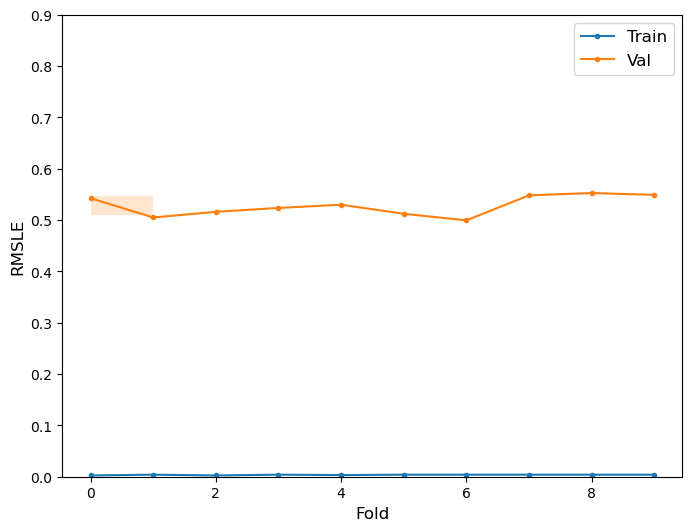

In [30]:
### Ayuda de Gráfica
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(rmsle_train, '.-',color='tab:blue',label='Train')
plt.plot(rmsle_val, '.-',color='tab:orange',label='Val')

## Se grafica la media y desviación etándar
plt.fill_between(np.arange(cv_splits), mean_rmsle_train + std_rmsle_train, mean_rmsle_train - std_rmsle_train, alpha=0.2)
plt.fill_between(np.arange(cv_splits), mean_rmsle_val + std_rmsle_val, mean_rmsle_val - std_rmsle_val, alpha=0.2)

plt.xlabel('Fold',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.ylim([0,0.9])
plt.show()

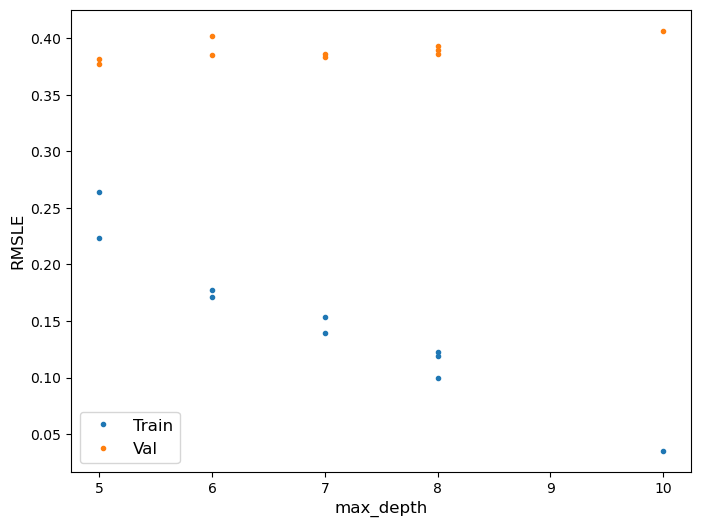

In [25]:
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(cv_results['param_regressor__max_depth'], -cv_results['mean_train_score'], '.',color='tab:blue',label='Train')
plt.plot(cv_results['param_regressor__max_depth'], -cv_results['mean_test_score'], '.',color='tab:orange',label='Val')

plt.xlabel('max_depth',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.show()

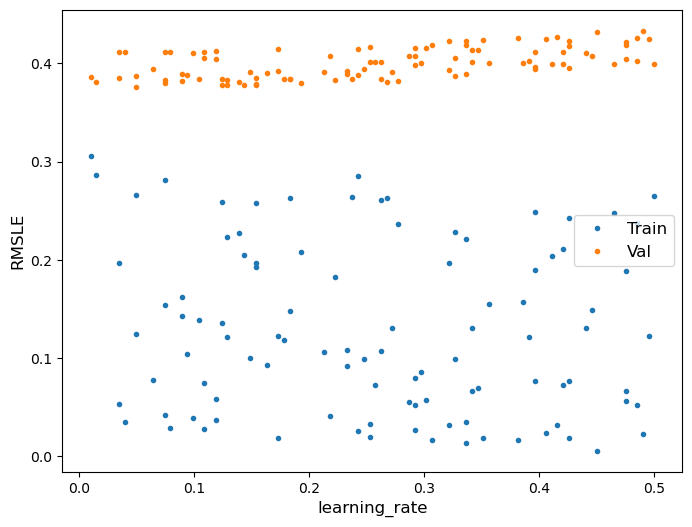

In [31]:
## Se crea la figura
plt.figure(figsize=(8,6))

## Se grafican los valores de RMSLE de entrenamiento y validación
plt.plot(cv_results['param_regressor__learning_rate'], -cv_results['mean_train_score'], '.',color='tab:blue',label='Train')
plt.plot(cv_results['param_regressor__learning_rate'], -cv_results['mean_test_score'], '.',color='tab:orange',label='Val')

plt.xlabel('learning_rate',fontsize='large')
plt.ylabel('RMSLE',fontsize='large')
plt.legend(fontsize='large')
plt.show()

## Parte 7 - Custom Transformers

- Construir un *Custom Transformer* que extraiga las caracterísicas temporales, siguiendo el ejemplo del capítulo 2 del libro.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class DatetimeTransform(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_new = X.copy()
        X_new['datetime'] = pd.to_datetime(X_new['datetime'])
        
        X_new['hour'] = X_new['datetime'].dt.hour
        X_new['weekday'] = X_new['datetime'].dt.weekday
        X_new['month'] = X_new['datetime'].dt.month

        X_new = X_new.drop(columns=["datetime"])
        return X_new

## Parte 8 - Generar un modelo

#### Objetivos:

 - Generar el mejor modelo posible. Se podrá explorar posibles mejoras en cualquiera de las siguientes etapas:

    - Parámetros óptimos del regresor.
    - Predicción de alquileres registered y casual por separado.
    - Separación de conjunto de Entrenamiento y Validación tomando en cuenta la generación del conjunto de Test del desafío.
    - Cambios en las características utilizadas. (Agregando o quitando alguna de ellas)

In [21]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### (Opcional) librería de visualización de datos
#import seaborn as sns
#sns.set_theme(style="whitegrid")

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('sampleSubmission.csv')

In [22]:
from sklearn.model_selection import train_test_split

X = df_train.copy()
y = df_train[["count", "casual", "registered"]]

X['datetime'] = pd.to_datetime(X['datetime'])
X['hour'] = X['datetime'].dt.hour
X['weekday'] = X['datetime'].dt.weekday
X['month'] = X['datetime'].dt.month

# "count" es la columna objetivo, "casual" y "registered" son parte del objetivo
# pero solo queremos predecir la cantidad total de bicicletas alquiladas.
X = X.drop(columns=["count", "casual", "registered", "datetime"])

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month
2815,3,0,1,1,27.88,31.820,83,6.0032,5,2,7
8695,3,0,0,1,36.90,40.910,39,19.9995,16,5,8
8406,3,0,1,1,32.80,35.605,41,16.9979,15,2,7
1543,2,0,0,2,14.76,18.180,93,7.0015,4,6,4
4952,4,0,0,1,13.12,15.150,45,16.9979,10,5,11


In [24]:
y_train.head()

,count,casual,registered
2815,35,5,30
8695,450,197,253
8406,276,56,220
1543,5,3,2
4952,200,35,165


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='most_frequent')
imputer.set_output(transform="pandas")

preprocess_pipeline = Pipeline([
    #('imputer', imputer),
    ('date_to_month', DatetimeTransform()),
])

In [31]:
from sklearn.metrics import root_mean_squared_error
optimization_metric = root_mean_squared_error
evaluation_metric = 'neg_root_mean_squared_log_error'

In [32]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.compose import TransformedTargetRegressor

boost = xgb.sklearn.XGBRegressor(
    #n_jobs=-1,
    n_estimators=1000,
    early_stopping_rounds=5,
    eval_metric=optimization_metric,
    random_state=42
    #objective="count:poisson"
    #learning_rate=0.05,
    #max_depth=5
)

transf_target_regressor = TransformedTargetRegressor(
    regressor=boost,
    func=np.log1p, inverse_func=np.expm1
)

In [33]:
estimator_registered = Pipeline([
    #('preproccess', preprocess_pipeline),
    ('transf_target_regressor', transf_target_regressor)
    #('boost', boost)
])
estimator_casual = Pipeline([
    #('preproccess', preprocess_pipeline),
    ('transf_target_regressor', transf_target_regressor)
    #('boost', boost)
])
estimator_count = Pipeline([
    #('preproccess', preprocess_pipeline),
    ('transf_target_regressor', transf_target_regressor)
    #('boost', boost)
])

In [35]:
%%capture
from sklearn.model_selection import RandomizedSearchCV

param_distributions_boost = {
    'boost__max_depth': [None] + list(range(12)),
    'boost__learning_rate': np.linspace(0.01, 0.5, 100),
}

param_distributions = {
    'transf_target_regressor__regressor__max_depth': [None] + list(range(12)),
    'transf_target_regressor__regressor__learning_rate': np.linspace(0.01, 0.5, 100),
}

cv_registered = RandomizedSearchCV(
    estimator_registered, 
    param_distributions,
    scoring=evaluation_metric,
    refit=True,
    return_train_score=True,
    cv=3,
    n_iter=50,
)
cv_casual = RandomizedSearchCV(
    estimator_casual, 
    param_distributions,
    scoring=evaluation_metric,
    refit=True,
    return_train_score=True,
    cv=3,
    n_iter=50,
)
cv_count = RandomizedSearchCV(
    estimator_count, 
    param_distributions,
    scoring=evaluation_metric,
    refit=True,
    return_train_score=True,
    cv=3,
    n_iter=50,
)

cv_count.fit(X_train, y_train["count"], transf_target_regressor__eval_set=[(X_val, y_val["count"])])
#cv_casual.fit(X_train, y_train["casual"], transf_target_regressor__eval_set=[(X_val, y_val["casual"])])
#cv_registered.fit(X_train, y_train["registered"], transf_target_regressor__eval_set=[(X_val, y_val["registered"])])

In [36]:
#print("casual params:", cv_casual.best_params_)
#print("registered params:", cv_registered.best_params_)
print("count params:", cv_count.best_params_)

count params: {'transf_target_regressor__regressor__max_depth': 8, 'transf_target_regressor__regressor__learning_rate': 0.13373737373737374}


In [40]:
from sklearn.metrics import root_mean_squared_log_error

y_val_registered_pred = cv_registered.predict(X_val)
y_val_casual_pred = cv_casual.predict(X_val)
y_val_count_pred = cv_count.predict(X_val)

print("Registered RMSLE:", root_mean_squared_log_error(y_val["registered"], y_val_registered_pred + 1))
print("Casual RMSLE:", root_mean_squared_log_error(y_val["casual"], y_val_casual_pred + 1))
print("Registered + Casual RMSLE:", root_mean_squared_log_error(y_val["count"], y_val_casual_pred + y_val_registered_pred + 1))
print("Count RMSLE:", root_mean_squared_log_error(y_val["count"], y_val_count_pred))

Registered RMSLE: 0.3644695866066008
Casual RMSLE: 0.5866257020759664
Registered + Casual RMSLE: 0.3621278798358068
Count RMSLE: 0.3565203276138107


## Parte 9 - Submit
Construir un *pipeline* para el estimador que consideren que tuvo mejor desempeño. El pre-procesamiento debe incluir la extracción de las nuevas características.

Subir los resultados del *pipeline* para los datos de *test*,  a la [página](https://www.kaggle.com/c/bike-sharing-demand/submissions) de la competencia.

In [41]:
df_submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [44]:
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [37]:
from sklearn.model_selection import train_test_split

X = df_test.copy()

X['datetime'] = pd.to_datetime(X['datetime'])
X['hour'] = X['datetime'].dt.hour
X['weekday'] = X['datetime'].dt.weekday
X['month'] = X['datetime'].dt.month

# "count" es la columna objetivo, "casual" y "registered" son parte del objetivo
# pero solo queremos predecir la cantidad total de bicicletas alquiladas.
X = X.drop(columns=["datetime"])

In [38]:
y = pd.DataFrame()
y["datetime"] = df_test["datetime"]
y["count"] = np.round(cv_count.predict(X)).astype(int)

In [39]:
y.head()

,datetime,count
0,2011-01-20 00:00:00,20
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,3
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,2


In [66]:
y.to_csv("submission.csv", index=False)

In [40]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.4 MB/s eta 0:00:000m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 25.4 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 14.4 MB/s eta 0:00:00m eta 0:00:010:00:01


In [72]:
import shap

model = xgb.sklearn.XGBRegressor(
    #n_jobs=-1,
    n_estimators=1000,
    #early_stopping_rounds=5,
    eval_metric=optimization_metric,
    random_state=42,
    #objective="count:poisson"
    learning_rate=0.13373737373737374,
    max_depth=8
).fit(X_train, y_train["count"])

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [73]:
X.iloc[858,:]

season         2.0000
holiday        0.0000
workingday     0.0000
weather        1.0000
temp          26.2400
atemp         30.3050
humidity      69.0000
windspeed     11.0014
hour          18.0000
weekday        6.0000
month          4.0000
Name: 858, dtype: float64

In [89]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[857, :], X.iloc[857, :], show=False,matplotlib=True).savefig('shap.png')
#shap.summary_plot(shap_values[858:,:], X.iloc[858:,:], show=False)
#f.savefig("shap.png")



*   ¿Cuánto fue el valor de RMSLE para el conjunto de test?


In [67]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "Message"

100%|█████████████████████████████████████████| 149k/149k [00:00<00:00, 166kB/s]
Successfully submitted to Bike Sharing Demand

In [68]:
0.45173

0.45173